In [1]:
#! -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import glob
import imageio
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import preprocess_input
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from keras.backend import int_shape
from sklearn.utils import class_weight

Using TensorFlow backend.


## Import Data 

In [2]:
### change the dataset here###
dataset = 'AWA2'
##############################


batch_size = 64
train_dir = './data/{}/IMG/train'.format(dataset)
val_dir = './data/{}/IMG/val'.format(dataset)
IMG_SHAPE = 128
epochs = 150


alpha = 0.5 # global loss
beta = 0.3 # local loss
gamma = 1.8 # prior loss

# attr_type = 'b','c','cmm','cms'
attr_type = 'cms'

if dataset == 'SUN':
    class_attr_shape = (102, )
    lable_shape = (645, )
    class_attr_dim = 102
    class_num = 717
    seen_class_num = 645
    unseen_class_num = 72
elif dataset == 'CUB':
    class_attr_shape = (312, )
    lable_shape = (150, )
    class_attr_dim = 312
    class_num = 200
    seen_class_num = 150
    unseen_class_num = 50
elif dataset == 'AWA2':
    class_attr_shape = (85, )
    lable_shape = (40, )
    class_attr_dim = 85
    class_num = 50
    seen_class_num = 40
    unseen_class_num = 10
elif dataset == 'plant':
    class_attr_shape = (35, )
    lable_shape = (25, )
    class_attr_dim = 35
    class_num = 38
    seen_class_num = 25
    unseen_class_num = 13

## Continous attr mean std

In [3]:
attr_continous_path = './data/{}/predicate-matrix-continuous.txt'.format(dataset)
attr_list = []
RealCE_continous = pd.read_csv(attr_continous_path,header=None,sep = '\t')
for idx in range(len(RealCE_continous)):
    tmp = RealCE_continous[0][idx].split(' ')
    attr = [float(i) for i in tmp if i!='']
    attr = np.array(attr)
    attr = (attr - np.mean(attr)) / np.std(attr)
    attr_list.append(attr)

## CBAM block 

In [4]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

## SE block V2 

In [5]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

## ResNet Block

In [6]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    
    x = cbam_block(x)    
    
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [7]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    x = cbam_block(x)    
   
    
    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

## Scaler

In [8]:
class Scaler(Layer):
    def __init__(self, tau=0.5, **kwargs):
        super(Scaler, self).__init__(**kwargs)
        self.tau = tau
    
    def build(self, input_shape):
        super(Scaler, self).build(input_shape)
        self.scale = self.add_weight(
            name='scale', shape=(input_shape[-1],), initializer='zeros'
        )
    
    def call(self, inputs, mode='positive'):
        if mode == 'positive':
            scale = self.tau + (1 - self.tau) * K.sigmoid(self.scale)
        
        else:
            scale = (1 - self.tau) * K.sigmoid(-self.scale)
        
        return inputs * K.sqrt(scale)
    
    def get_config(self):
        config = {'tau': self.tau}
        base_config = super(Scaler, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
def preprocess_image(img):
    data_format = K.image_data_format()
    
    if data_format == 'channels_last':
        # 'RGB'->'BGR'
        if img.ndim == 3:
            img = img[::-1, ...]
        else:
            img = img[:, ::-1, ...]
    
    
    else:
        # 'RGB'->'BGR'
        img = img[..., ::-1]
    
    mean = [103.939, 116.779, 123.68]
    std = None
    
    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if img.ndim == 3:
            img[0, :, :] -= mean[0]
            img[1, :, :] -= mean[1]
            img[2, :, :] -= mean[2]


            if std is not None:
                img[0, :, :] /= std[0]
                img[1, :, :] /= std[1]
                img[2, :, :] /= std[2]
        else:
            img[:, 0, :, :] -= mean[0]
            img[:, 1, :, :] -= mean[1]
            img[:, 2, :, :] -= mean[2]
            if std is not None:
                img[:, 0, :, :] /= std[0]
                img[:, 1, :, :] /= std[1]
                img[:, 2, :, :] /= std[2]
    else:
        img[..., 0] -= mean[0]
        img[..., 1] -= mean[1]
        img[..., 2] -= mean[2]


        if std is not None:
            img[..., 0] /= std[0]
            img[..., 1] /= std[1]
            img[..., 2] /= std[2]

    
    return img

## Data generate

In [10]:
def generate_generator_multiple(generator,dir1, batch_size, IMG_SHAPE):
    genX1 = generator.flow_from_directory(
                                        batch_size=batch_size,
                                        directory=dir1,
                                        shuffle=True,
                                        color_mode="rgb",
                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                        class_mode='categorical',
                                        seed = 42)
    while True:
            X1i = genX1.next()
            attr_array = []
            for i in range(X1i[1].shape[0]):
                idx = np.where(X1i[1][i])[0][0]
                attr_array.append(attr_list[idx])
            
            yield [X1i[0], np.array(attr_array)], None  #Yield both images and their mutual label

In [11]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_data_gen = generate_generator_multiple(image_gen, train_dir, batch_size, IMG_SHAPE)
val_data_gen = generate_generator_multiple(image_gen, val_dir, batch_size, IMG_SHAPE)

In [12]:
image_size = IMG_SHAPE
tmp_train_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    color_mode="rgb",
    target_size=(image_size,image_size),
    class_mode='sparse',
    seed = 42
)


tmp_val_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(image_size, image_size),
    class_mode='sparse',
    color_mode="rgb",
    seed = 42
    
)

Found 58176 images belonging to 40 classes.
Found 15872 images belonging to 40 classes.


## Model

In [13]:
y_in = Input(shape=class_attr_shape)

In [14]:
# Encoder

if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1

x_in = Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))
x = x_in

x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
x = Conv2D(64, (7, 7),
                  strides=(2, 2),
                  padding='valid',
                  kernel_initializer='he_normal',
                  name='conv1')(x)
x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

# 嘗試加入局部特徵點
feature_map = x

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')


x = GlobalAveragePooling2D(name='avg_pool')(x)


# generate ce
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
#x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)

z_mean = Dense(class_attr_dim)(x)
z_log_var = Dense(class_attr_dim)(x)

scaler = Scaler()
z_mean = scaler(z_mean, mode='positive')
z_log_var = scaler(z_log_var, mode='negative')



def sampling(args):
    z_mean, z_log_var = args
    u = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * u


z_samples = Lambda(sampling)([z_mean, z_log_var])
encoder = Model(x_in, z_samples) 

prior_kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean - y_in) - K.exp(z_log_var))

# shuffle層
def shuffling(x):
    idxs = K.arange(0, K.shape(x)[0])
    idxs = tf.random_shuffle(idxs)
    return K.gather(x, idxs)


# 與隨機採樣的特徵拼接（全局）
z_shuffle = Lambda(shuffling)(z_samples)
z_z_1 = Concatenate()([z_samples, z_samples])
z_z_2 = Concatenate()([z_samples, z_shuffle])

# TODO: 1. 局部的權重是否應降低、或是導入variance的概念？ 局部是顏色 形狀 斑點...等

# 與隨機採樣的特徵拼接（局部）
feature_map_shuffle = Lambda(shuffling)(feature_map)
z_samples_repeat = RepeatVector(16 * 16)(z_samples)
z_samples_map = Reshape((16, 16, class_attr_dim))(z_samples_repeat)
z_f_1 = Concatenate()([z_samples_map, feature_map])
z_f_2 = Concatenate()([z_samples_map, feature_map_shuffle])

# 全局判別器
z_in = Input(shape=(class_attr_dim*2,))
z = z_in
z = Dense(class_attr_dim, activation='relu')(z)
z = Dense(class_attr_dim, activation='relu')(z)
z = Dense(class_attr_dim, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

GlobalDiscriminator = Model(z_in, z)

z_z_1_scores = GlobalDiscriminator(z_z_1)
z_z_2_scores = GlobalDiscriminator(z_z_2)
global_info_loss = - K.mean(K.log(z_z_1_scores + 1e-6) + K.log(1 - z_z_2_scores + 1e-6))


# 局部判别器
z_in = Input(shape=(None, None, 597))
z = z_in
z = Dense(256, activation='relu')(z)
z = Dense(256, activation='relu')(z)
z = Dense(256, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

LocalDiscriminator = Model(z_in, z)

z_f_1_scores = LocalDiscriminator(z_f_1)
z_f_2_scores = LocalDiscriminator(z_f_2)
local_info_loss = - K.mean(K.log(z_f_1_scores + 1e-6) + K.log(1 - z_f_2_scores + 1e-6))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model_train = Model([x_in, y_in],[z_z_1_scores, z_z_2_scores,z_f_1_scores, z_f_2_scores])
model_train.load_weights('/home/uscc/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name=True)

## Plot the model

In [16]:
#plot_model(model_train, show_shapes=True, to_file='./infomax_model.png')

## Memo

#### 1. modigy the local and global weights

## 訓練Model

In [17]:
# 訓練model

model_train.add_loss(gamma * prior_kl_loss)
model_train.add_loss(alpha * global_info_loss) # global
model_train.add_loss(beta * local_info_loss) # local

model_train.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

model_train.metrics_tensors.append(gamma * prior_kl_loss)
model_train.metrics_names.append("kl_loss")

model_train.metrics_tensors.append(alpha * global_info_loss)
model_train.metrics_names.append("global_loss")

model_train.metrics_tensors.append(beta * local_info_loss)
model_train.metrics_names.append("local_loss")


early_stopping = EarlyStopping(monitor='val_loss', patience=13,verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            mode='auto')


STEP_SIZE_TRAIN=tmp_train_gen.n//tmp_train_gen.batch_size
STEP_SIZE_VALID=tmp_val_gen.n//tmp_val_gen.batch_size



In [18]:
model_train.fit_generator(
                    train_data_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs = epochs,
                    validation_data=val_data_gen,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks = [early_stopping, learning_rate_reduction]
                  )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/150
Found 15872 images belonging to 40 classes.
Found 58176 images belonging to 40 classes.
909/909 [==============================] - 1505s 2s/step - loss: 1.6404 - kl_loss: 1.0450 - global_loss: 0.1992 - local_loss: 0.3962 - val_loss: 1.0264 - val_kl_loss: 0.6273 - val_global_loss: 0.0502 - val_local_loss: 0.3489
Epoch 2/150
909/909 [==============================] - 1369s 2s/step - loss: 1.0764 - kl_loss: 0.7473 - global_loss: 0.0483 - local_loss: 0.2808 - val_loss: 0.9242 - val_kl_loss: 0.6194 - val_global_loss: 0.0464 - val_local_loss: 0.2584
Epoch 3/150
909/909 [==============================] - 1357s 1s/step - loss: 0.9204 - kl_loss: 0.6624 - global_loss: 0.0452 - local_loss: 0.2129 - val_loss: 0.8219 - val_kl_loss: 0.5942 - val_global_loss: 0.0440 - val_local_loss: 0.1838
Epoch 4/150
909/909 [==============================] - 1347s 1s/step - loss: 0.7920 - kl_loss: 0.5723 - glo

909/909 [==============================] - 1349s 1s/step - loss: 0.2306 - kl_loss: 0.0945 - global_loss: 0.0398 - local_loss: 0.0964 - val_loss: 0.4595 - val_kl_loss: 0.3284 - val_global_loss: 0.0378 - val_local_loss: 0.0934
Epoch 66/150
909/909 [==============================] - 1367s 2s/step - loss: 0.2329 - kl_loss: 0.0943 - global_loss: 0.0409 - local_loss: 0.0977 - val_loss: 0.4607 - val_kl_loss: 0.3275 - val_global_loss: 0.0421 - val_local_loss: 0.0911
Epoch 67/150
909/909 [==============================] - 1340s 1s/step - loss: 0.2316 - kl_loss: 0.0943 - global_loss: 0.0404 - local_loss: 0.0969 - val_loss: 0.4678 - val_kl_loss: 0.3283 - val_global_loss: 0.0423 - val_local_loss: 0.0971

Epoch 00067: ReduceLROnPlateau reducing learning rate to 9.99999874573554e-12.
Epoch 68/150
909/909 [==============================] - 1337s 1s/step - loss: 0.2303 - kl_loss: 0.0943 - global_loss: 0.0396 - local_loss: 0.0964 - val_loss: 0.4609 - val_kl_loss: 0.3280 - val_global_loss: 0.0378 - val_

In [19]:
encoder.save('./model/{}/encoder_{}.h5'.format(dataset,'Infomax_With_Pretrained_Weight_cbamblock'))

In [20]:
# encoder = load_model('./model/{}/encoder_{}.h5'.format(dataset,'without_infomax'), custom_objects={'Scaler': Scaler})

In [21]:
mean = [103.939, 116.779, 123.68]

# 随机选一张图片，输出最相近的图片
# 可以选用欧氏距离或者cos值
def sample_knn(path, prefix):
    n = 10
    topn = 10
    figure1 = np.zeros((IMG_SHAPE*n, IMG_SHAPE*topn, 3))
    figure2 = np.zeros((IMG_SHAPE*n, IMG_SHAPE*topn, 3))
    zs_ = zs / (zs**2).sum(1, keepdims=True)**0.5
#     zs_ = zs
    for i in range(n):
        one = np.random.choice(len(x_test))
        idxs = ((zs**2).sum(1) + (zs[one]**2).sum() - 2 * np.dot(zs, zs[one])).argsort()[:topn]
        for j,k in enumerate(idxs):
            digit = x_test[k]
            figure1[i*IMG_SHAPE: (i+1)*IMG_SHAPE,
                   j*IMG_SHAPE: (j+1)*IMG_SHAPE] = digit
        idxs = np.dot(zs_, zs_[one]).argsort()[-n:][::-1]
        for j,k in enumerate(idxs):
            digit = x_test[k]
            figure2[i*IMG_SHAPE: (i+1)*IMG_SHAPE,
                   j*IMG_SHAPE: (j+1)*IMG_SHAPE] = digit
    
    figure1[..., 0] += mean[0]
    figure1[..., 1] += mean[1]
    figure1[..., 2] += mean[2]
    figure1 = figure1[::-1, ...]
    figure1 = np.clip(figure1, 0, 255)
    
    figure2[..., 0] += mean[0]
    figure2[..., 1] += mean[1]
    figure2[..., 2] += mean[2]
    figure2 = figure2[::-1, ...]
    figure2 = np.clip(figure1, 0, 255)
    imageio.imwrite(path+'_l2_'+ prefix + '.png', figure1)
    imageio.imwrite(path+'_cos_'+ prefix + '.png', figure2)

## Unseen

In [22]:
tmp_test_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory='./data/{}/IMG/test'.format(dataset),
    target_size=(image_size, image_size),
    class_mode='sparse',
    color_mode="rgb",
    seed = 42
    
)

Found 9938 images belonging to 10 classes.


In [23]:
x_test = np.array([]).reshape(0,IMG_SHAPE,IMG_SHAPE,3)
x = 0
for data in tmp_test_gen:
    x_test = np.concatenate((x_test, data[0]))
    x += 1
    print(x_test.shape)
    if x == 150:
        break

(64, 128, 128, 3)
(128, 128, 128, 3)
(192, 128, 128, 3)
(256, 128, 128, 3)
(320, 128, 128, 3)
(384, 128, 128, 3)
(448, 128, 128, 3)
(512, 128, 128, 3)
(576, 128, 128, 3)
(640, 128, 128, 3)
(704, 128, 128, 3)
(768, 128, 128, 3)
(832, 128, 128, 3)
(896, 128, 128, 3)
(960, 128, 128, 3)
(1024, 128, 128, 3)
(1088, 128, 128, 3)
(1152, 128, 128, 3)
(1216, 128, 128, 3)
(1280, 128, 128, 3)
(1344, 128, 128, 3)
(1408, 128, 128, 3)
(1472, 128, 128, 3)
(1536, 128, 128, 3)
(1600, 128, 128, 3)
(1664, 128, 128, 3)
(1728, 128, 128, 3)
(1792, 128, 128, 3)
(1856, 128, 128, 3)
(1920, 128, 128, 3)
(1984, 128, 128, 3)
(2048, 128, 128, 3)
(2112, 128, 128, 3)
(2176, 128, 128, 3)
(2240, 128, 128, 3)
(2304, 128, 128, 3)
(2368, 128, 128, 3)
(2432, 128, 128, 3)
(2496, 128, 128, 3)
(2560, 128, 128, 3)
(2624, 128, 128, 3)
(2688, 128, 128, 3)
(2752, 128, 128, 3)
(2816, 128, 128, 3)
(2880, 128, 128, 3)
(2944, 128, 128, 3)
(3008, 128, 128, 3)
(3072, 128, 128, 3)
(3136, 128, 128, 3)
(3200, 128, 128, 3)
(3264, 128, 128,

In [24]:
# 输出编码器的特征
zs = encoder.predict(x_test, verbose=True)
print(zs.mean()) # 查看均值
print(zs.std()) # 查看方差

9600/9600 [==============================] - 36s 4ms/step
0.003616612
1.3180997


In [38]:
sample_knn('./library_Pic/', 'unseen_without_deepinfo_with_categrocial')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


## Seen

In [30]:
x_test = np.array([]).reshape(0,IMG_SHAPE,IMG_SHAPE,3)

x = 0
for data in tmp_val_gen:
    x_test = np.concatenate((x_test, data[0]))
    x += 1
    print(x_test.shape)
    if x == 150:
        break

(64, 128, 128, 3)
(128, 128, 128, 3)
(192, 128, 128, 3)
(256, 128, 128, 3)
(320, 128, 128, 3)
(384, 128, 128, 3)
(448, 128, 128, 3)
(512, 128, 128, 3)
(576, 128, 128, 3)
(640, 128, 128, 3)
(704, 128, 128, 3)
(768, 128, 128, 3)
(832, 128, 128, 3)
(896, 128, 128, 3)
(960, 128, 128, 3)
(1024, 128, 128, 3)
(1088, 128, 128, 3)
(1152, 128, 128, 3)
(1216, 128, 128, 3)
(1280, 128, 128, 3)
(1344, 128, 128, 3)
(1408, 128, 128, 3)
(1472, 128, 128, 3)
(1536, 128, 128, 3)
(1600, 128, 128, 3)
(1664, 128, 128, 3)
(1728, 128, 128, 3)
(1792, 128, 128, 3)
(1856, 128, 128, 3)
(1920, 128, 128, 3)
(1984, 128, 128, 3)
(2048, 128, 128, 3)
(2112, 128, 128, 3)
(2176, 128, 128, 3)
(2240, 128, 128, 3)
(2304, 128, 128, 3)
(2368, 128, 128, 3)
(2432, 128, 128, 3)
(2496, 128, 128, 3)
(2560, 128, 128, 3)
(2624, 128, 128, 3)
(2688, 128, 128, 3)
(2752, 128, 128, 3)
(2816, 128, 128, 3)
(2880, 128, 128, 3)
(2944, 128, 128, 3)
(3008, 128, 128, 3)
(3072, 128, 128, 3)
(3136, 128, 128, 3)
(3200, 128, 128, 3)
(3264, 128, 128,

In [31]:
# 输出编码器的特征
zs = encoder.predict(x_test, verbose=True)
print(zs.mean()) # 查看均值
print(zs.std()) # 查看方差


9600/9600 [==============================] - 33s 3ms/step
-0.0007585244
1.3627281


In [32]:
sample_knn('./library_Pic/', 'seen_without_deepinfo_with_categrocial')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


## 觀察seen attr分佈

In [33]:
train_attr_list_cms = []
classname = pd.read_csv('./data/{}/classes.txt'.format(dataset), header=None, sep='\t')

for k ,v in tmp_train_gen.class_indices.items():
    idx = np.where(classname[1] == k)
    train_attr_list_cms.append(attr_list[idx[0][0]])

In [34]:
# sum 40 class attributes
sum_attr = [[] for i in range(seen_class_num)]
real_attr = [[] for i in range(seen_class_num)]
count_class = [0 for i in range(seen_class_num)]

N = tmp_train_gen.n - 100
s = 0 
for data, label in tmp_train_gen:
    ce = encoder.predict(data)
    s += batch_size
    print(s, ' ', N)
    if s > N:
        break
    for idx in range(batch_size):
        l = int(label[idx])
        if sum_attr[l] == []:
            sum_attr[l] = ce[idx]
            real_attr[l] = train_attr_list_cms[l]
        else:    
            sum_attr[l] += ce[idx]
    
        count_class[l] += 1
# averge
for i in range(seen_class_num):
    sum_attr[i] = sum_attr[i] / count_class[i]

sum_attr = np.array(sum_attr)



64   58076
128   58076
192   58076
256   58076
320   58076
384   58076
448   58076
512   58076
576   58076
640   58076
704   58076
768   58076
832   58076
896   58076
960   58076
1024   58076
1088   58076
1152   58076
1216   58076
1280   58076
1344   58076
1408   58076
1472   58076
1536   58076
1600   58076
1664   58076
1728   58076
1792   58076
1856   58076
1920   58076
1984   58076
2048   58076
2112   58076
2176   58076
2240   58076
2304   58076
2368   58076
2432   58076
2496   58076
2560   58076
2624   58076
2688   58076
2752   58076
2816   58076
2880   58076
2944   58076
3008   58076
3072   58076
3136   58076
3200   58076
3264   58076
3328   58076
3392   58076
3456   58076
3520   58076
3584   58076
3648   58076
3712   58076
3776   58076
3840   58076
3904   58076
3968   58076
4032   58076
4096   58076
4160   58076
4224   58076
4288   58076
4352   58076
4416   58076
4480   58076
4544   58076
4608   58076
4672   58076
4736   58076
4800   58076
4864   58076
4928   58076
4992   58076
50

38336   58076
38400   58076
38464   58076
38528   58076
38592   58076
38656   58076
38720   58076
38784   58076
38848   58076
38912   58076
38976   58076
39040   58076
39104   58076
39168   58076
39232   58076
39296   58076
39360   58076
39424   58076
39488   58076
39552   58076
39616   58076
39680   58076
39744   58076
39808   58076
39872   58076
39936   58076
40000   58076
40064   58076
40128   58076
40192   58076
40256   58076
40320   58076
40384   58076
40448   58076
40512   58076
40576   58076
40640   58076
40704   58076
40768   58076
40832   58076
40896   58076
40960   58076
41024   58076
41088   58076
41152   58076
41216   58076
41280   58076
41344   58076
41408   58076
41472   58076
41536   58076
41600   58076
41664   58076
41728   58076
41792   58076
41856   58076
41920   58076
41984   58076
42048   58076
42112   58076
42176   58076
42240   58076
42304   58076
42368   58076
42432   58076
42496   58076
42560   58076
42624   58076
42688   58076
42752   58076
42816   58076
42880 

In [35]:
seen_class = []
for k,v in tmp_train_gen.class_indices.items():
    seen_class.append(k)

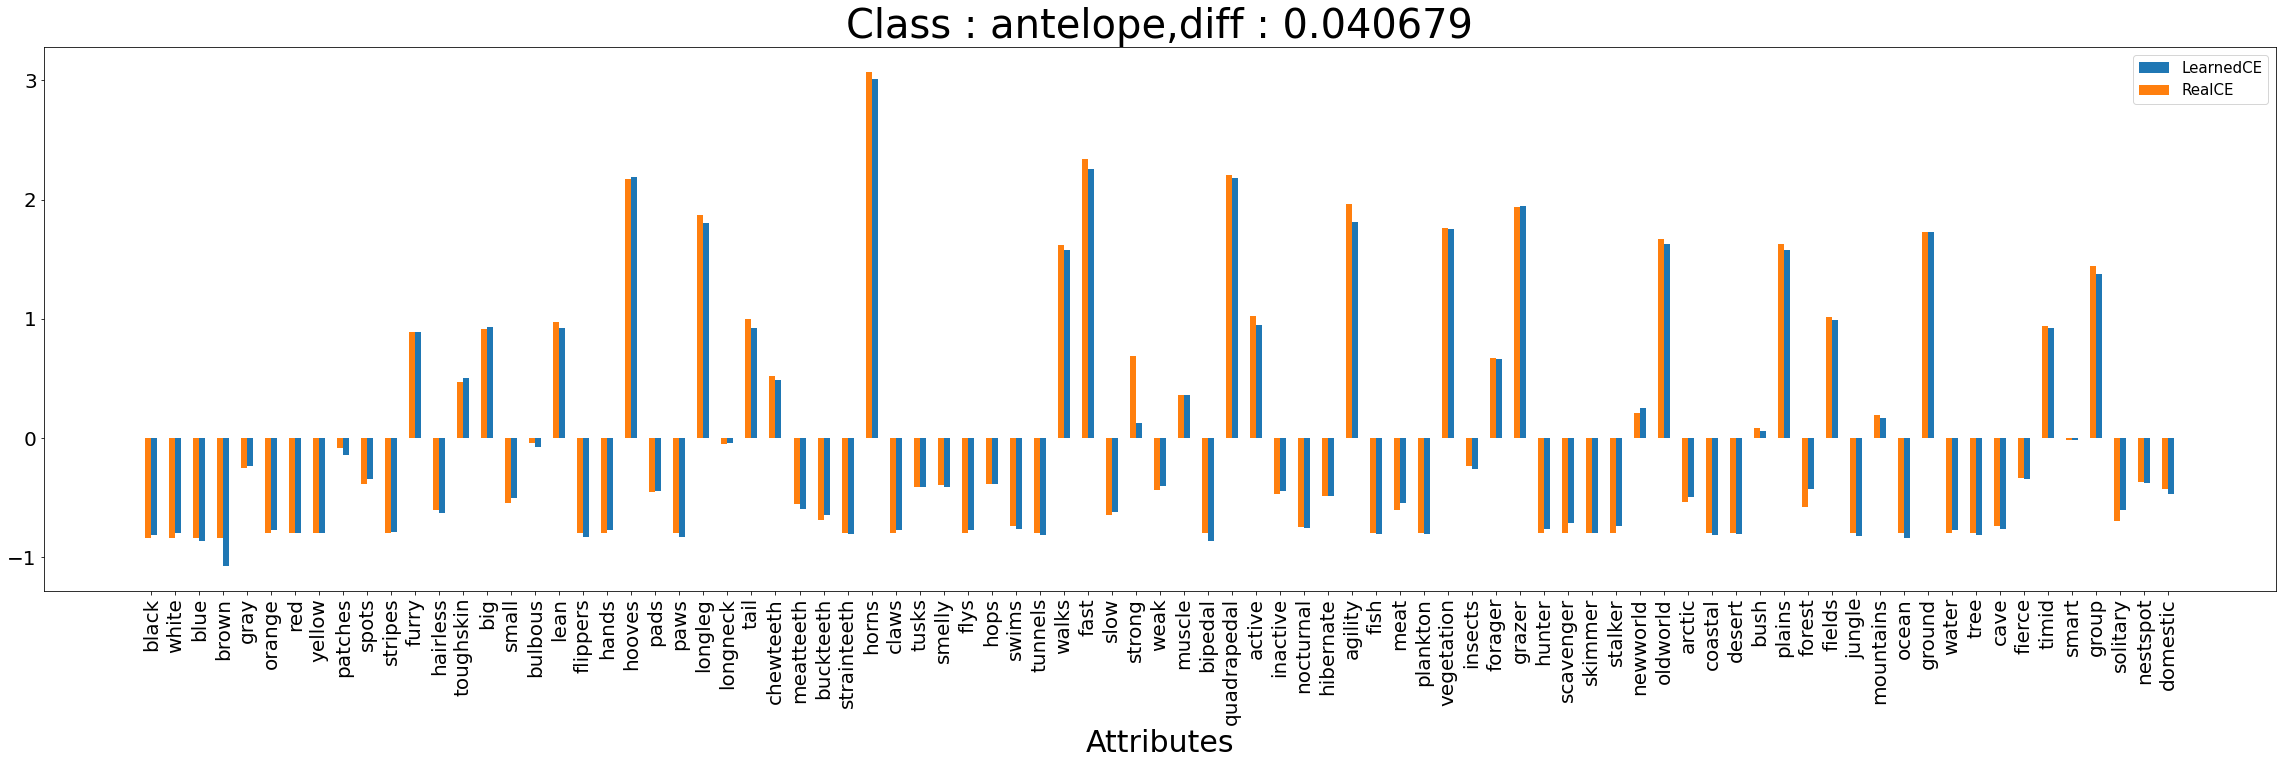

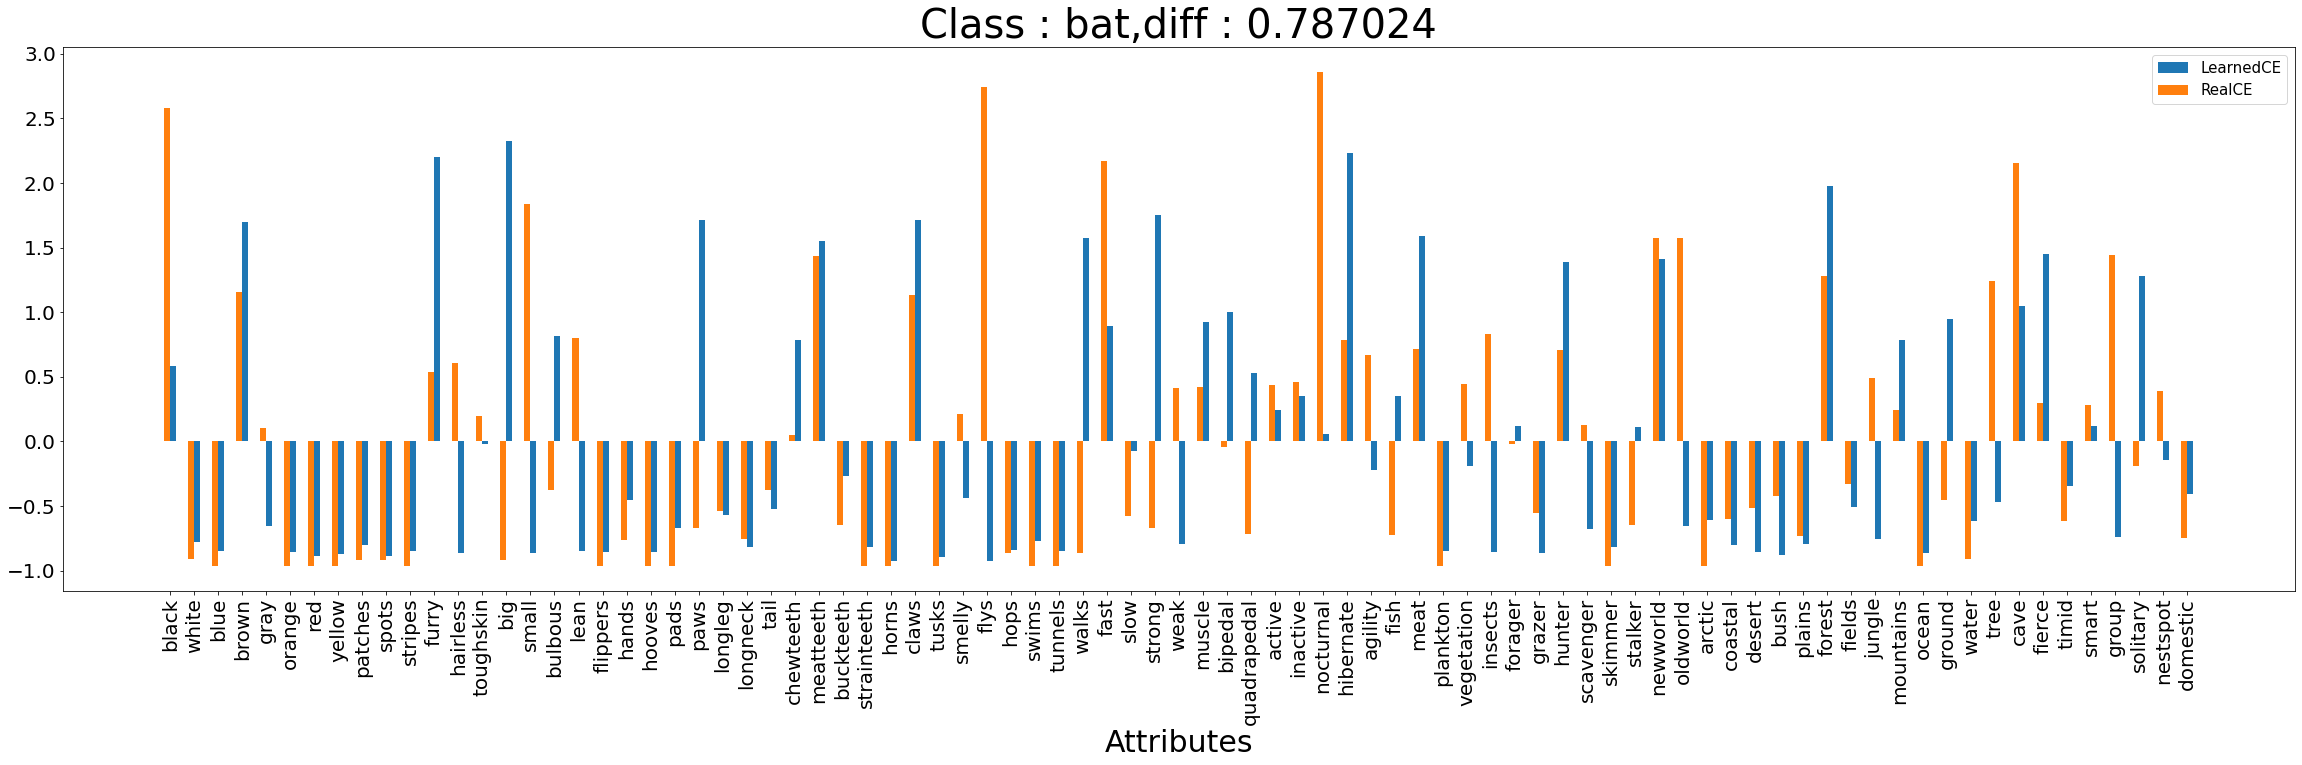

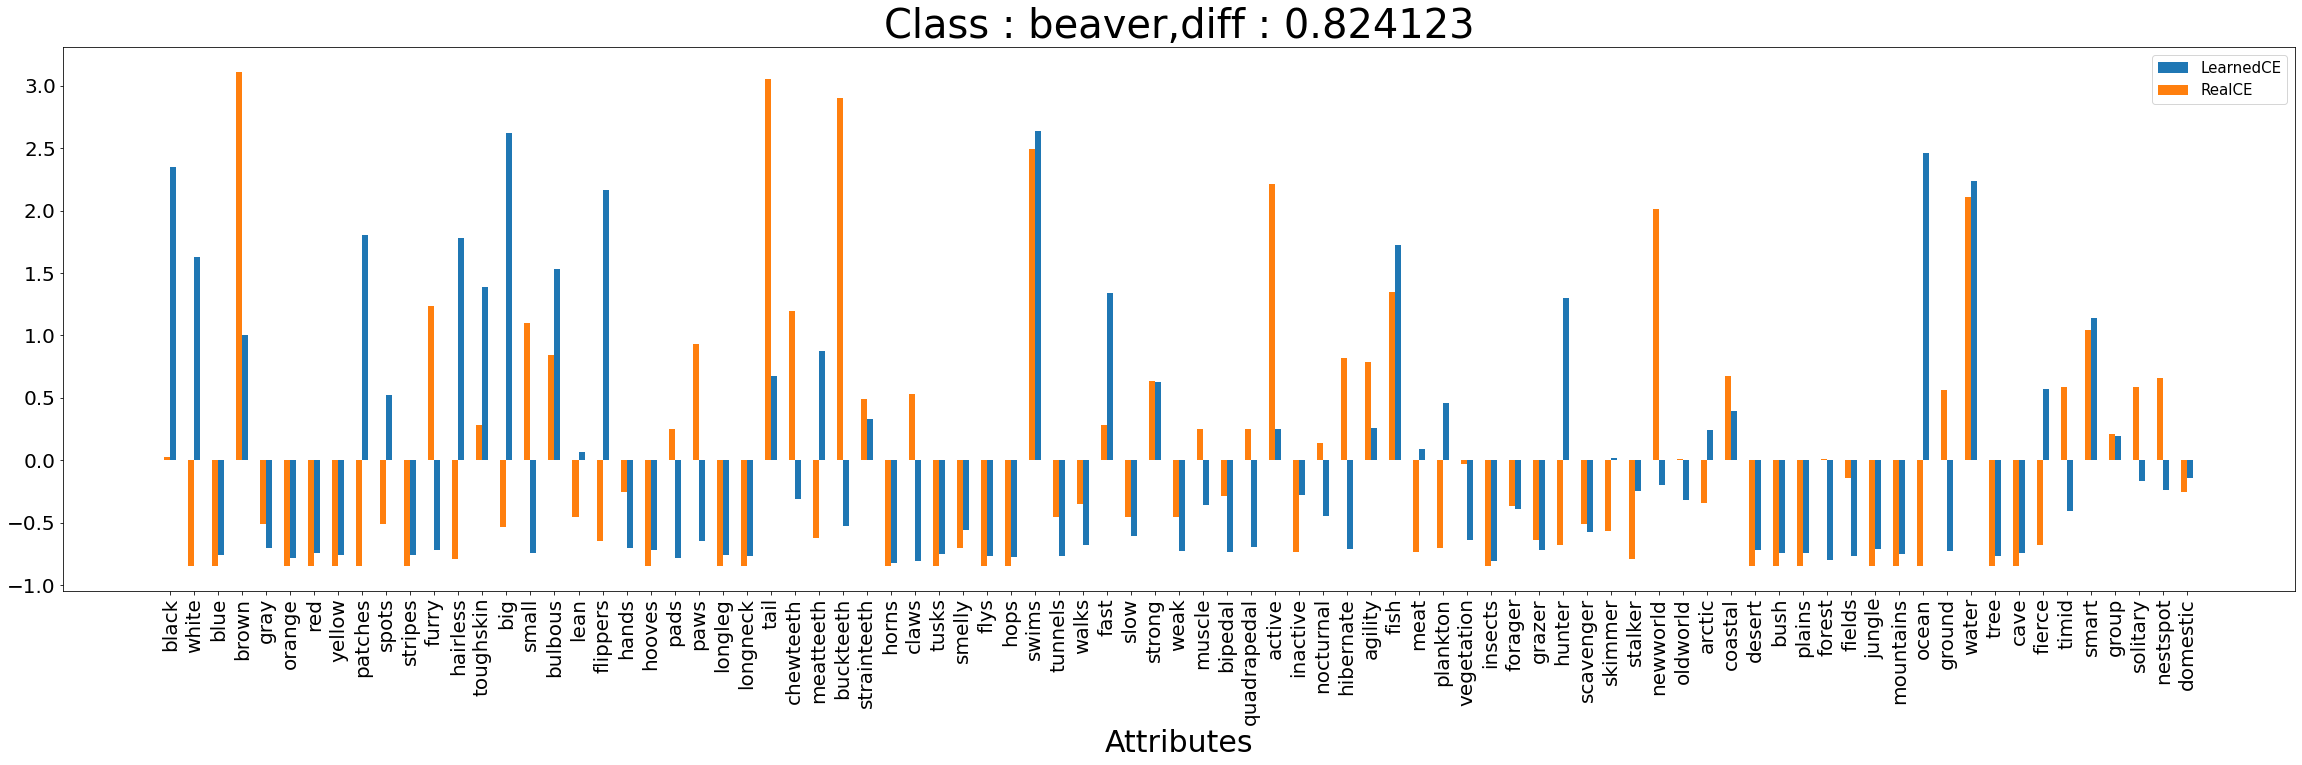

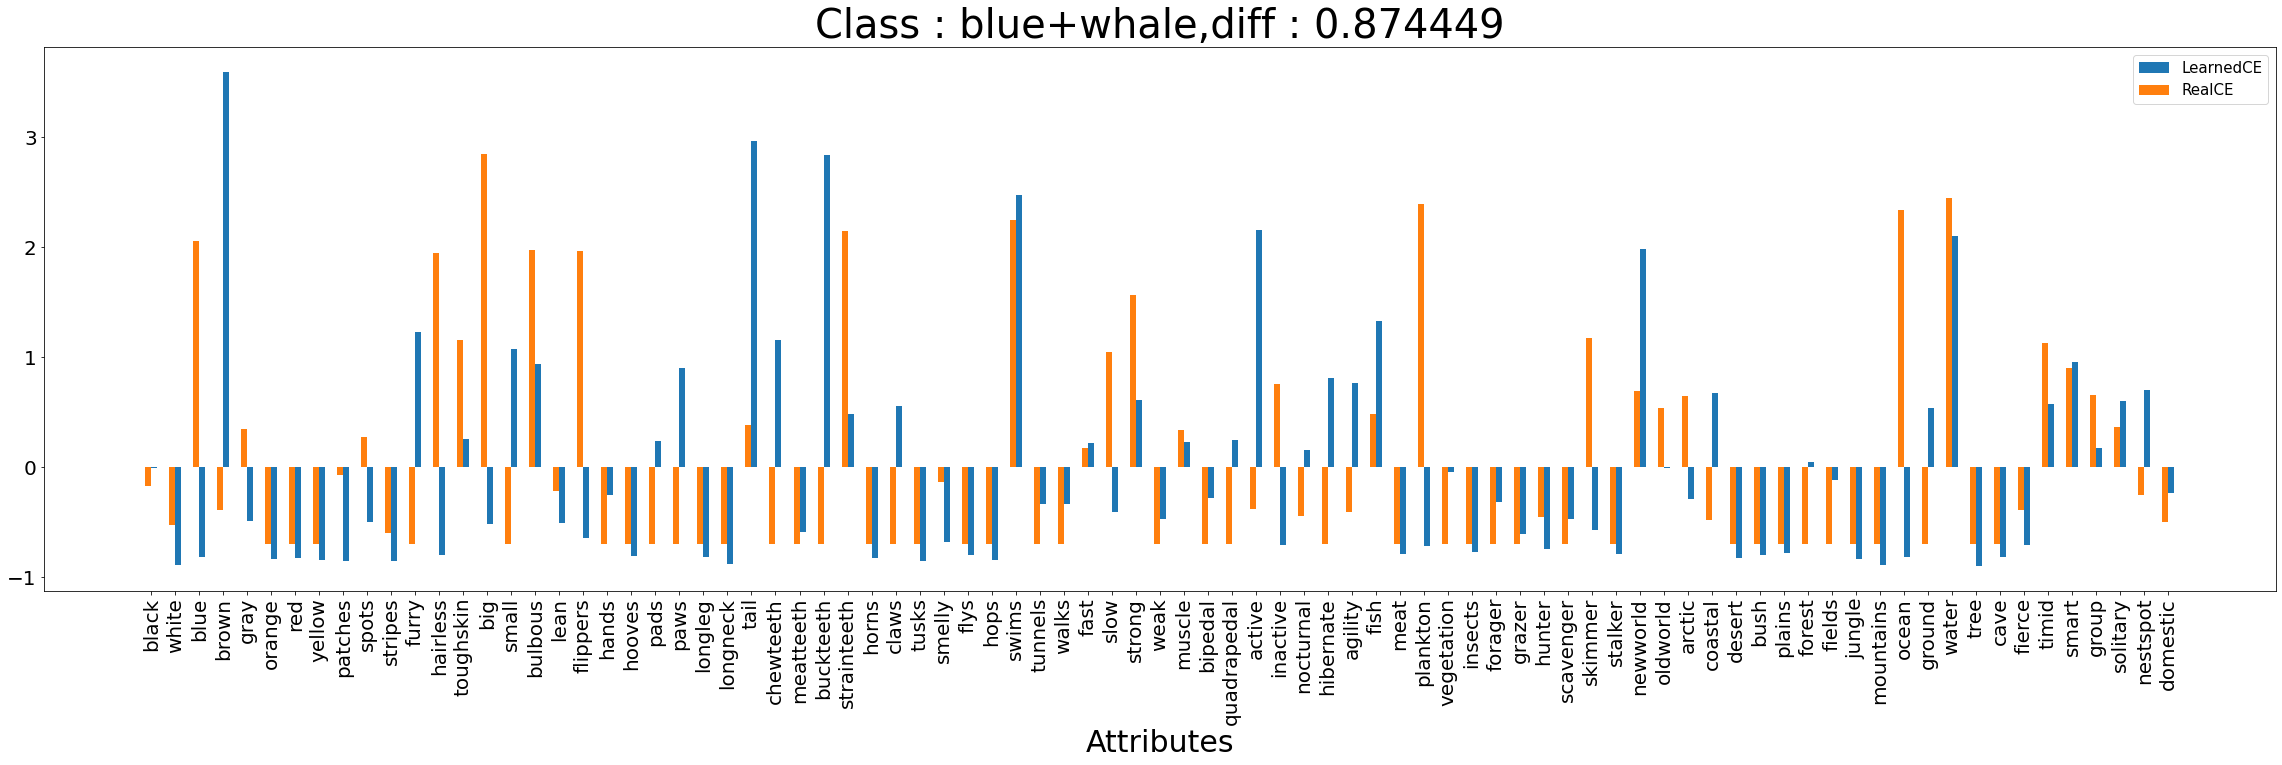

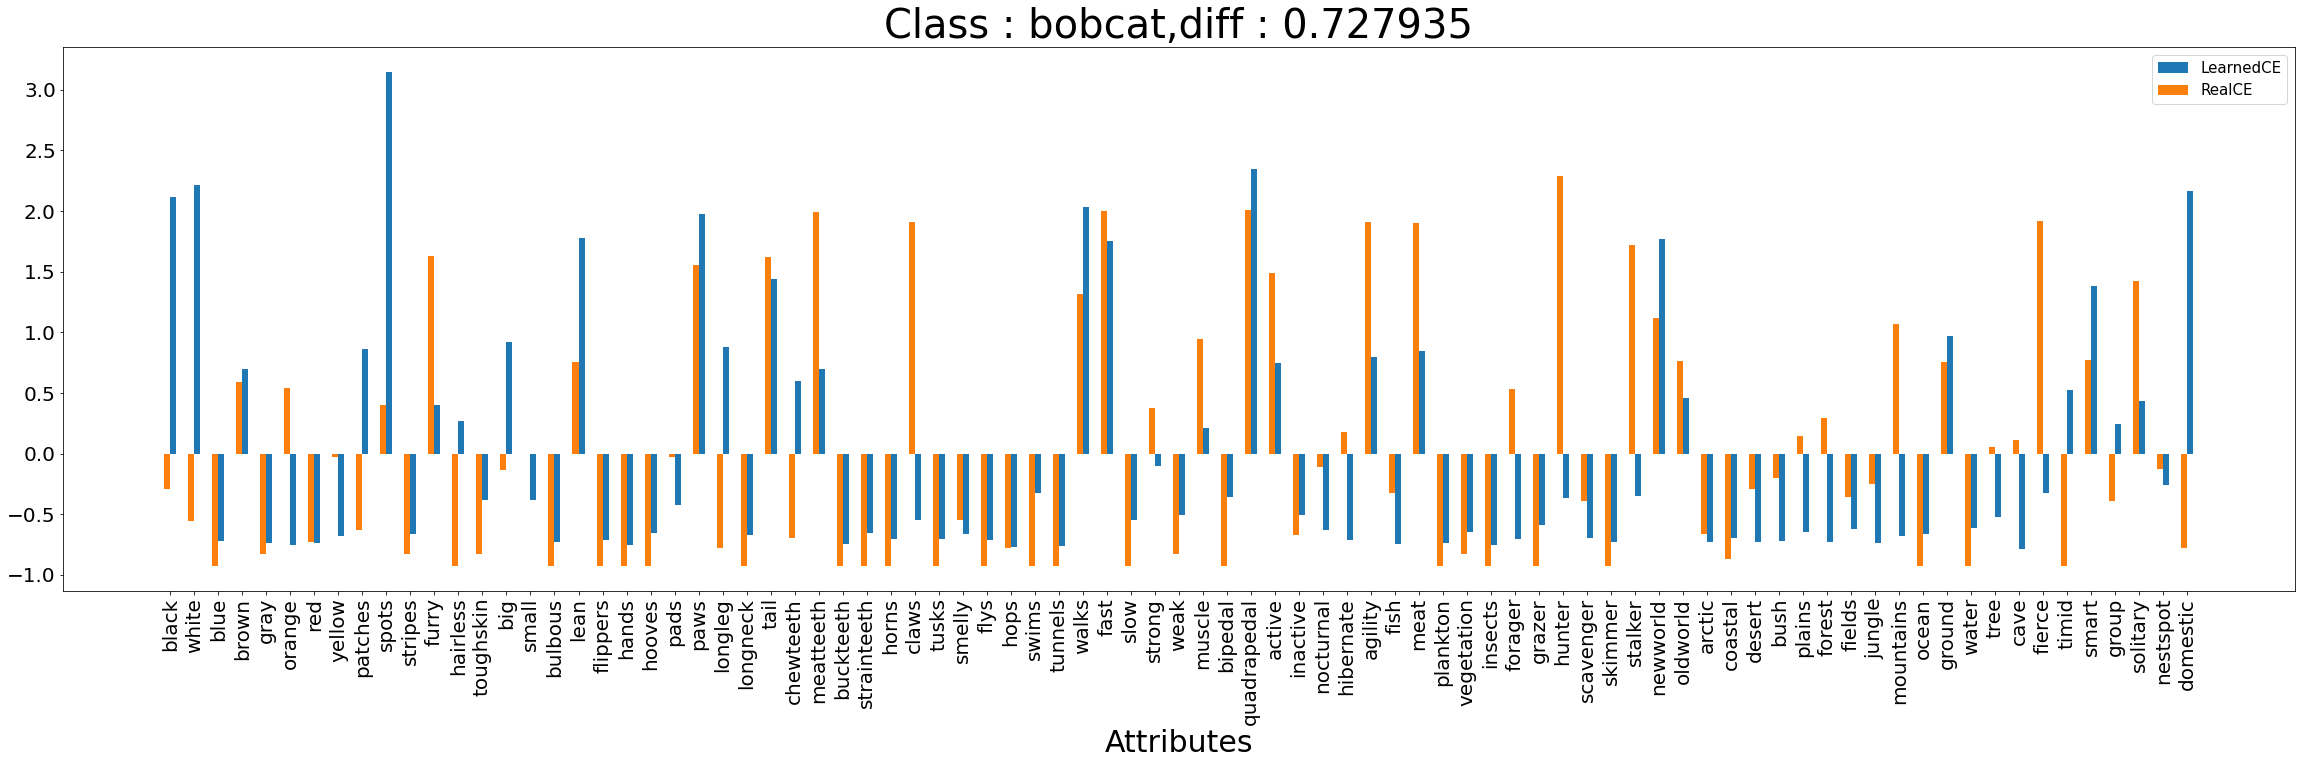

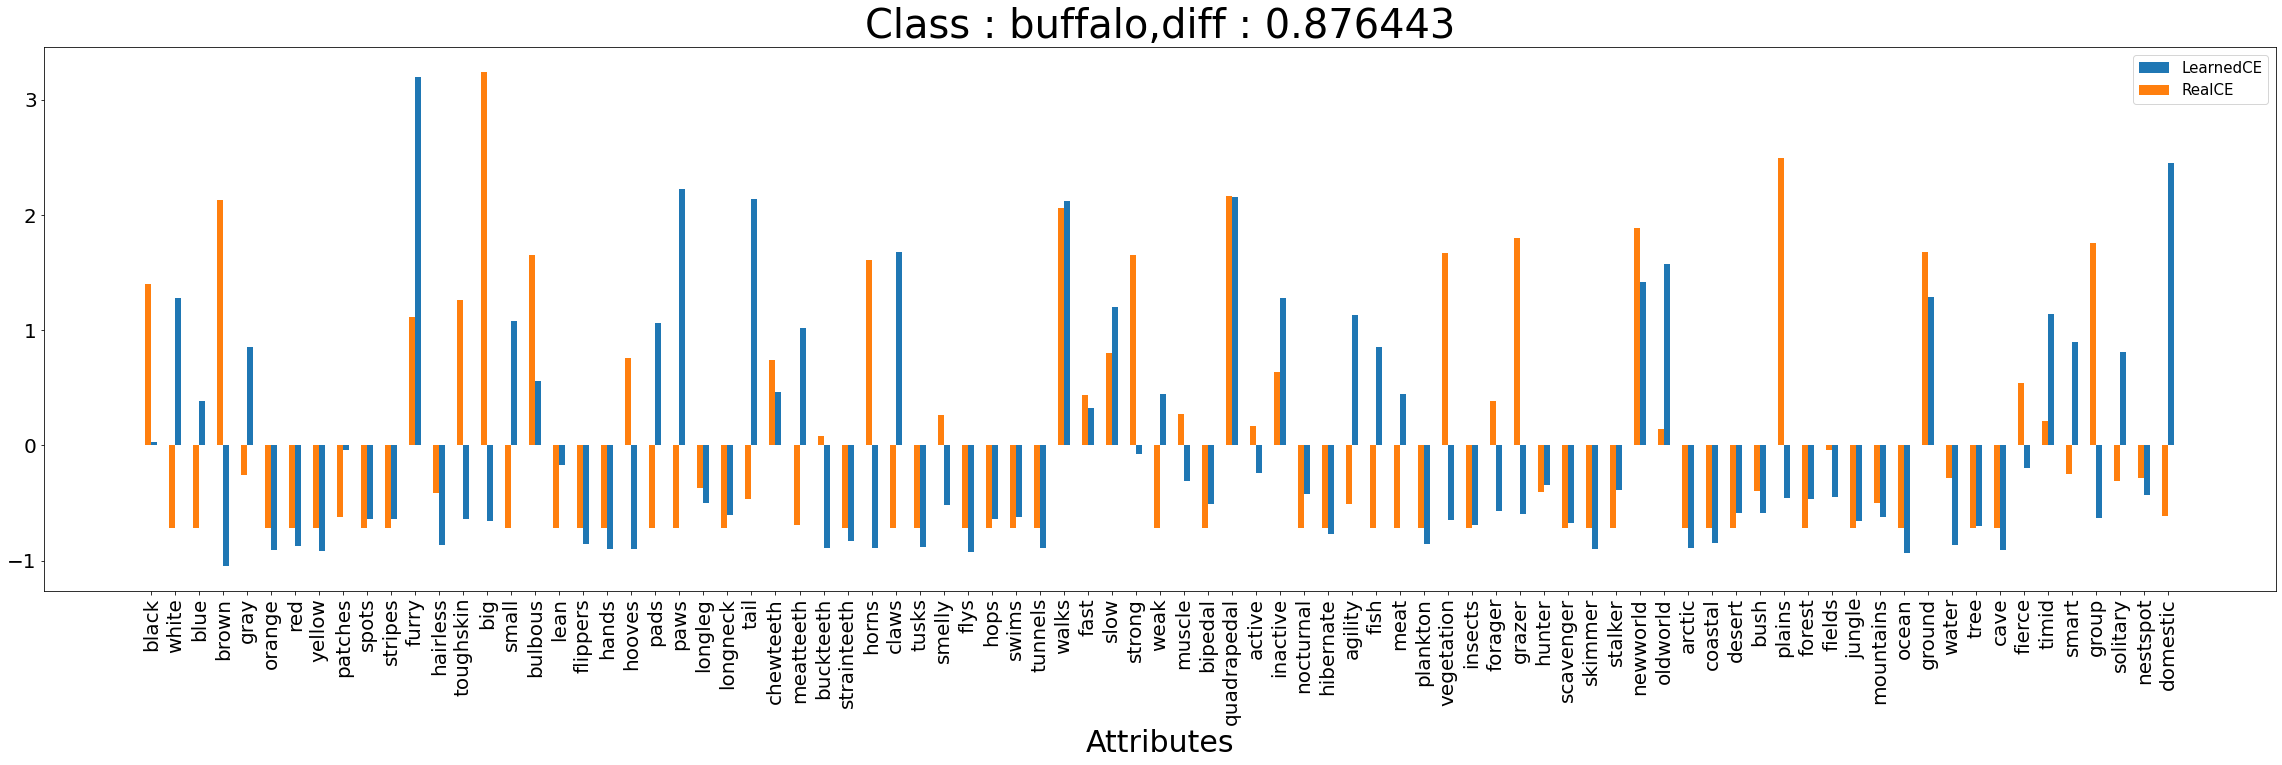

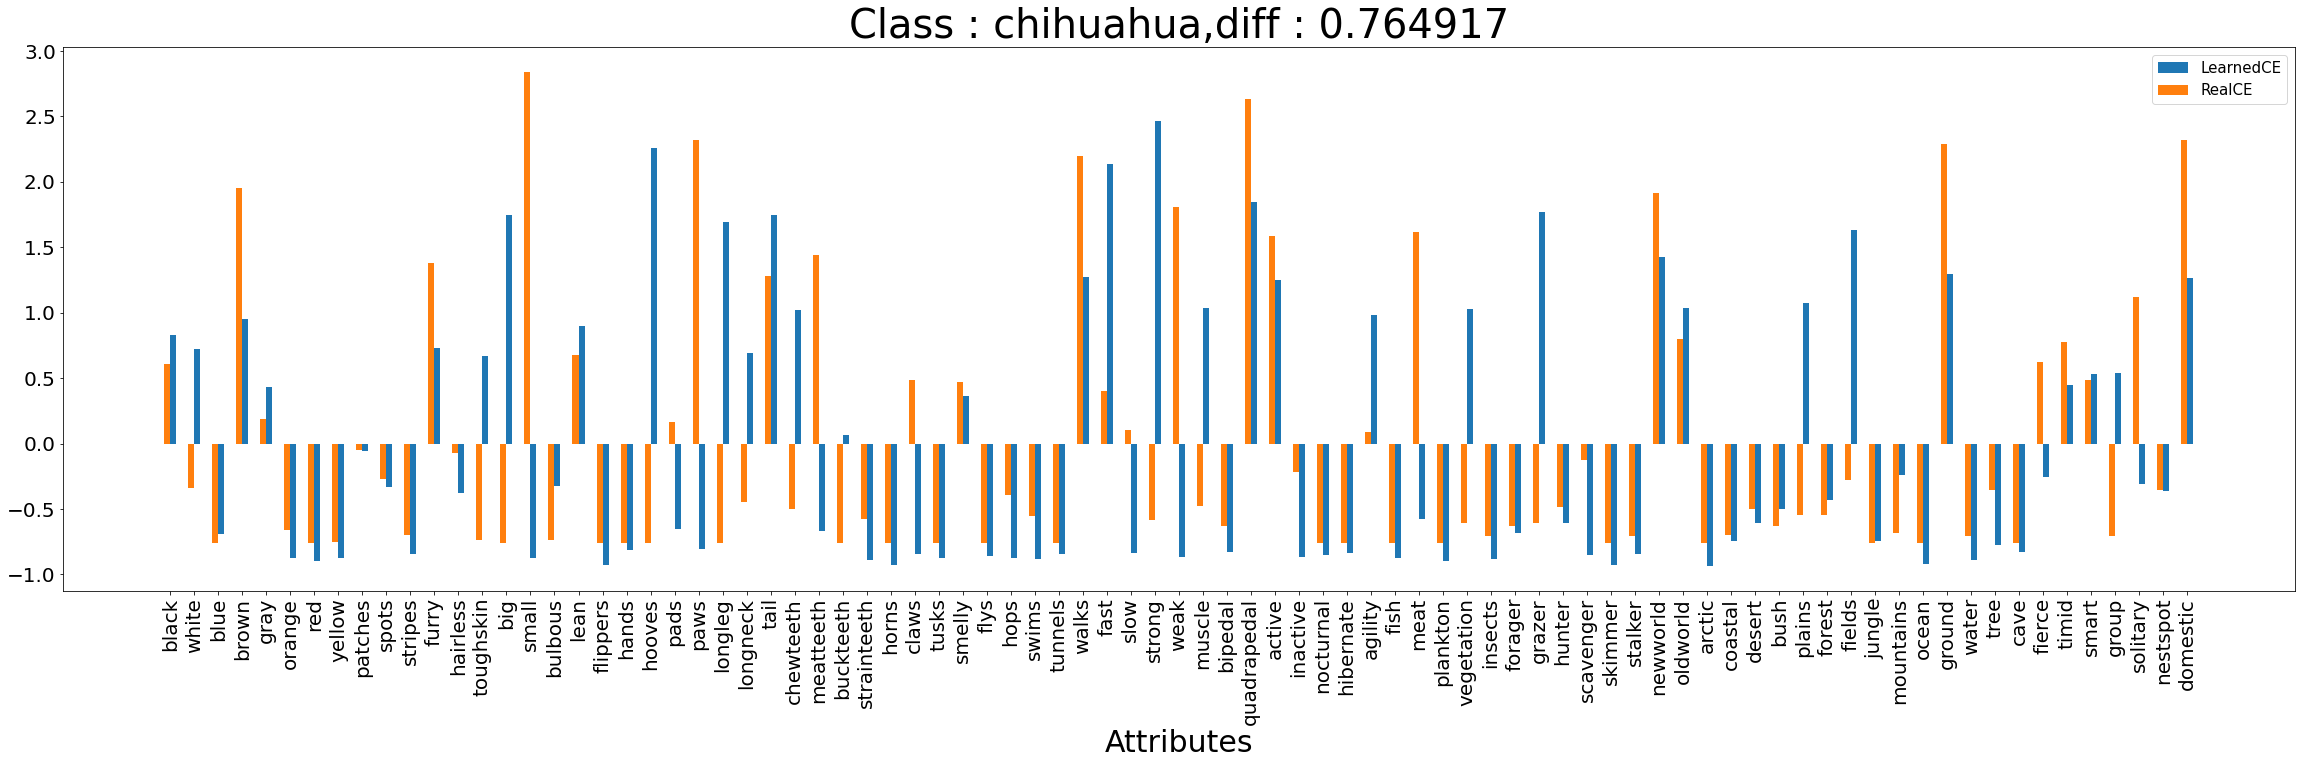

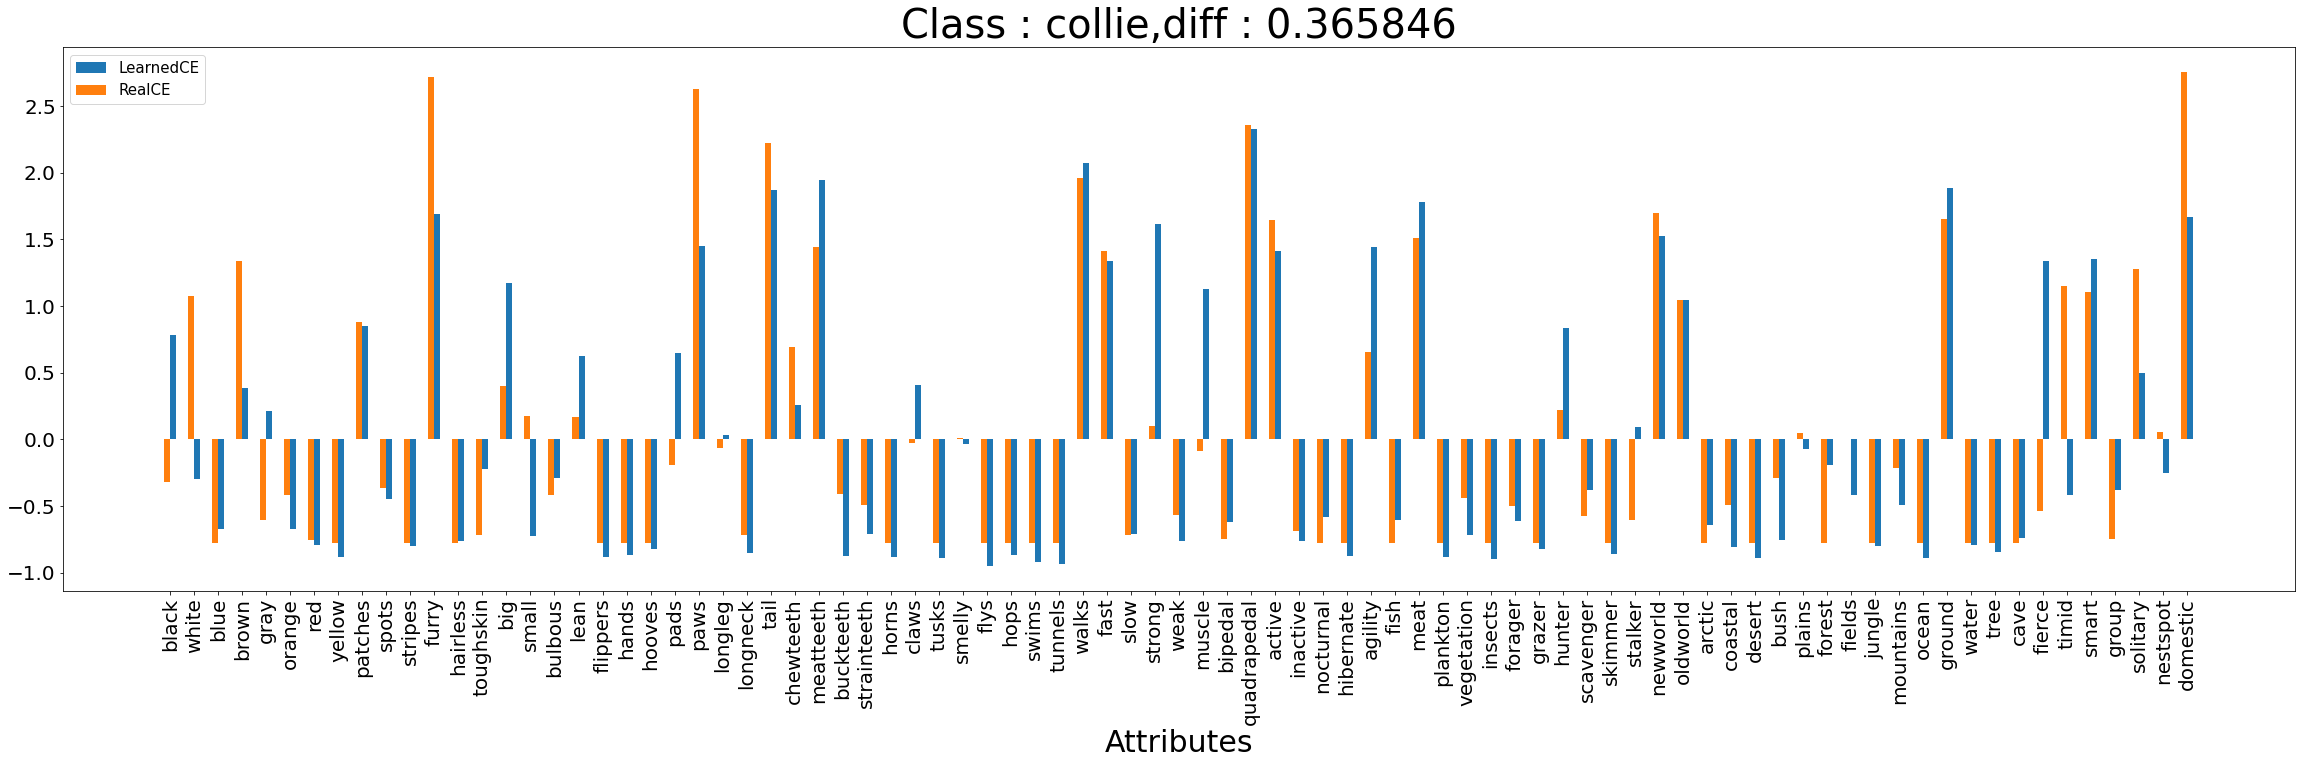

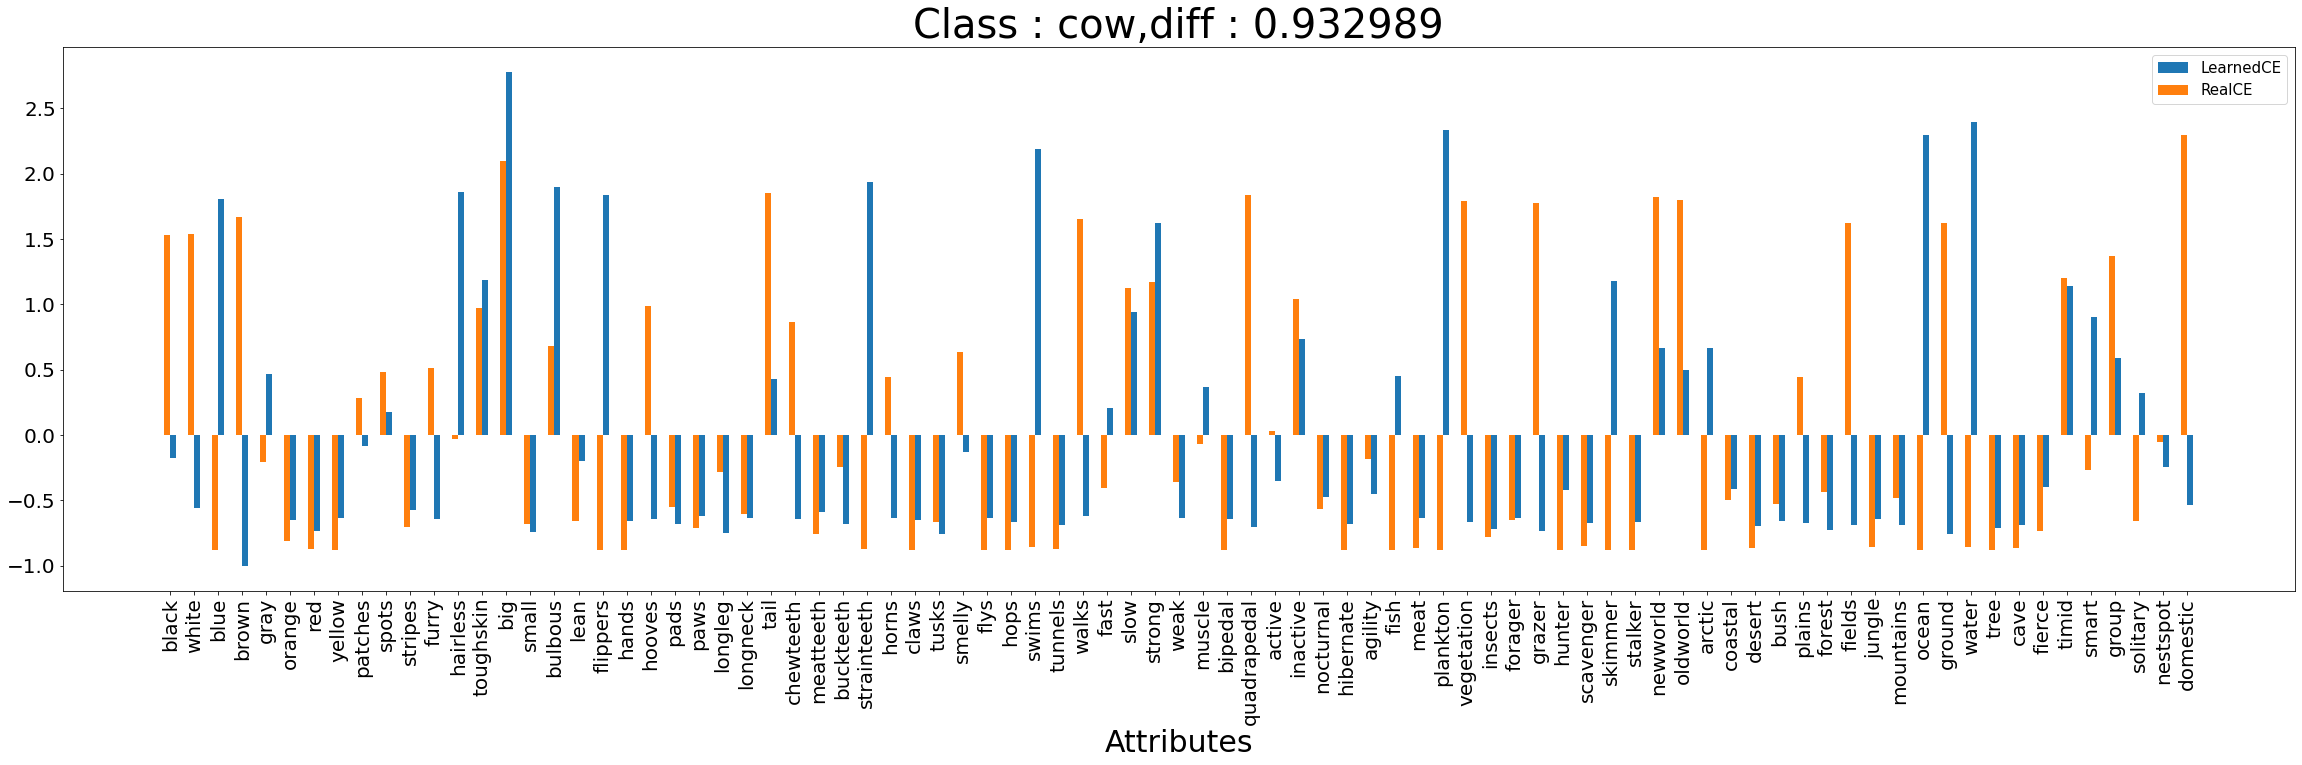

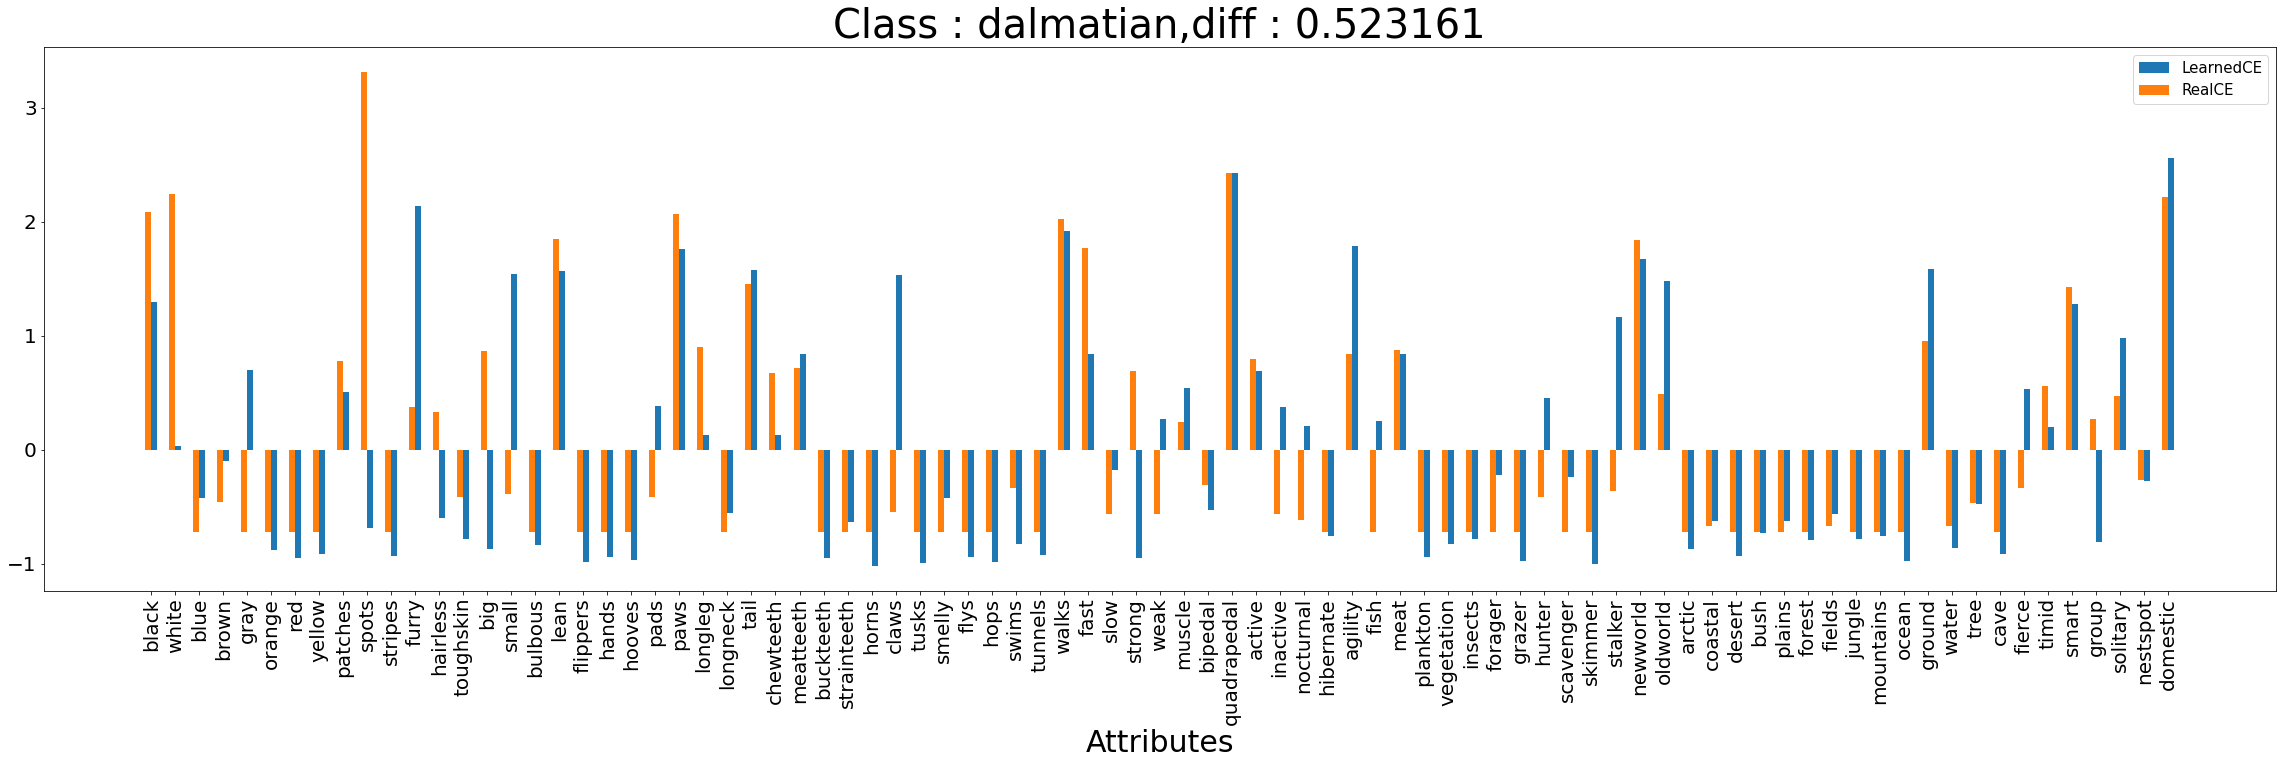

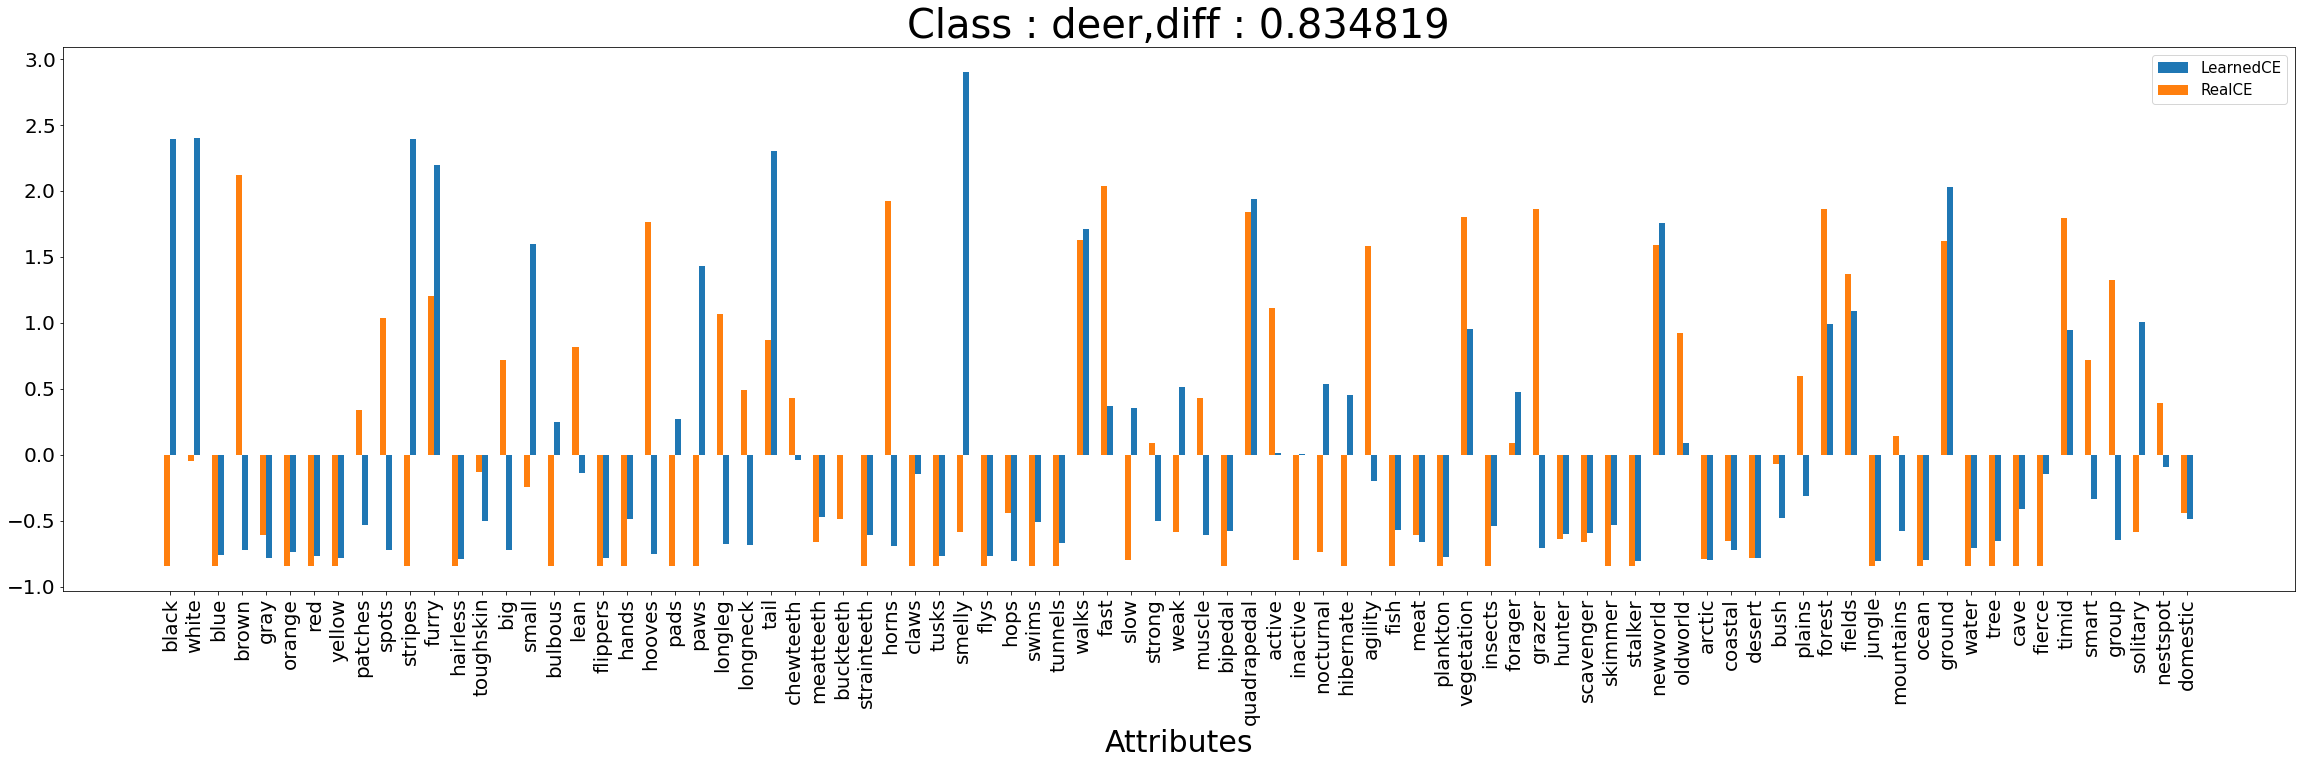

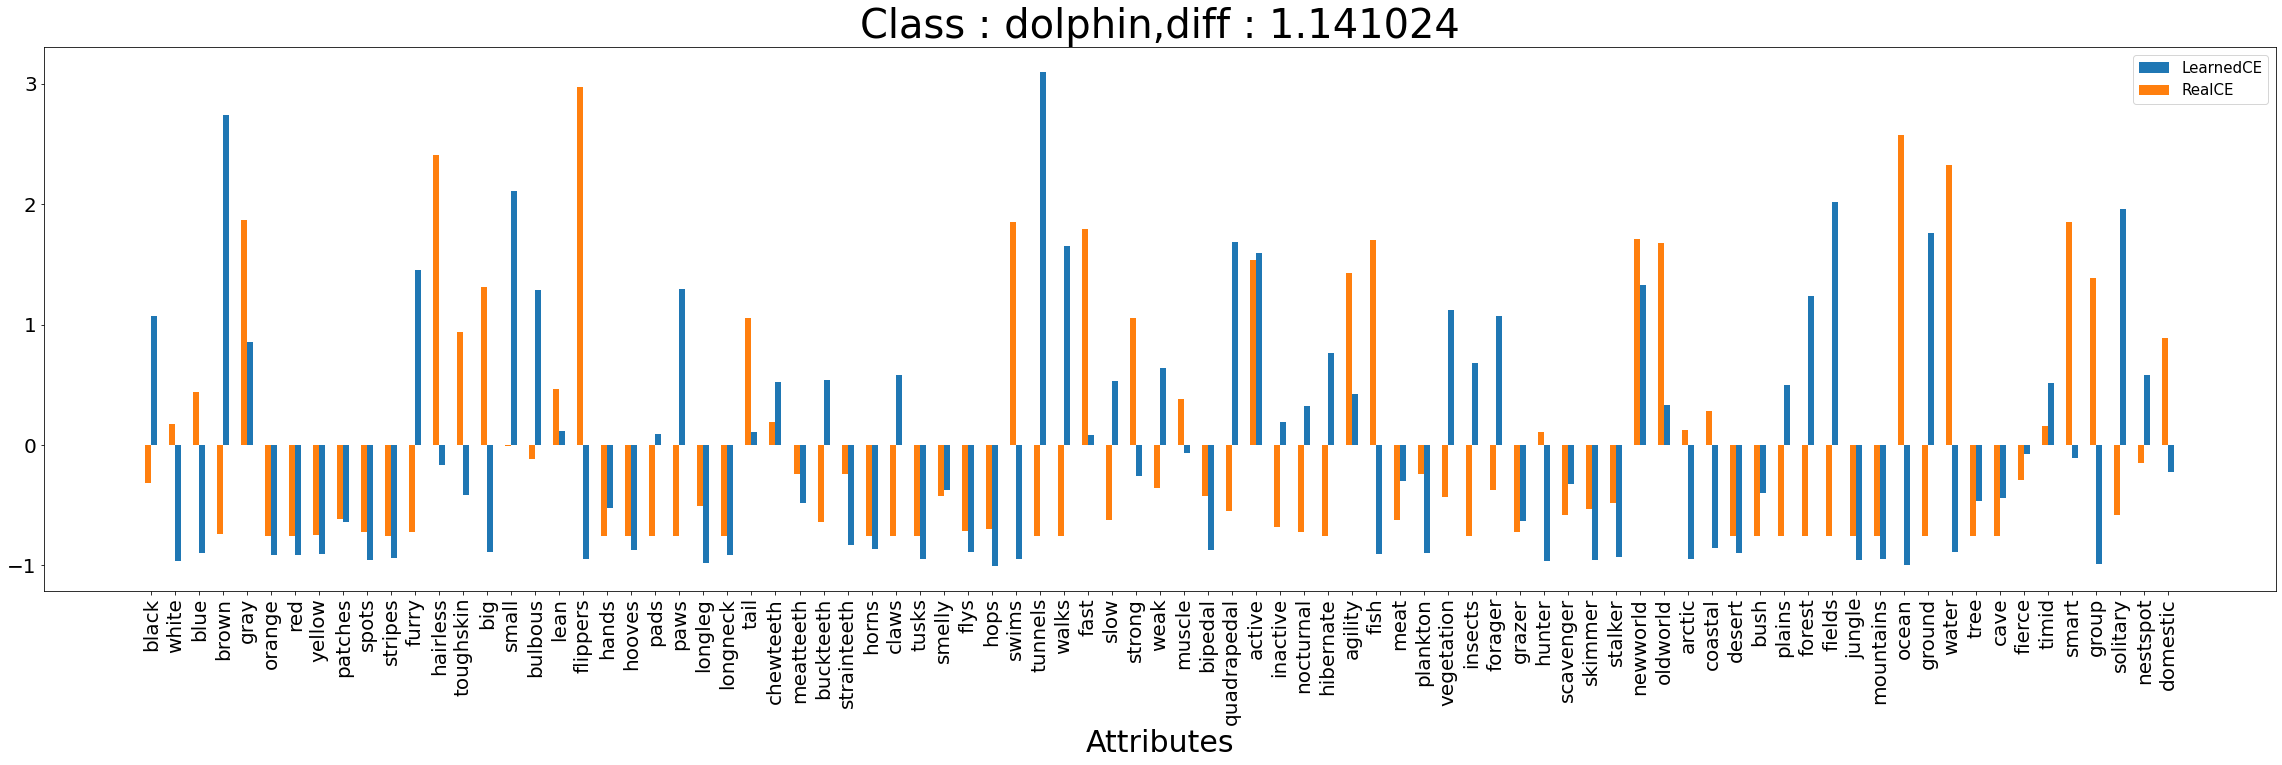

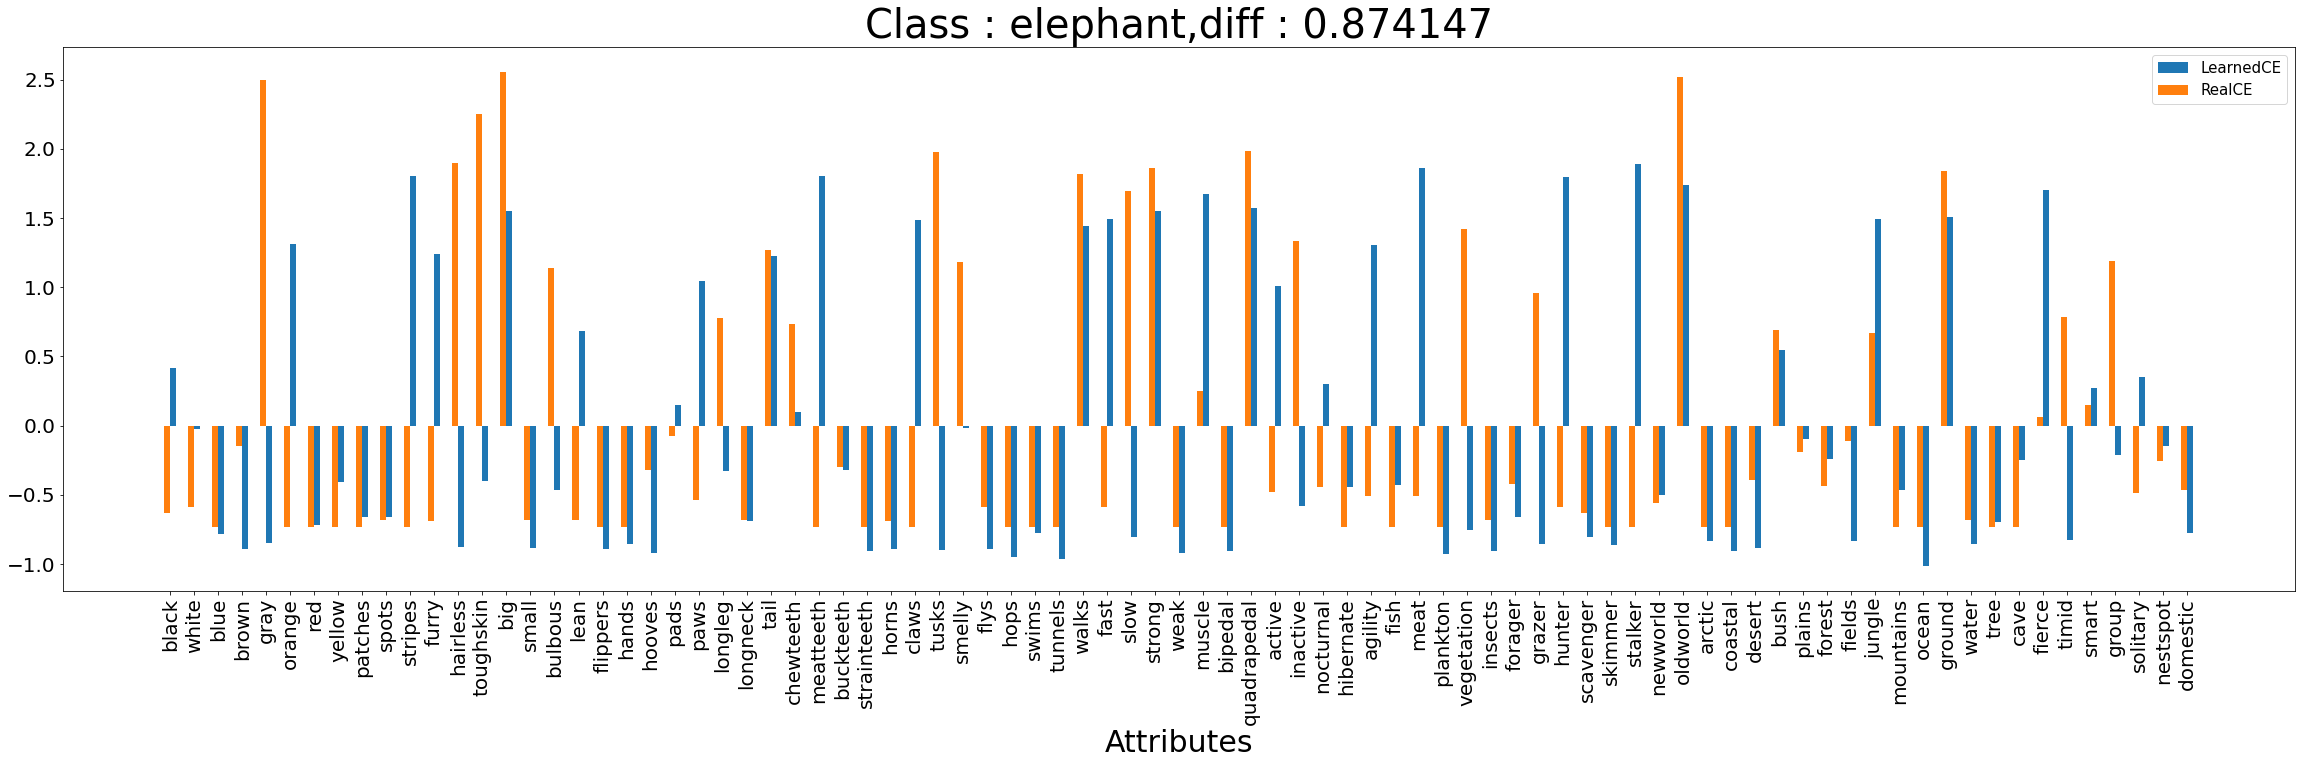

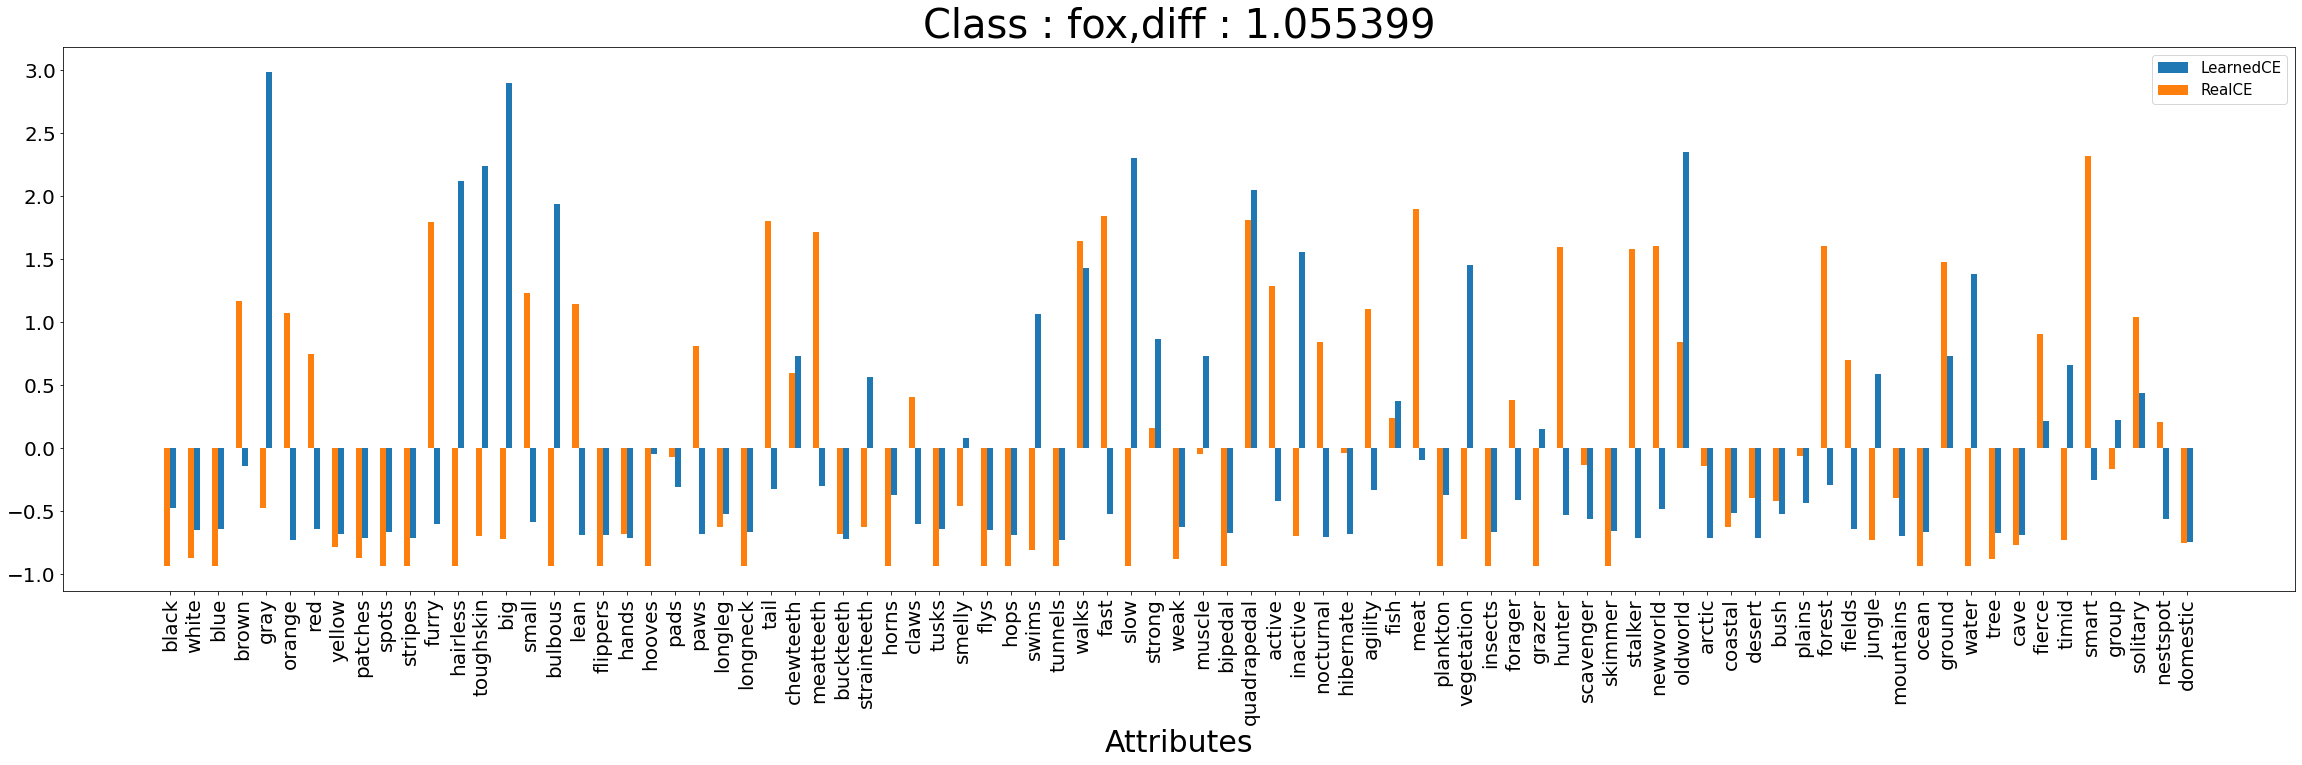

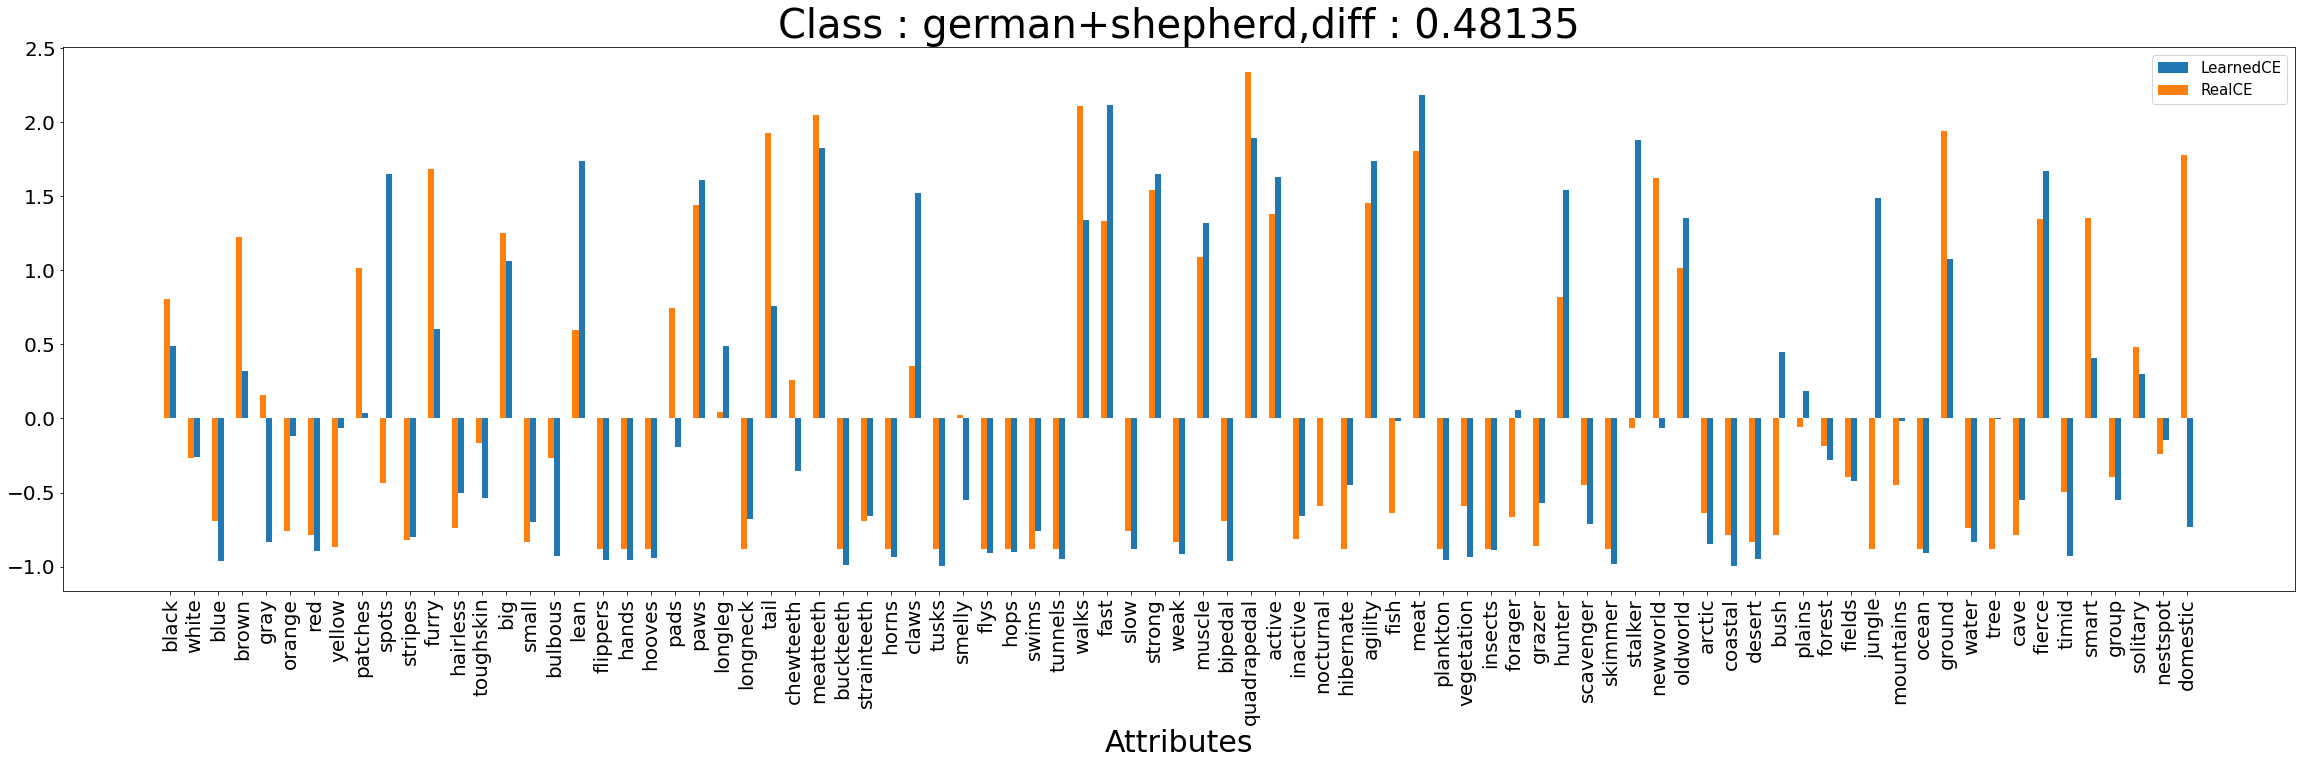

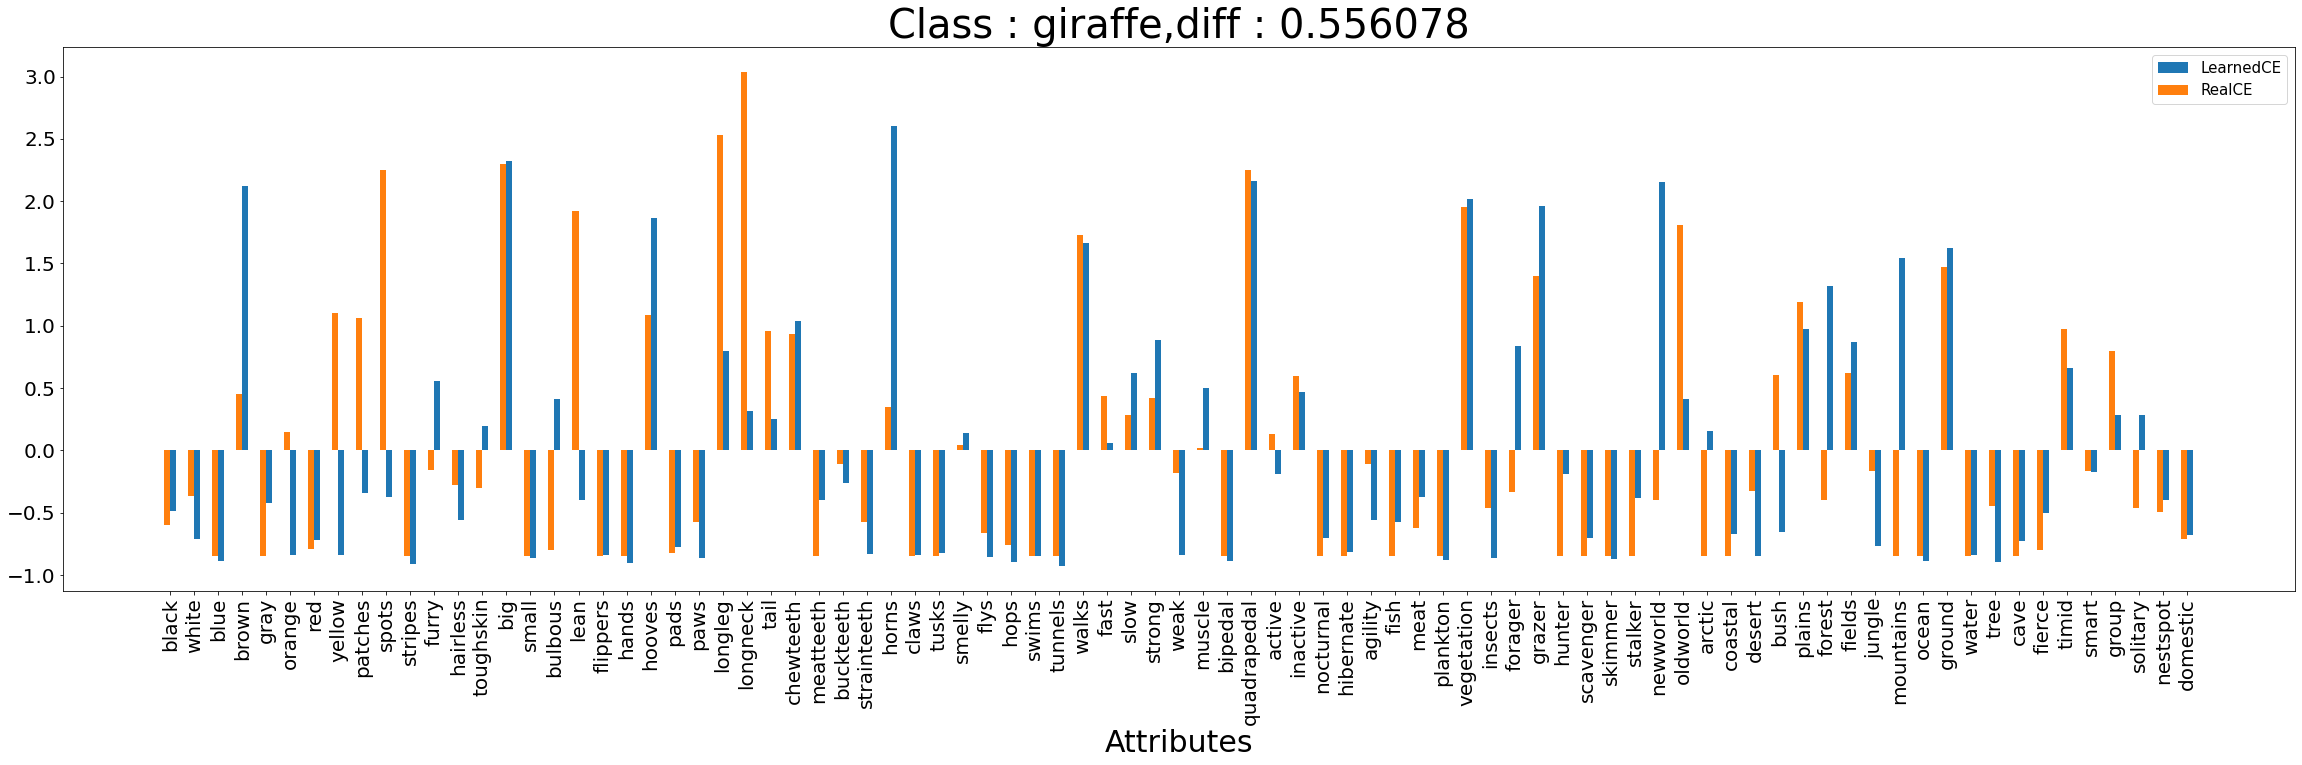

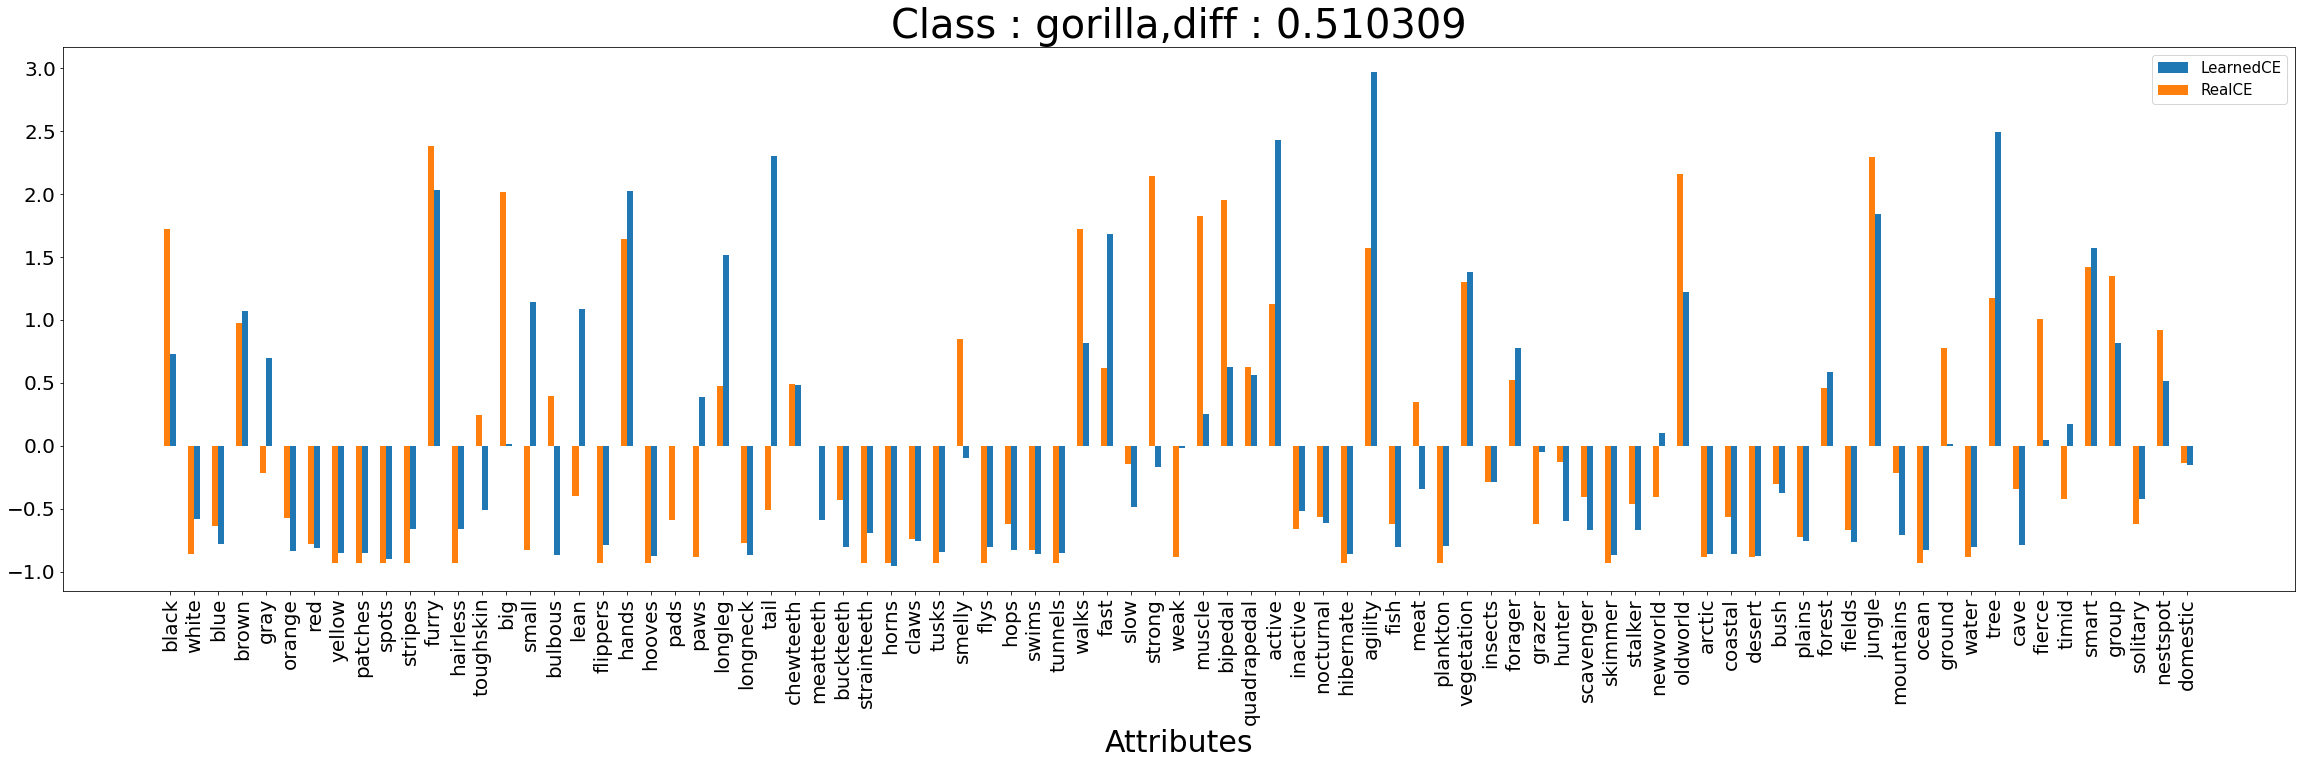

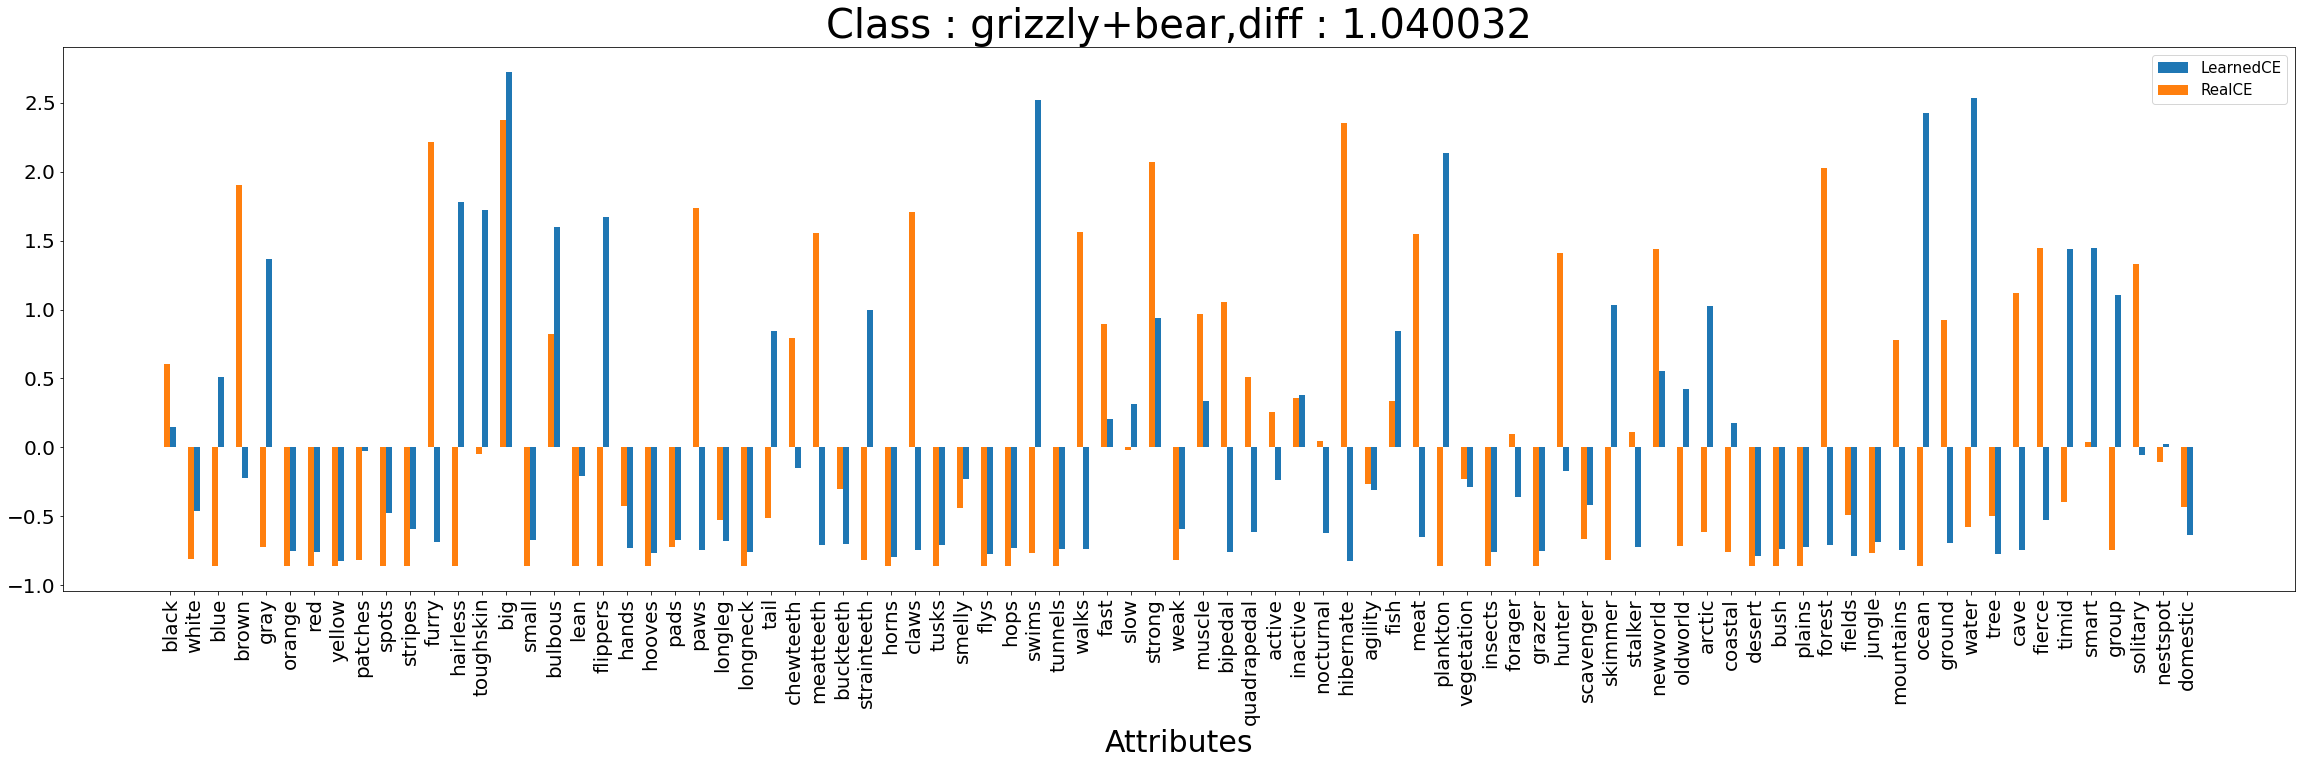

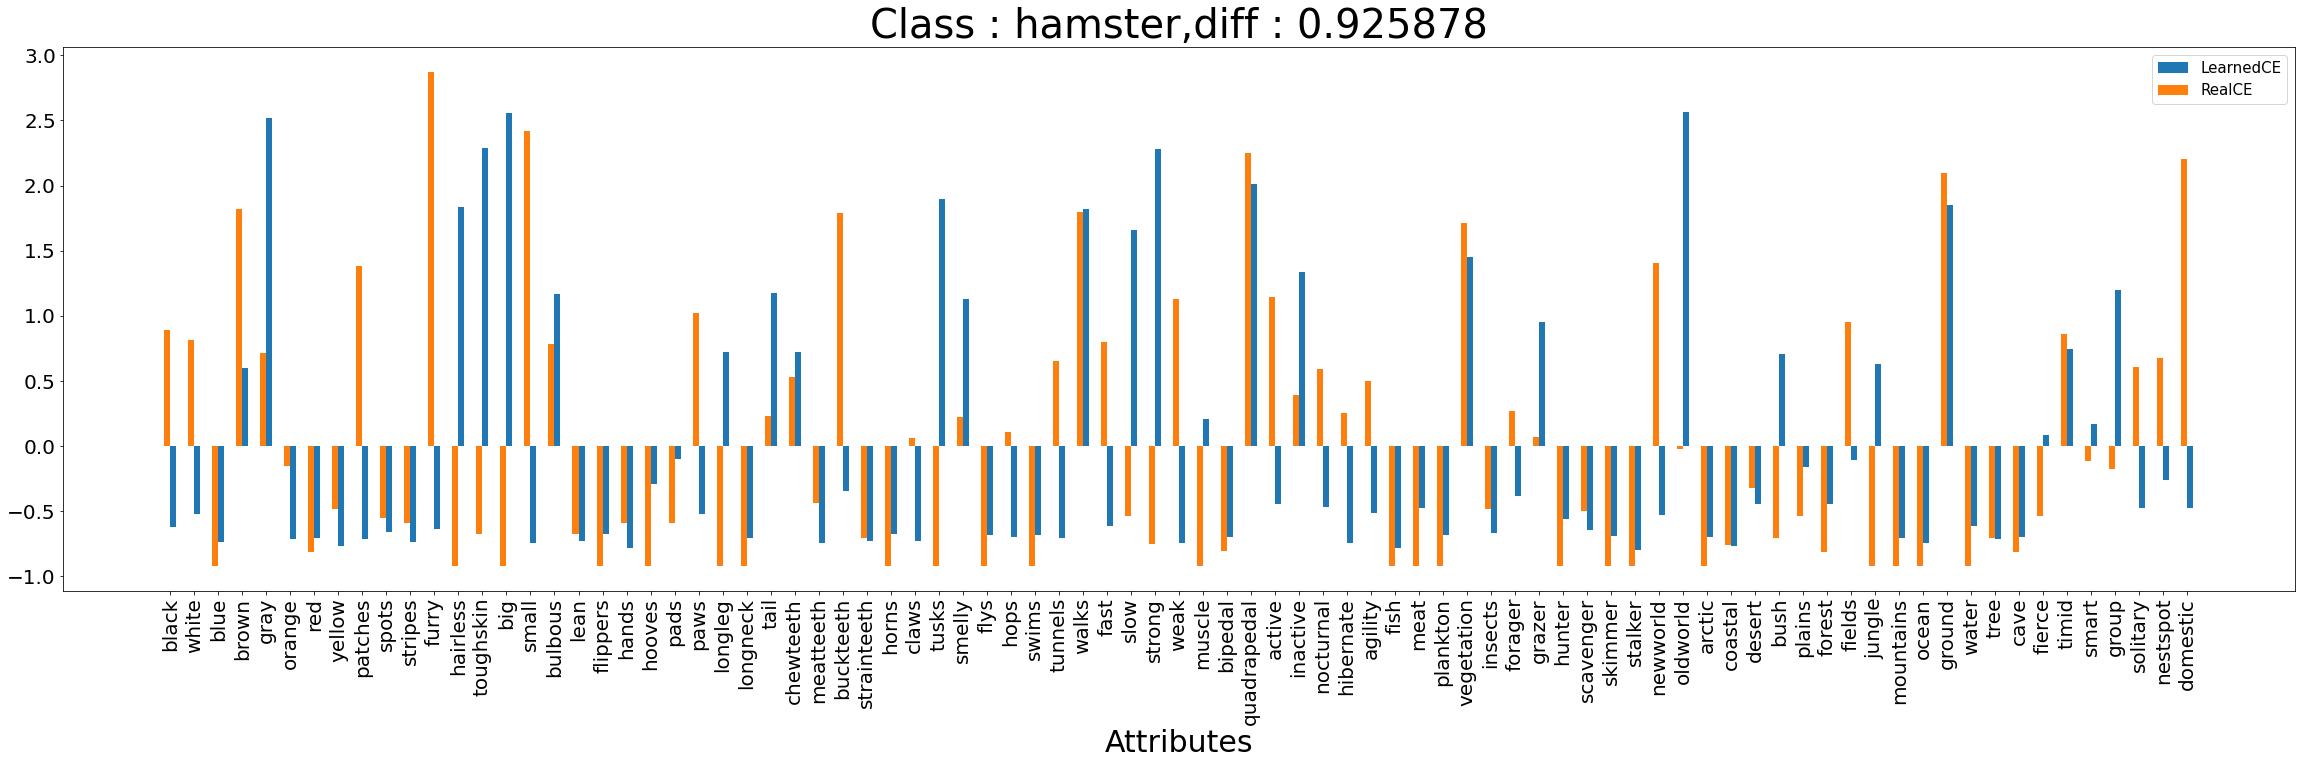

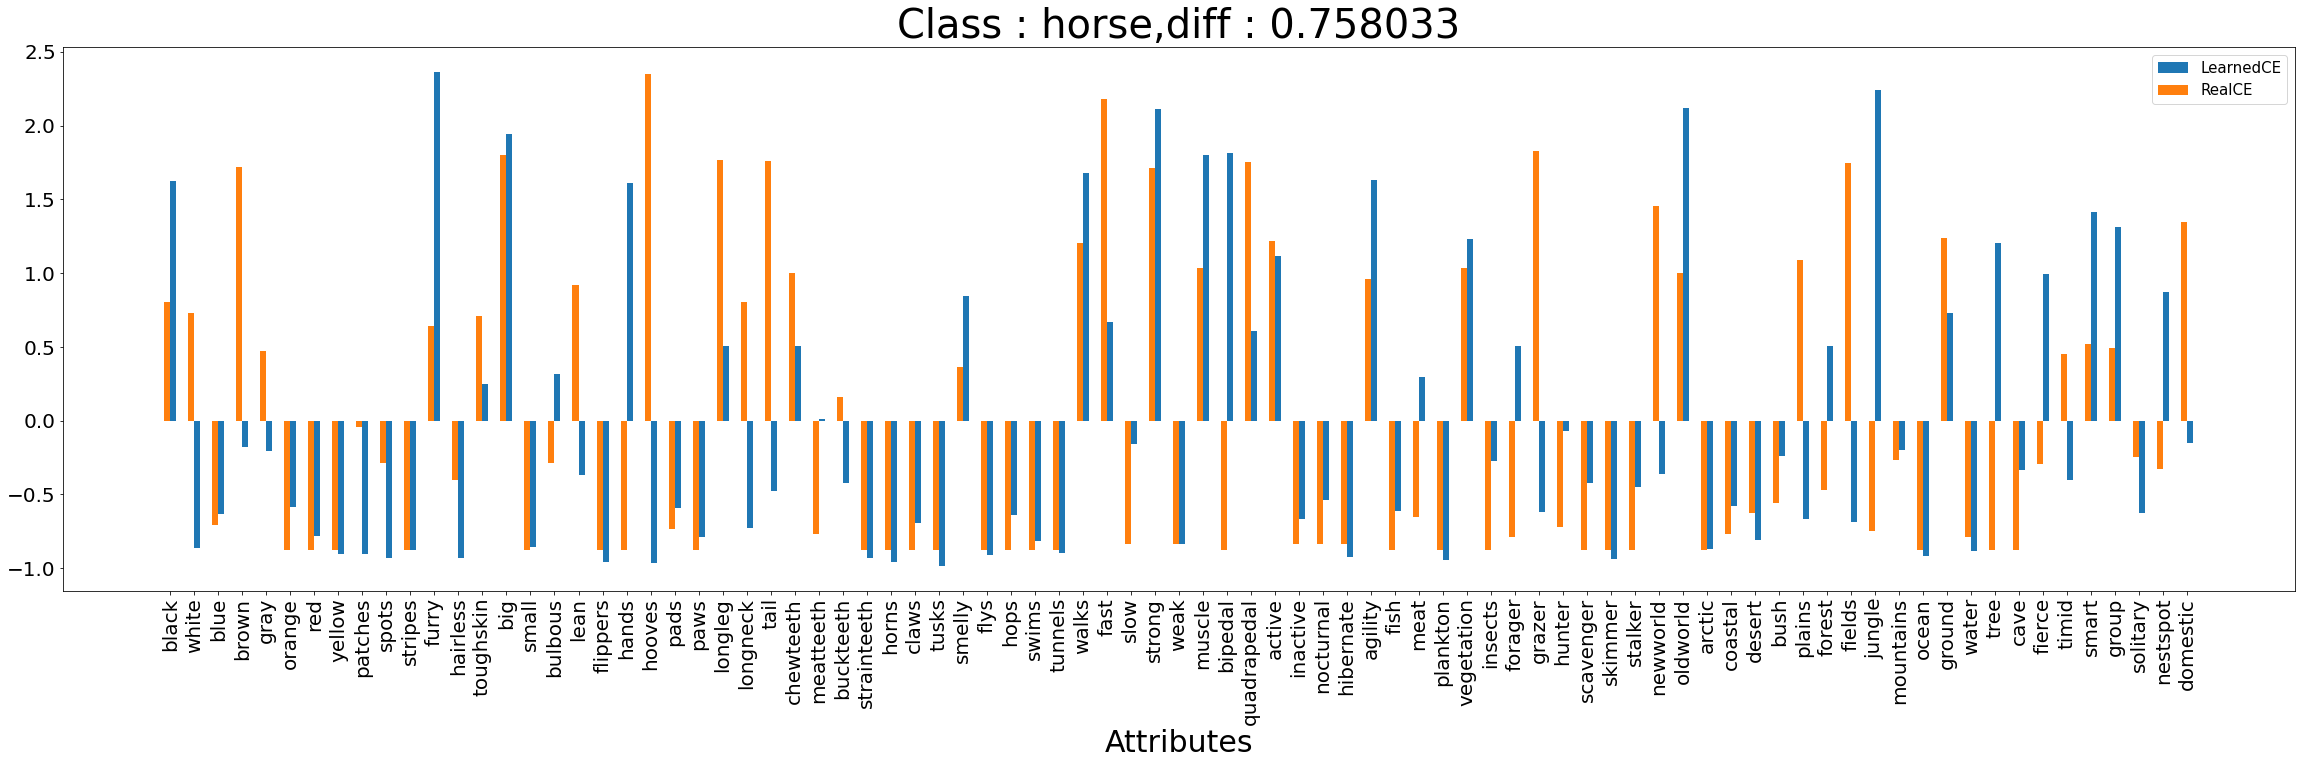

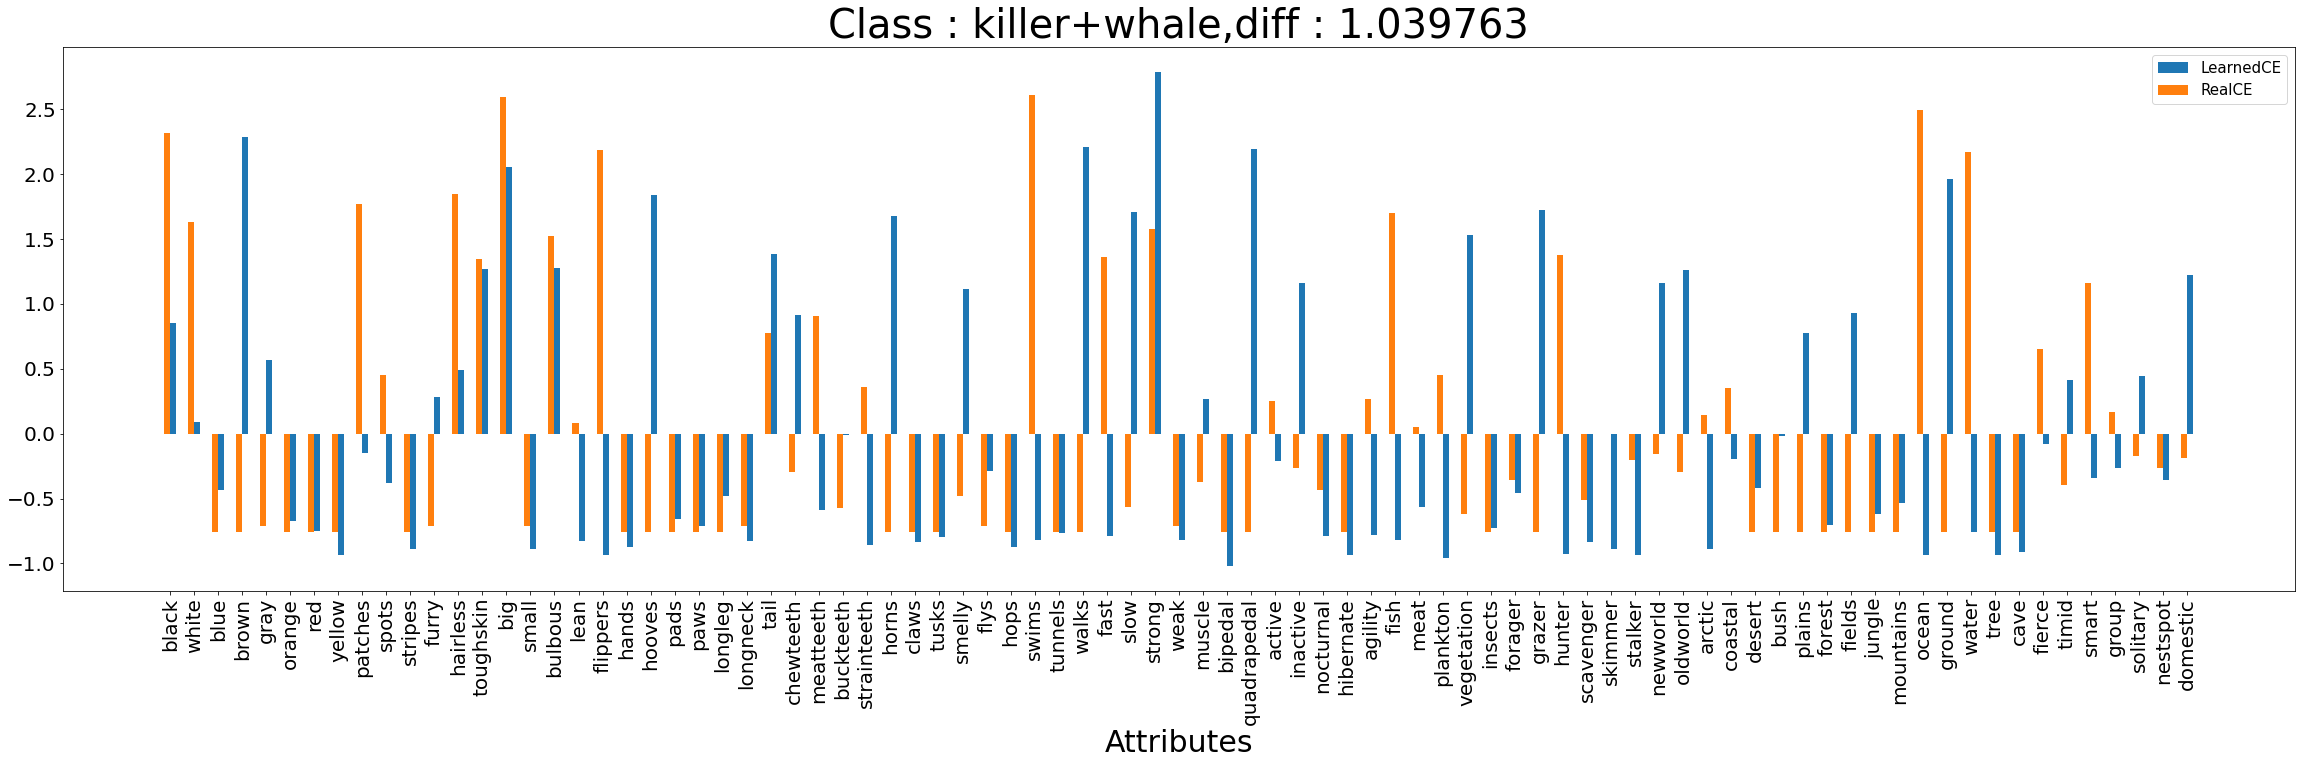

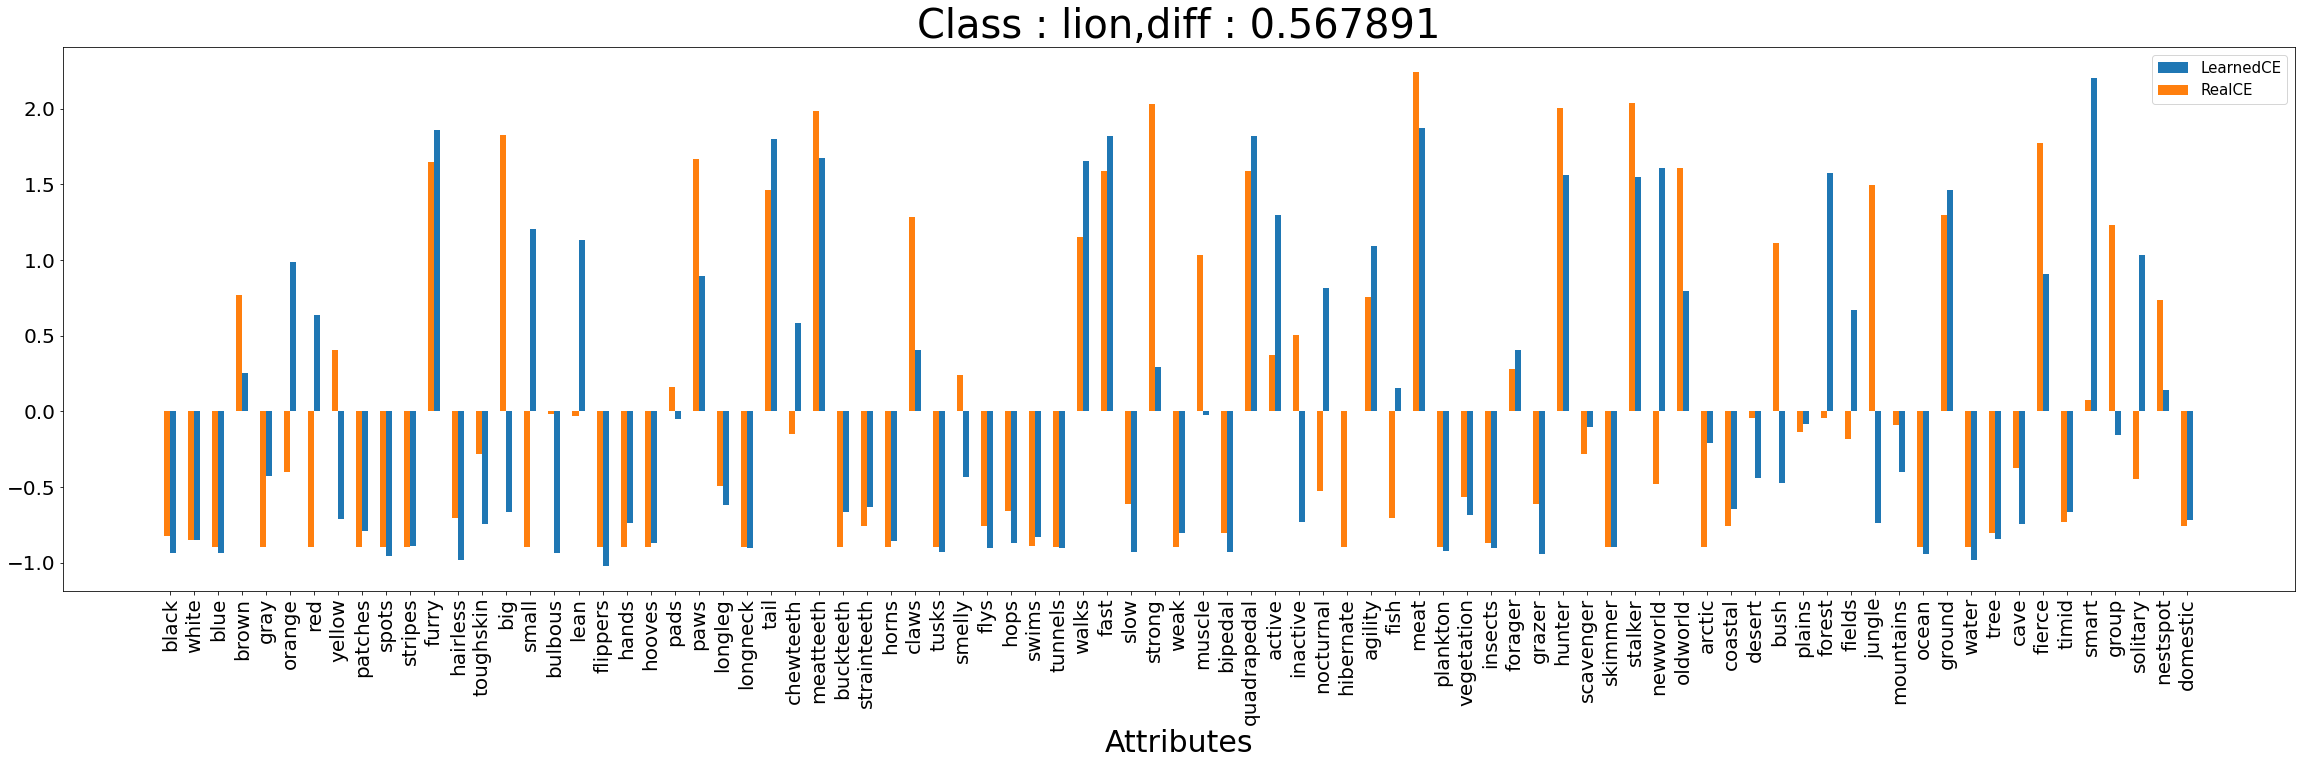

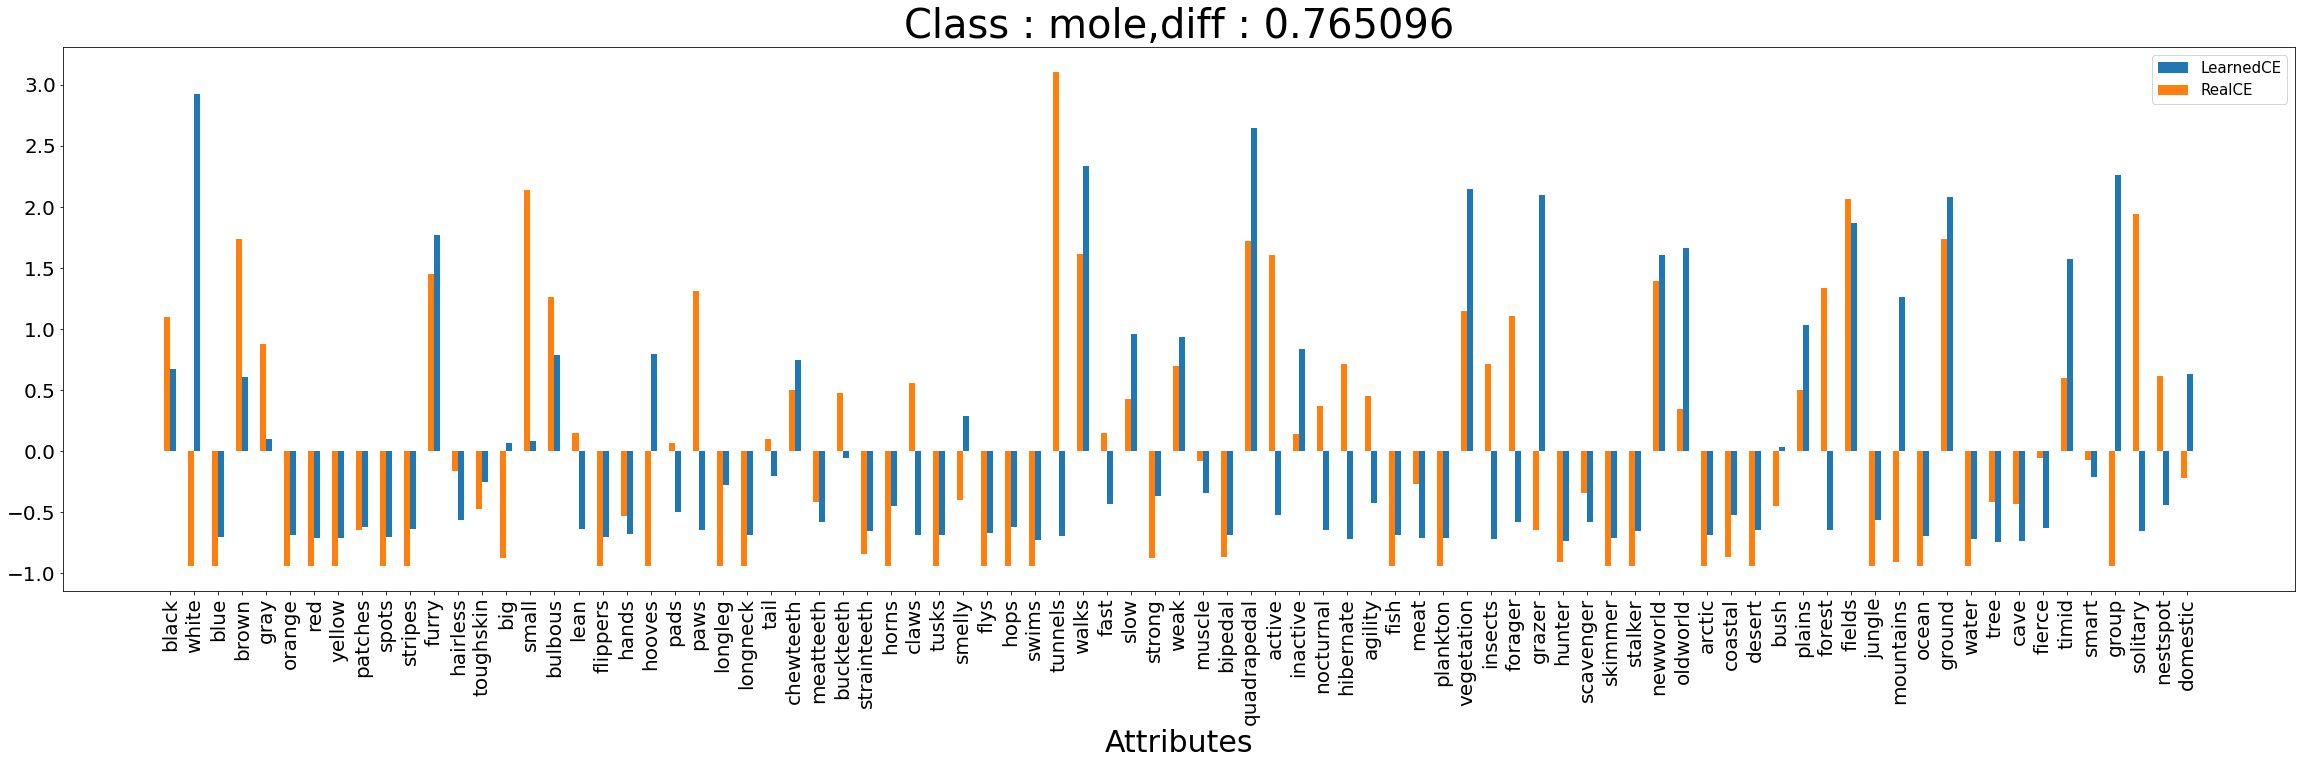

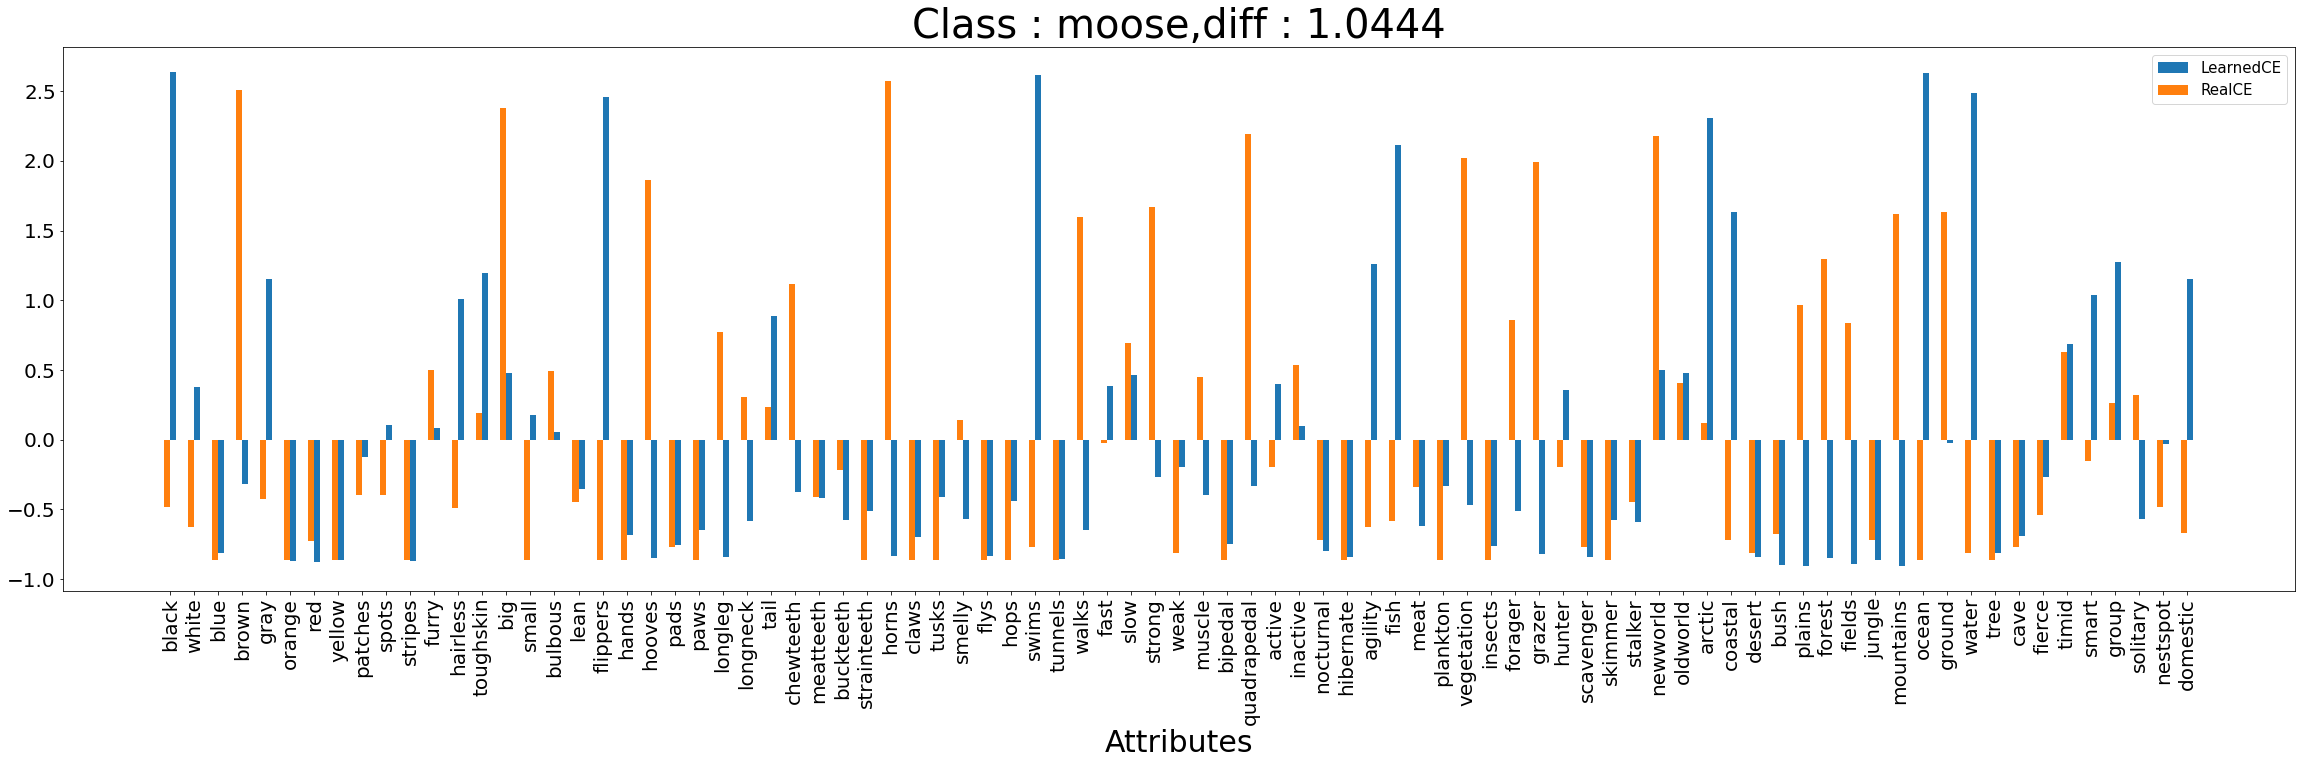

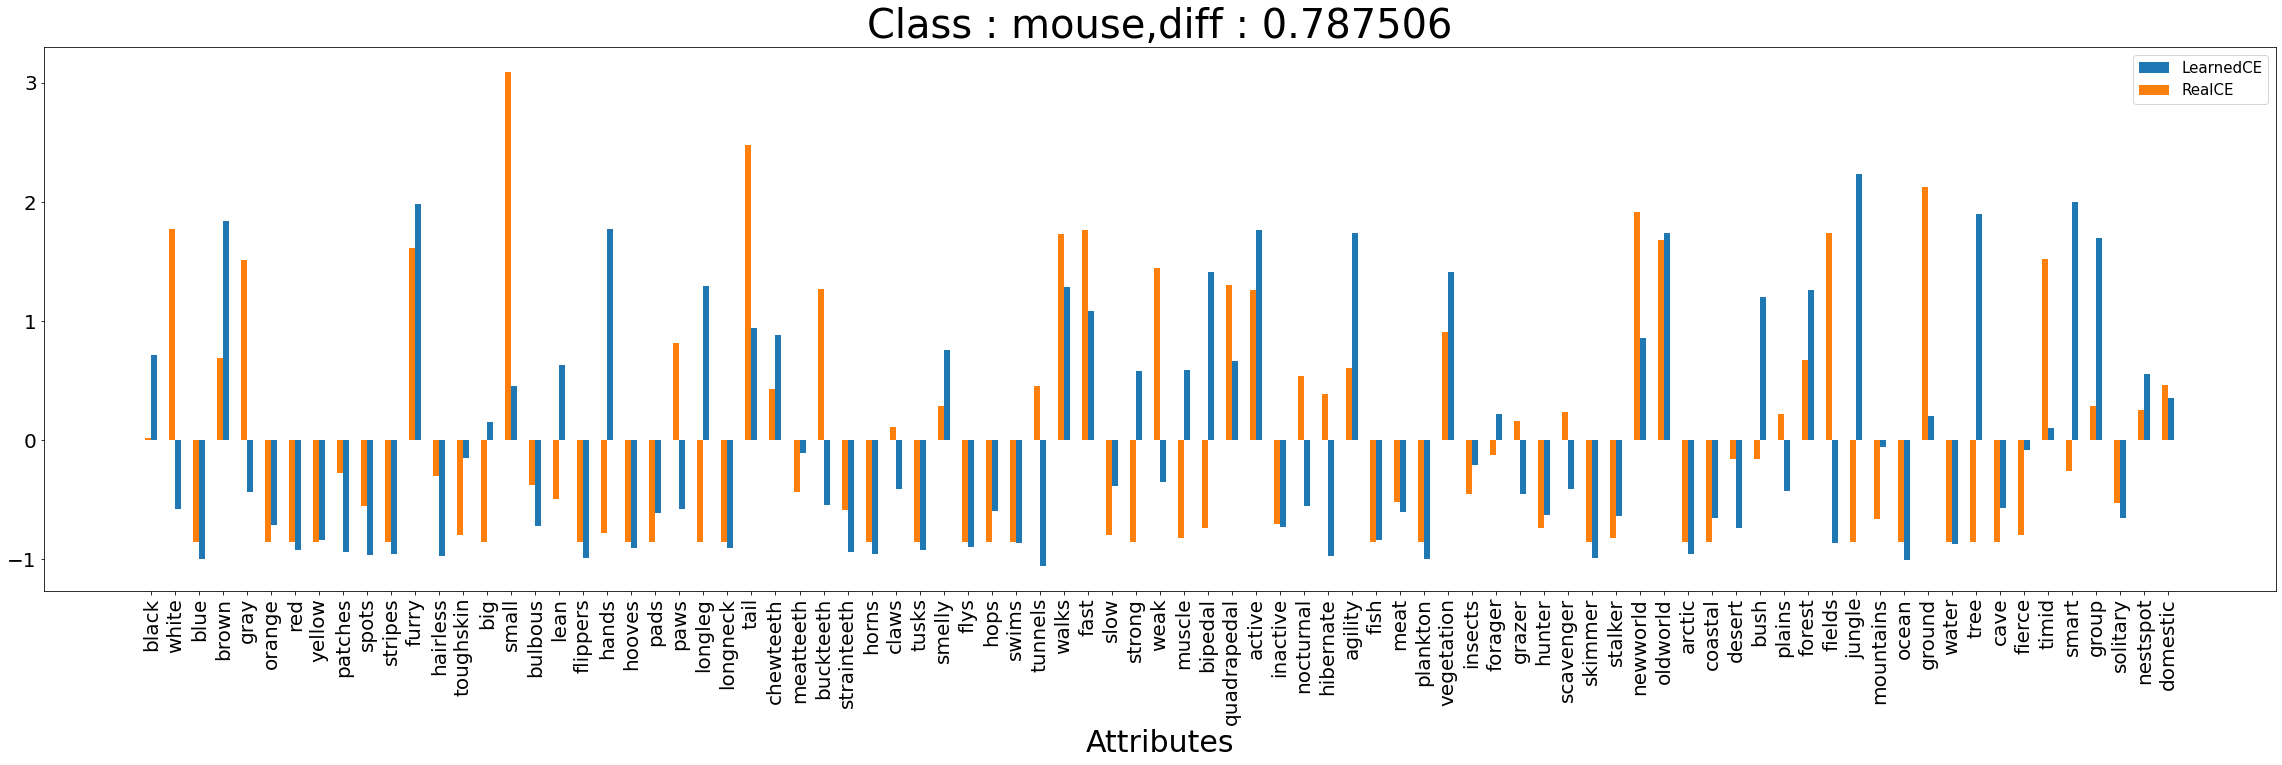

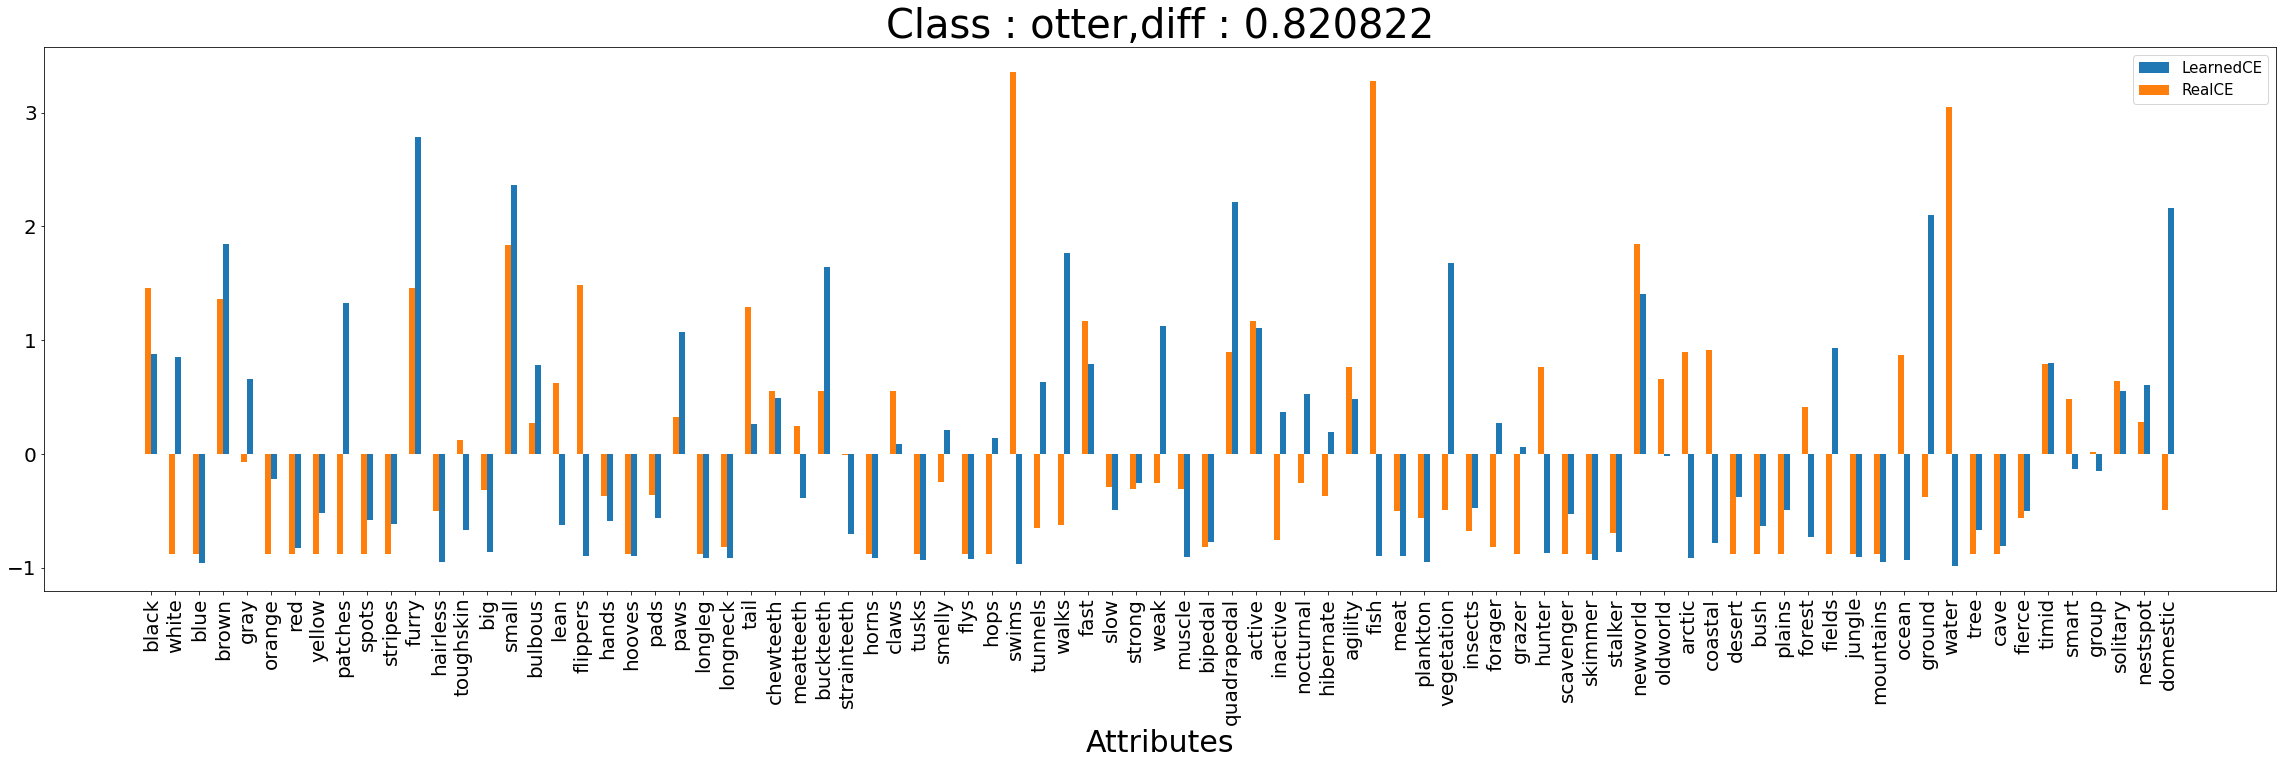

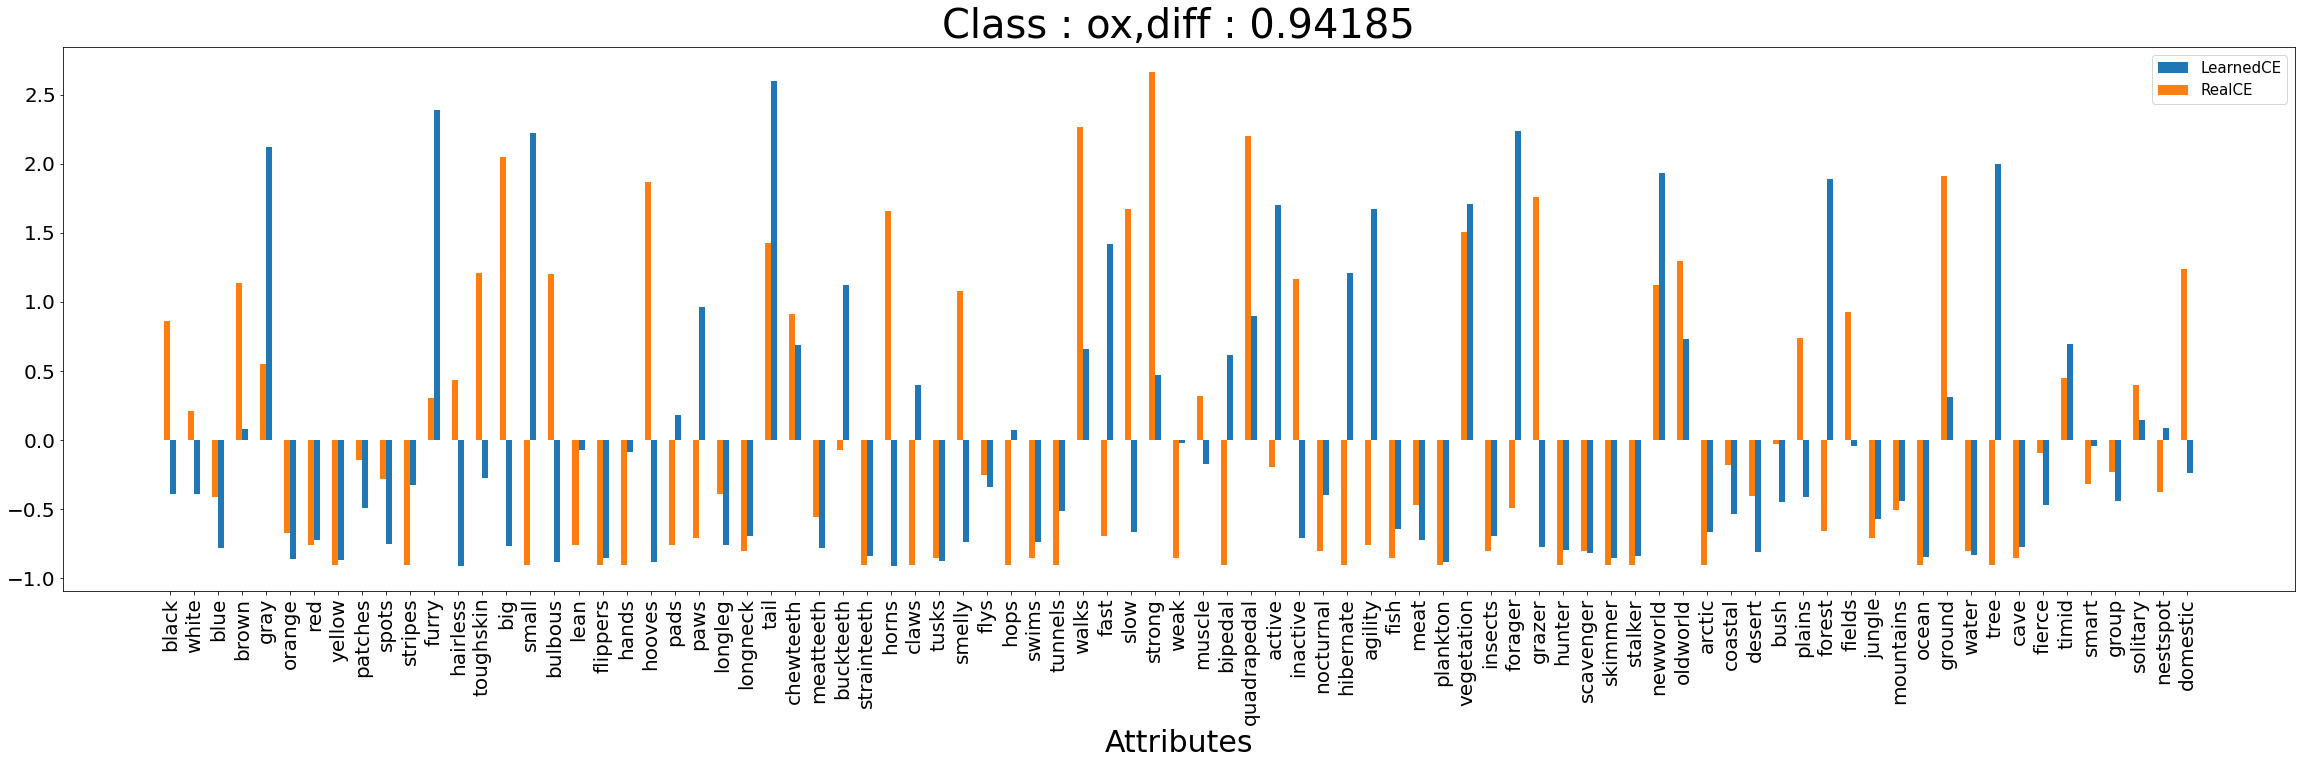

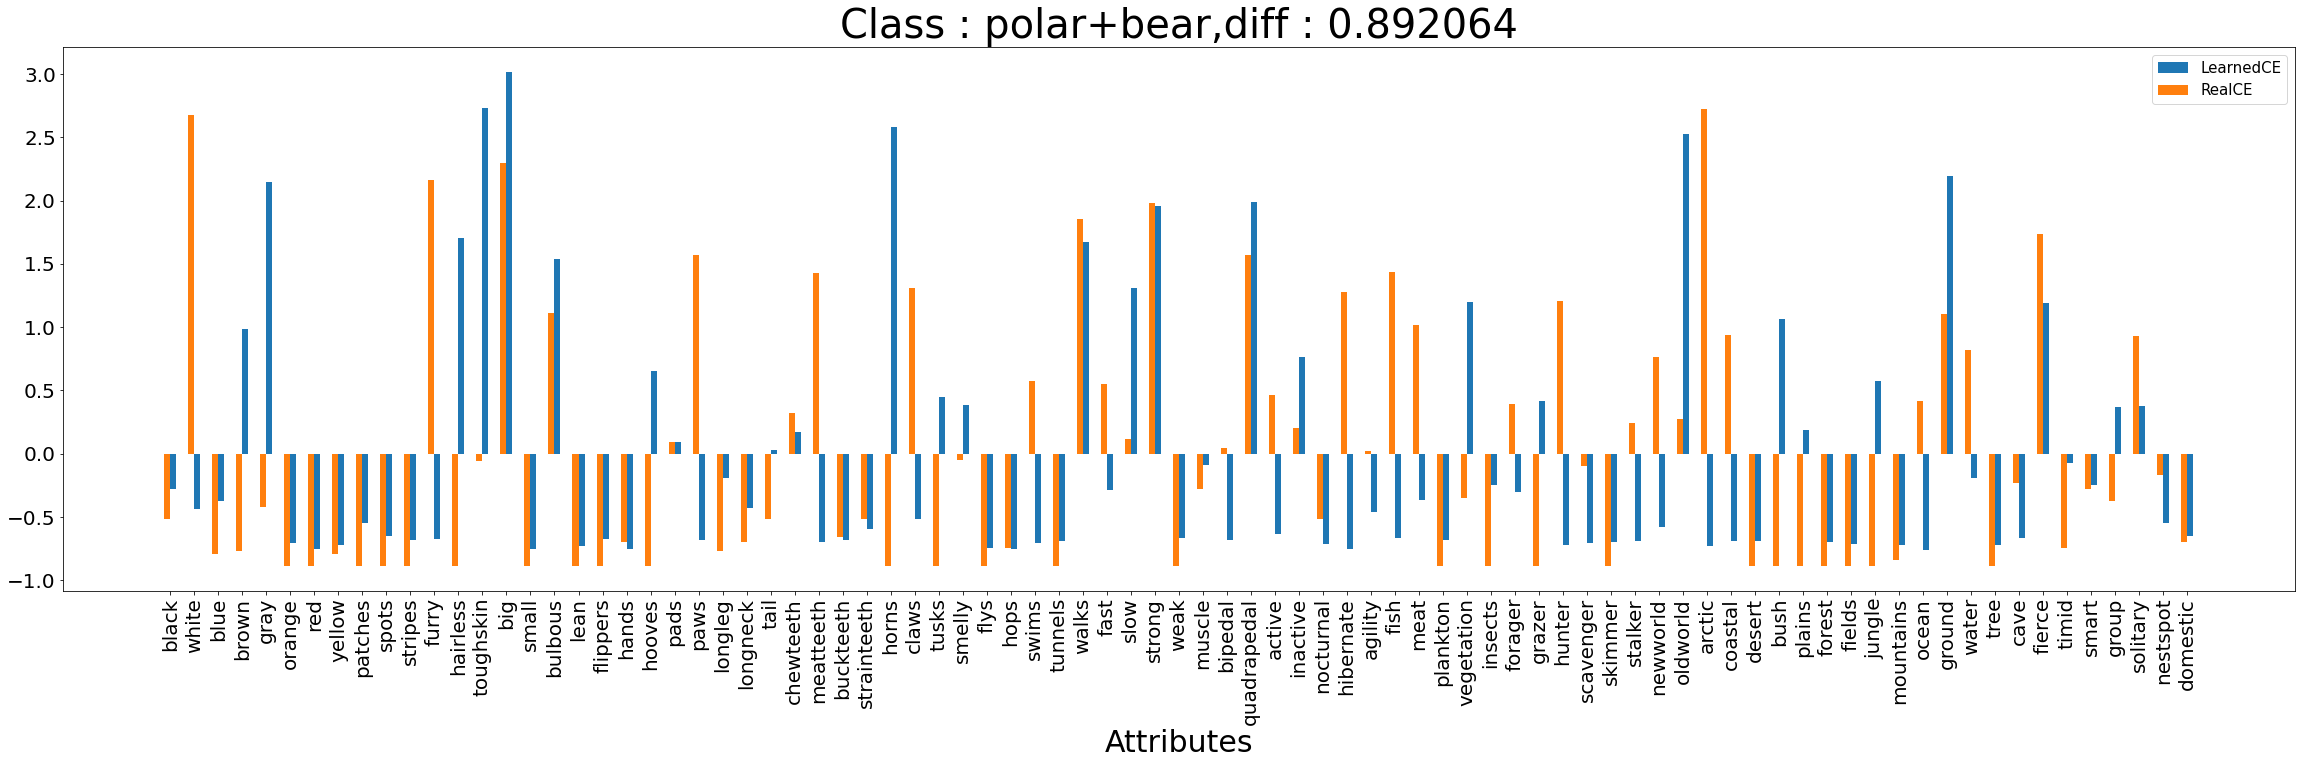

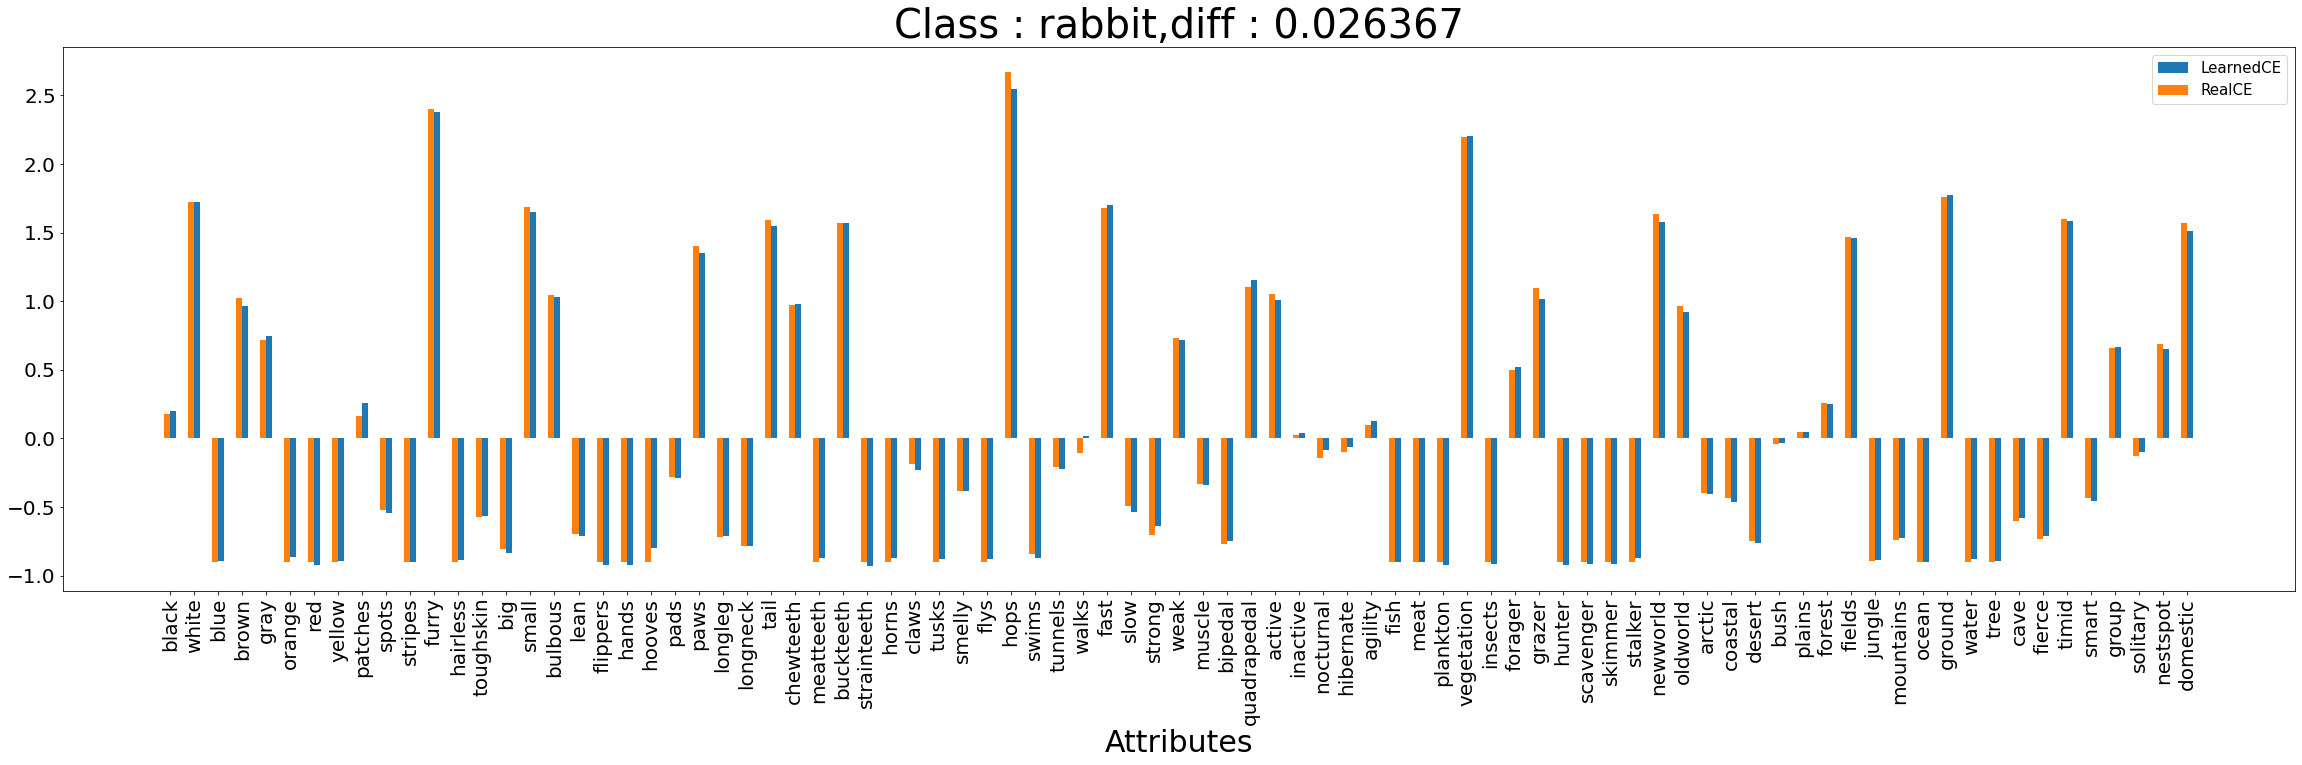

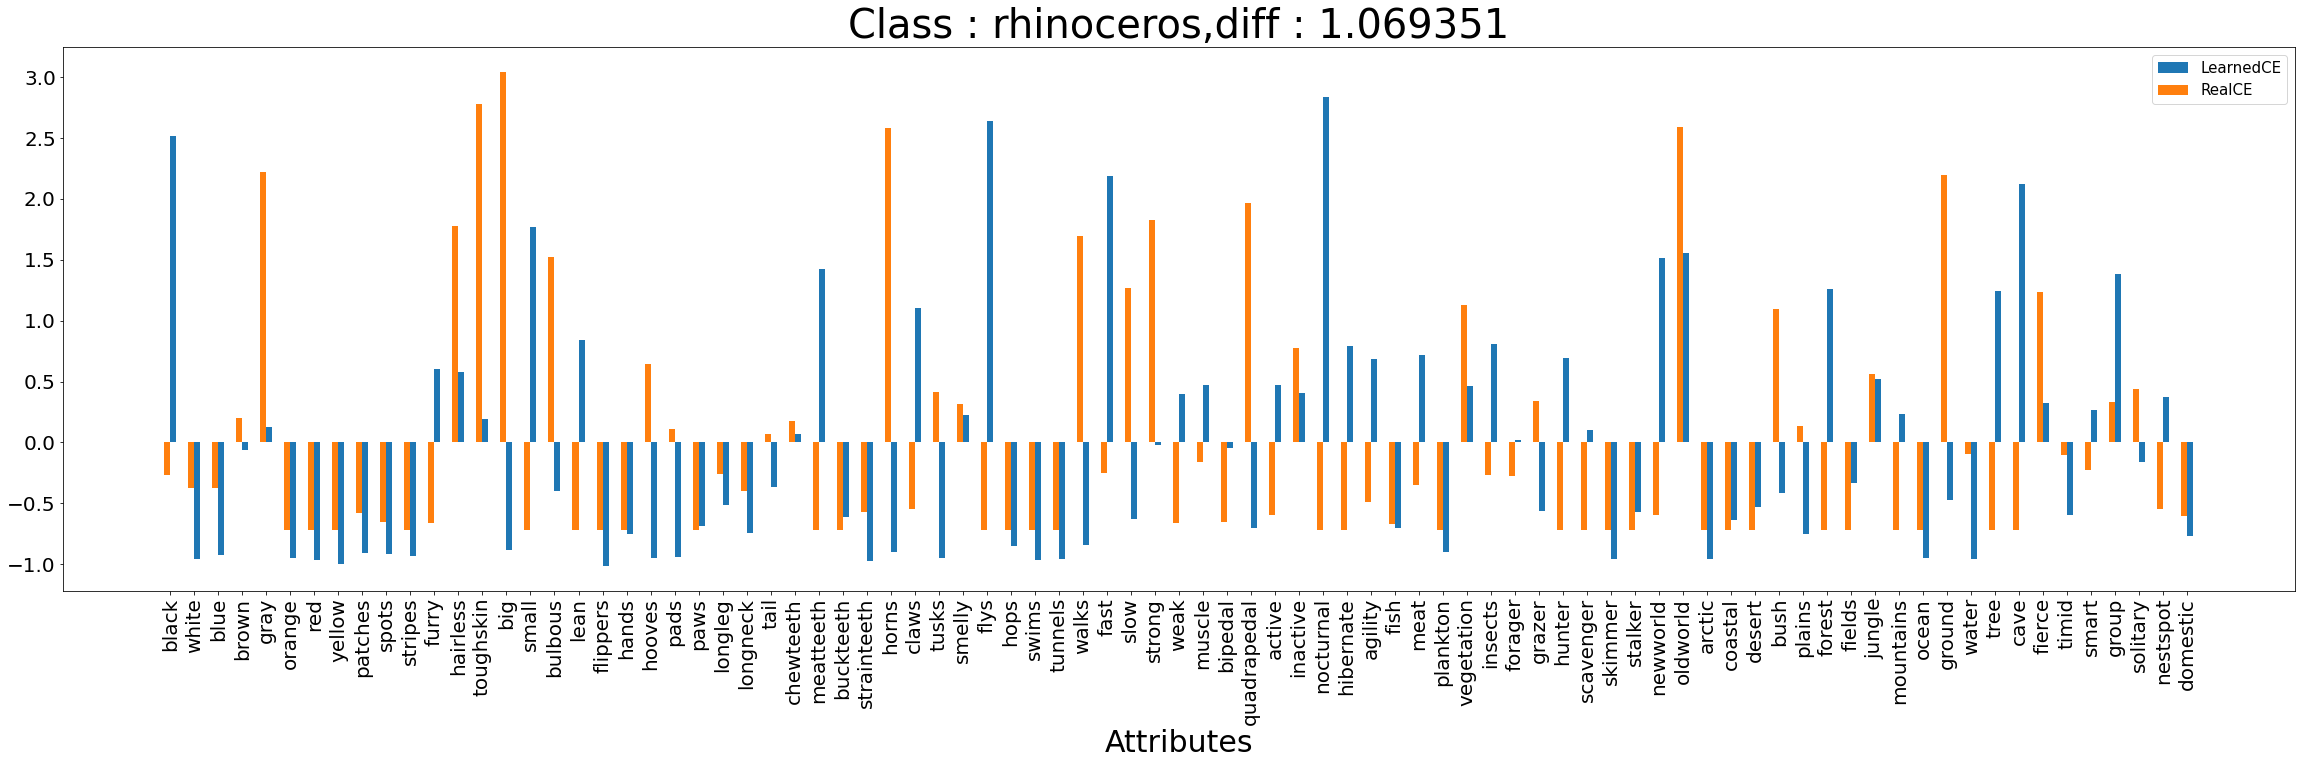

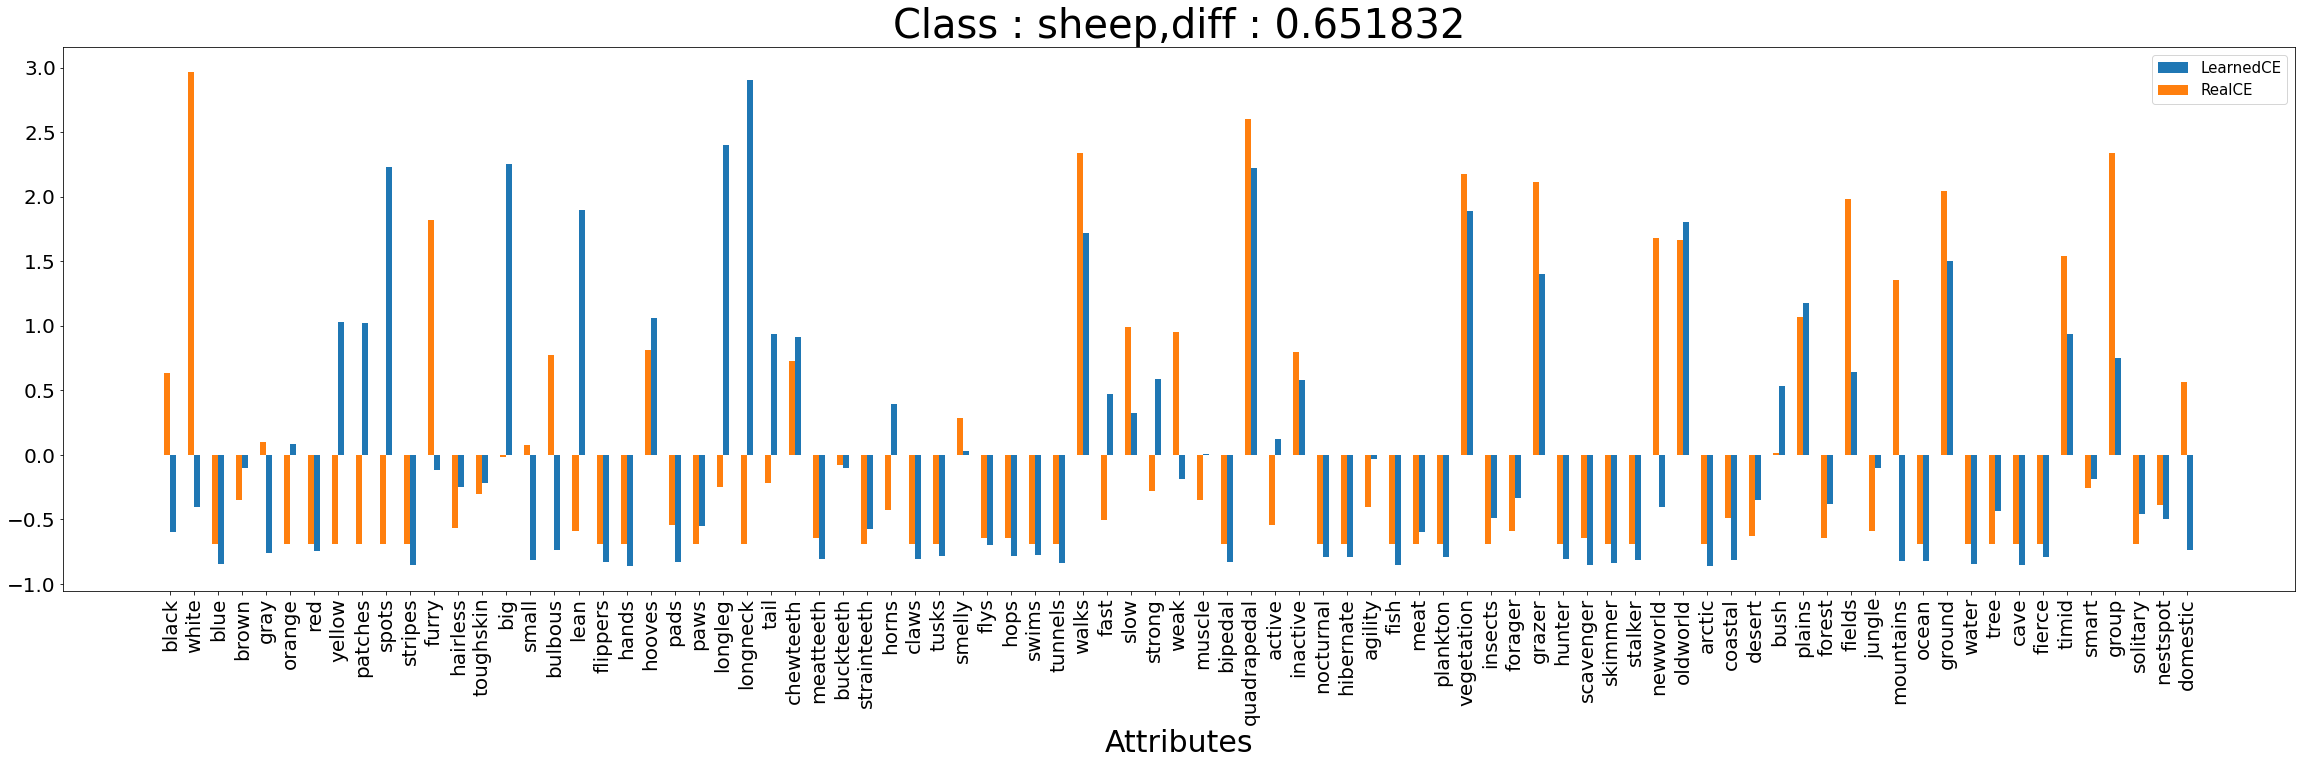

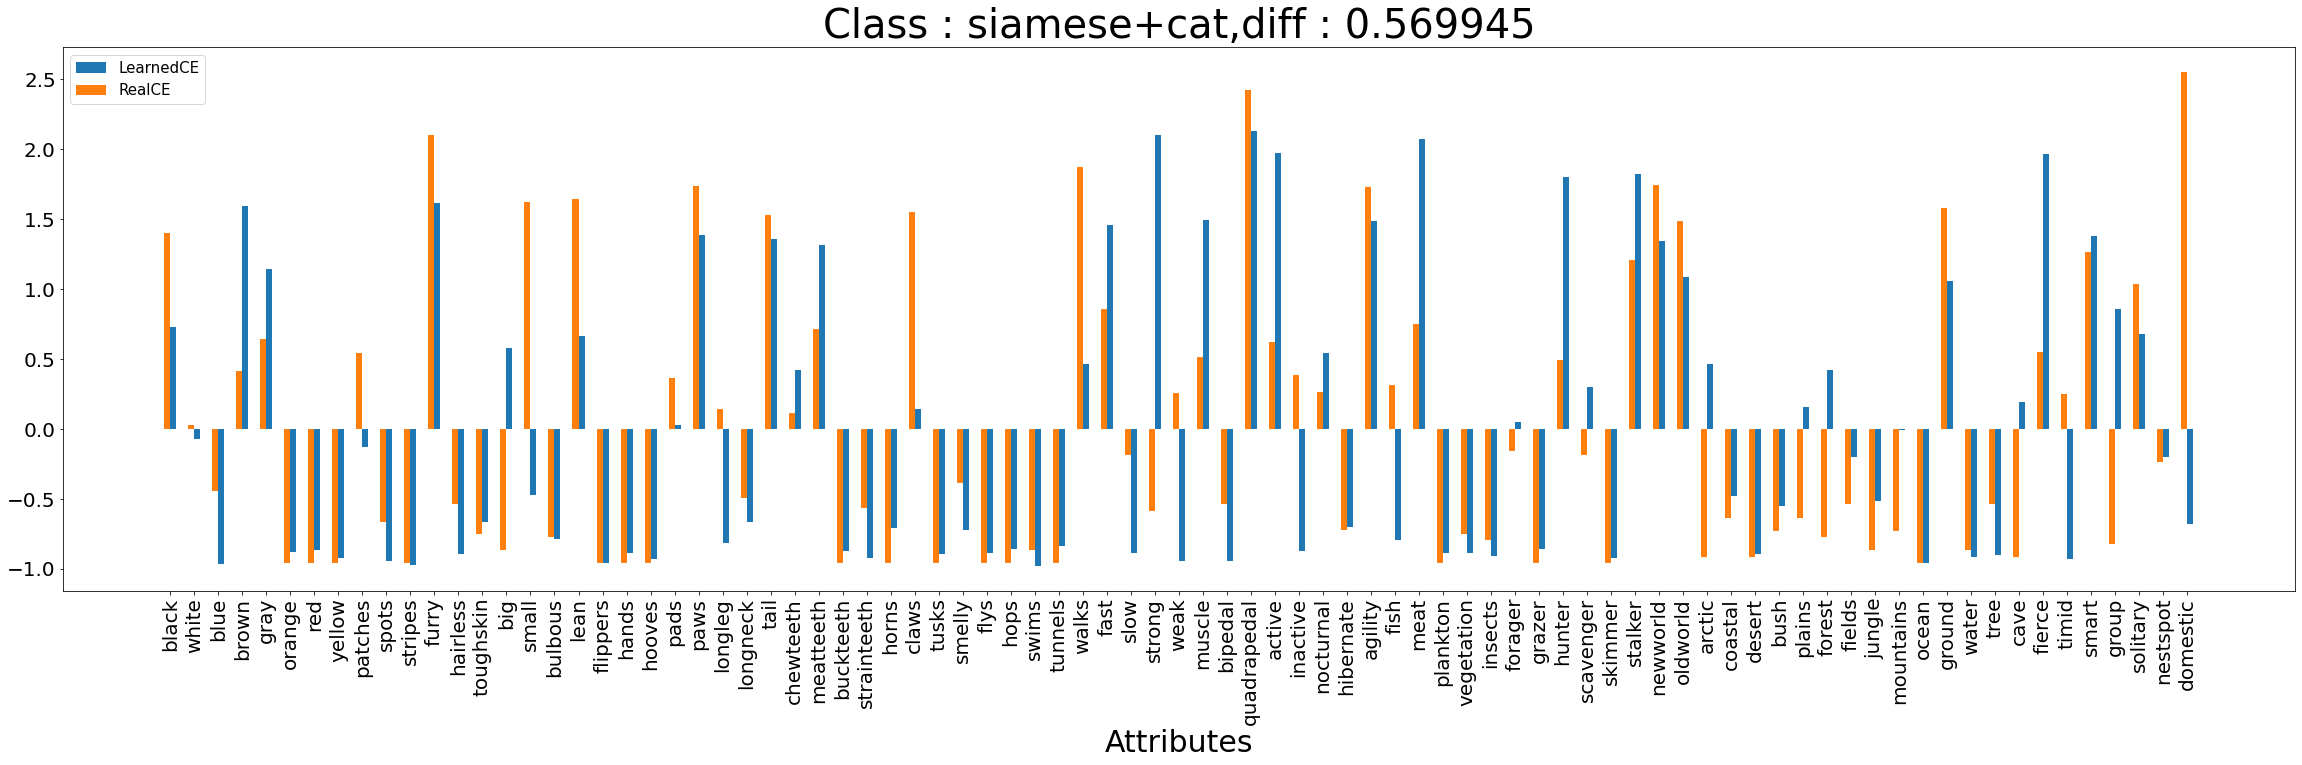

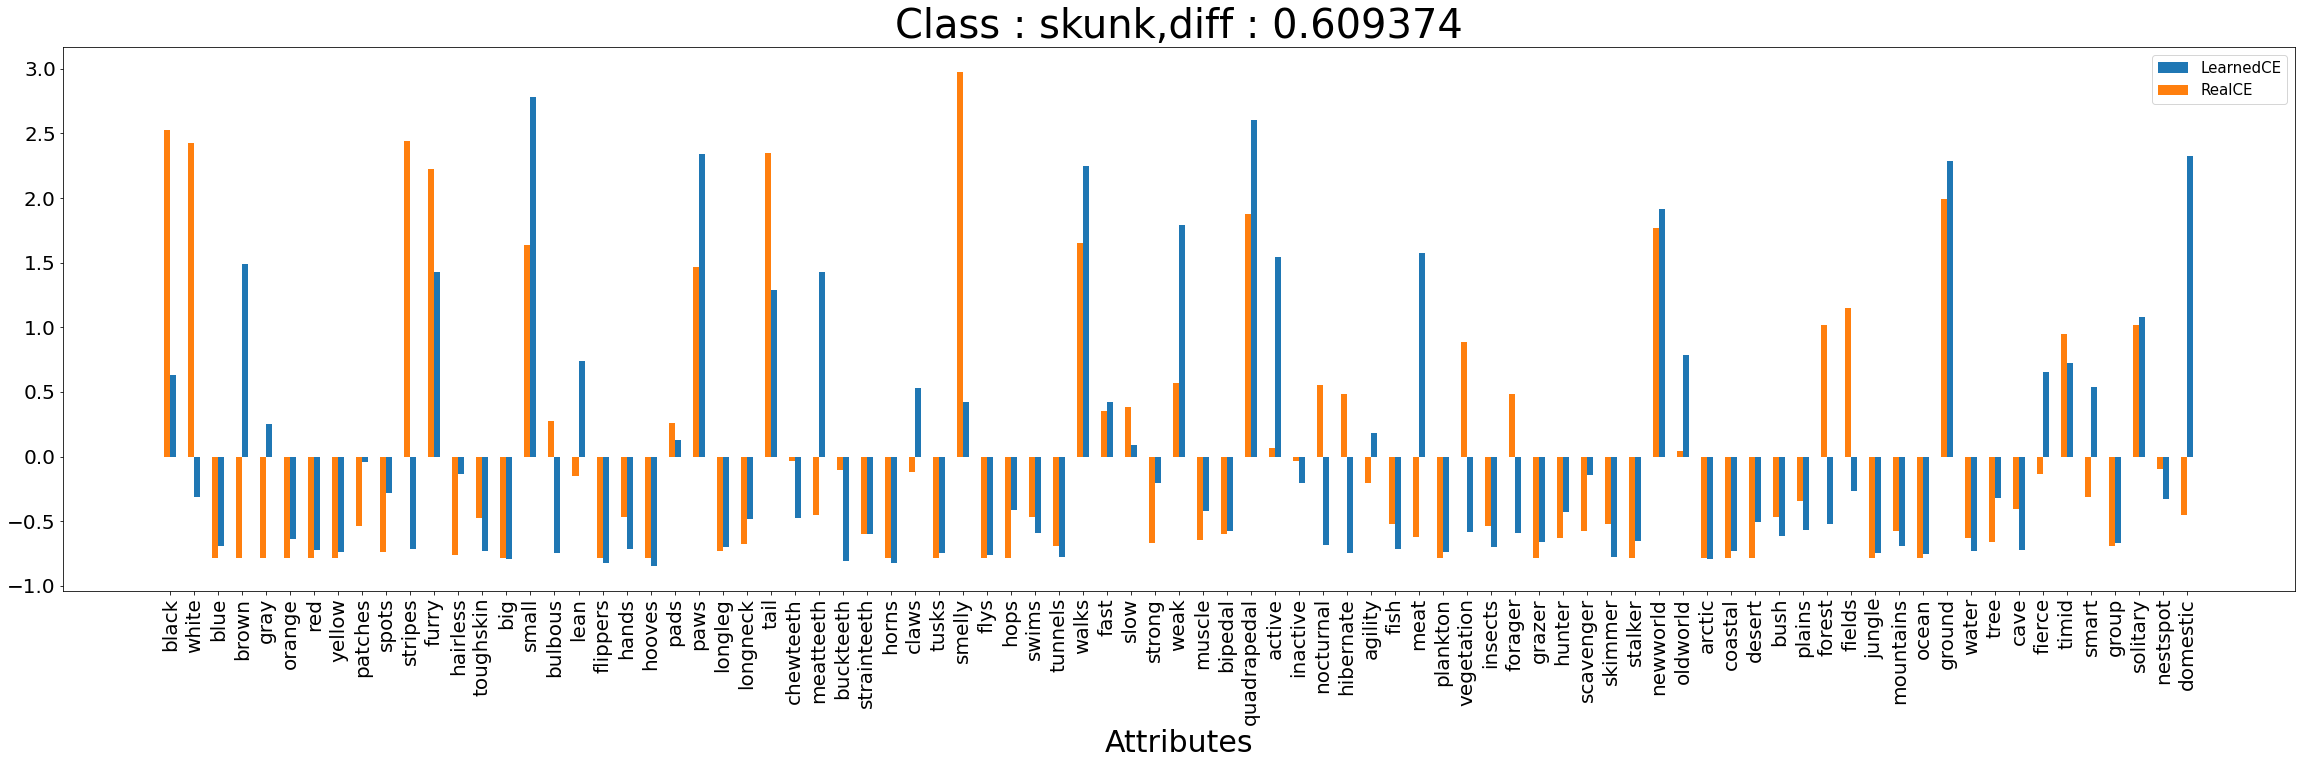

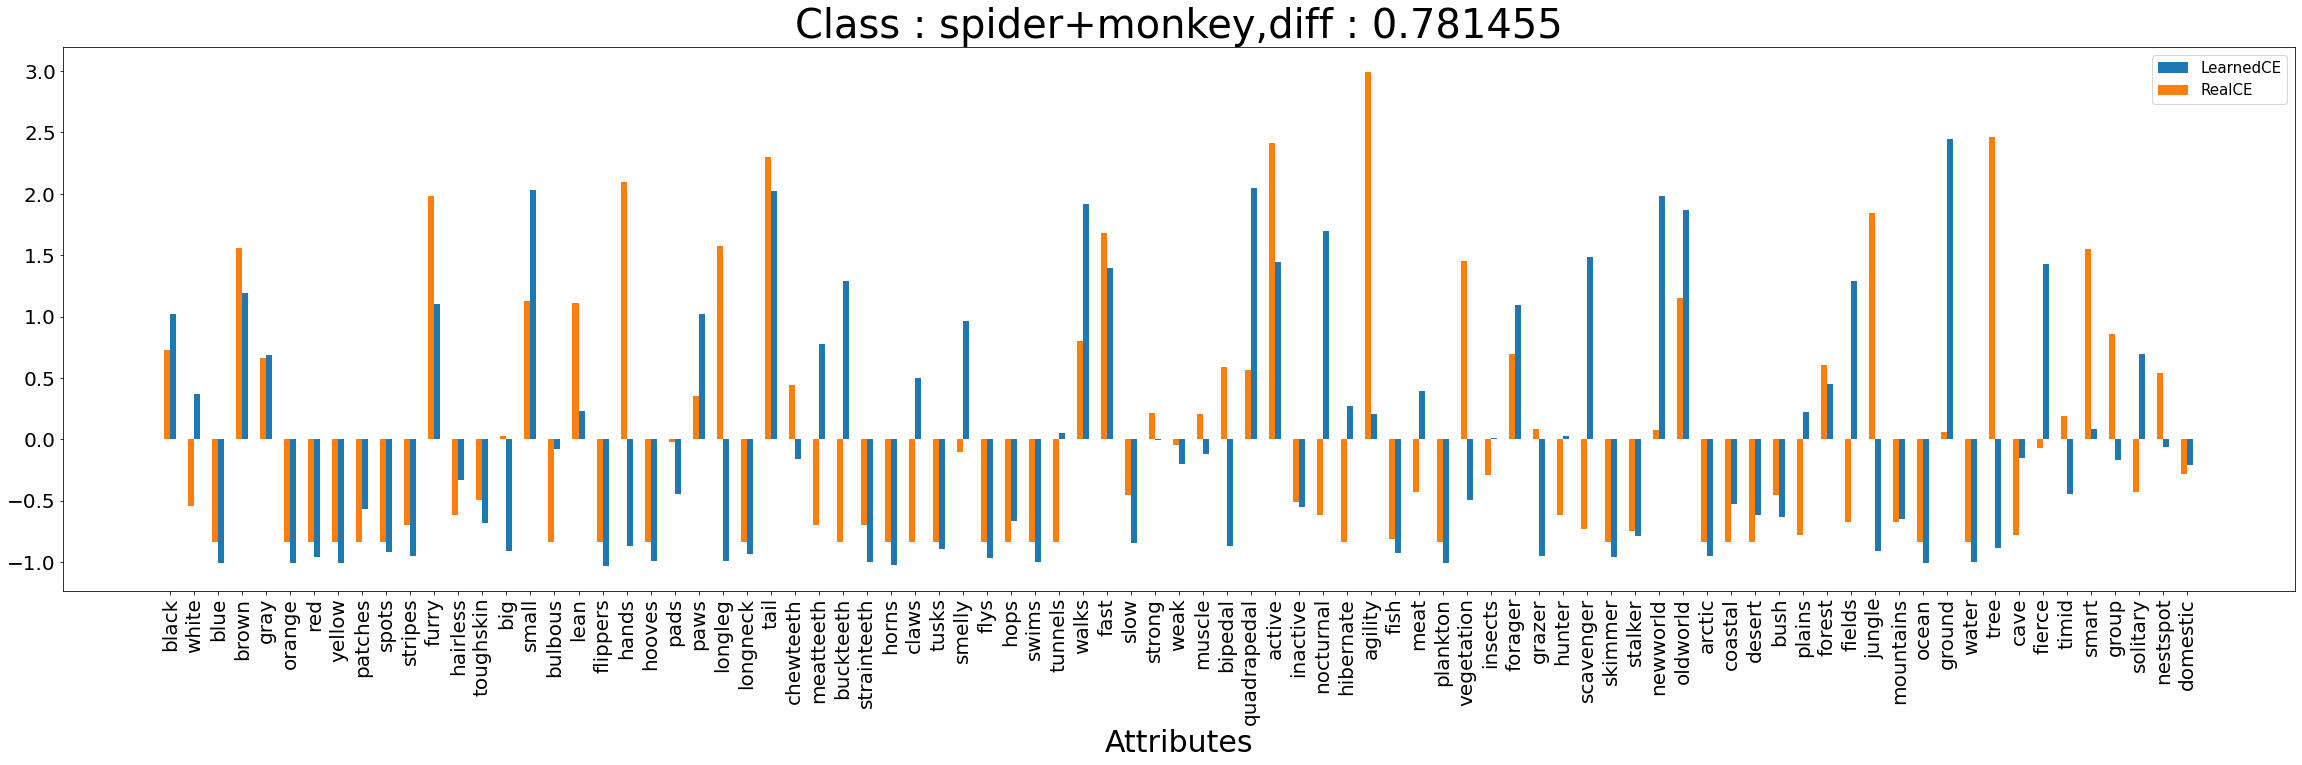

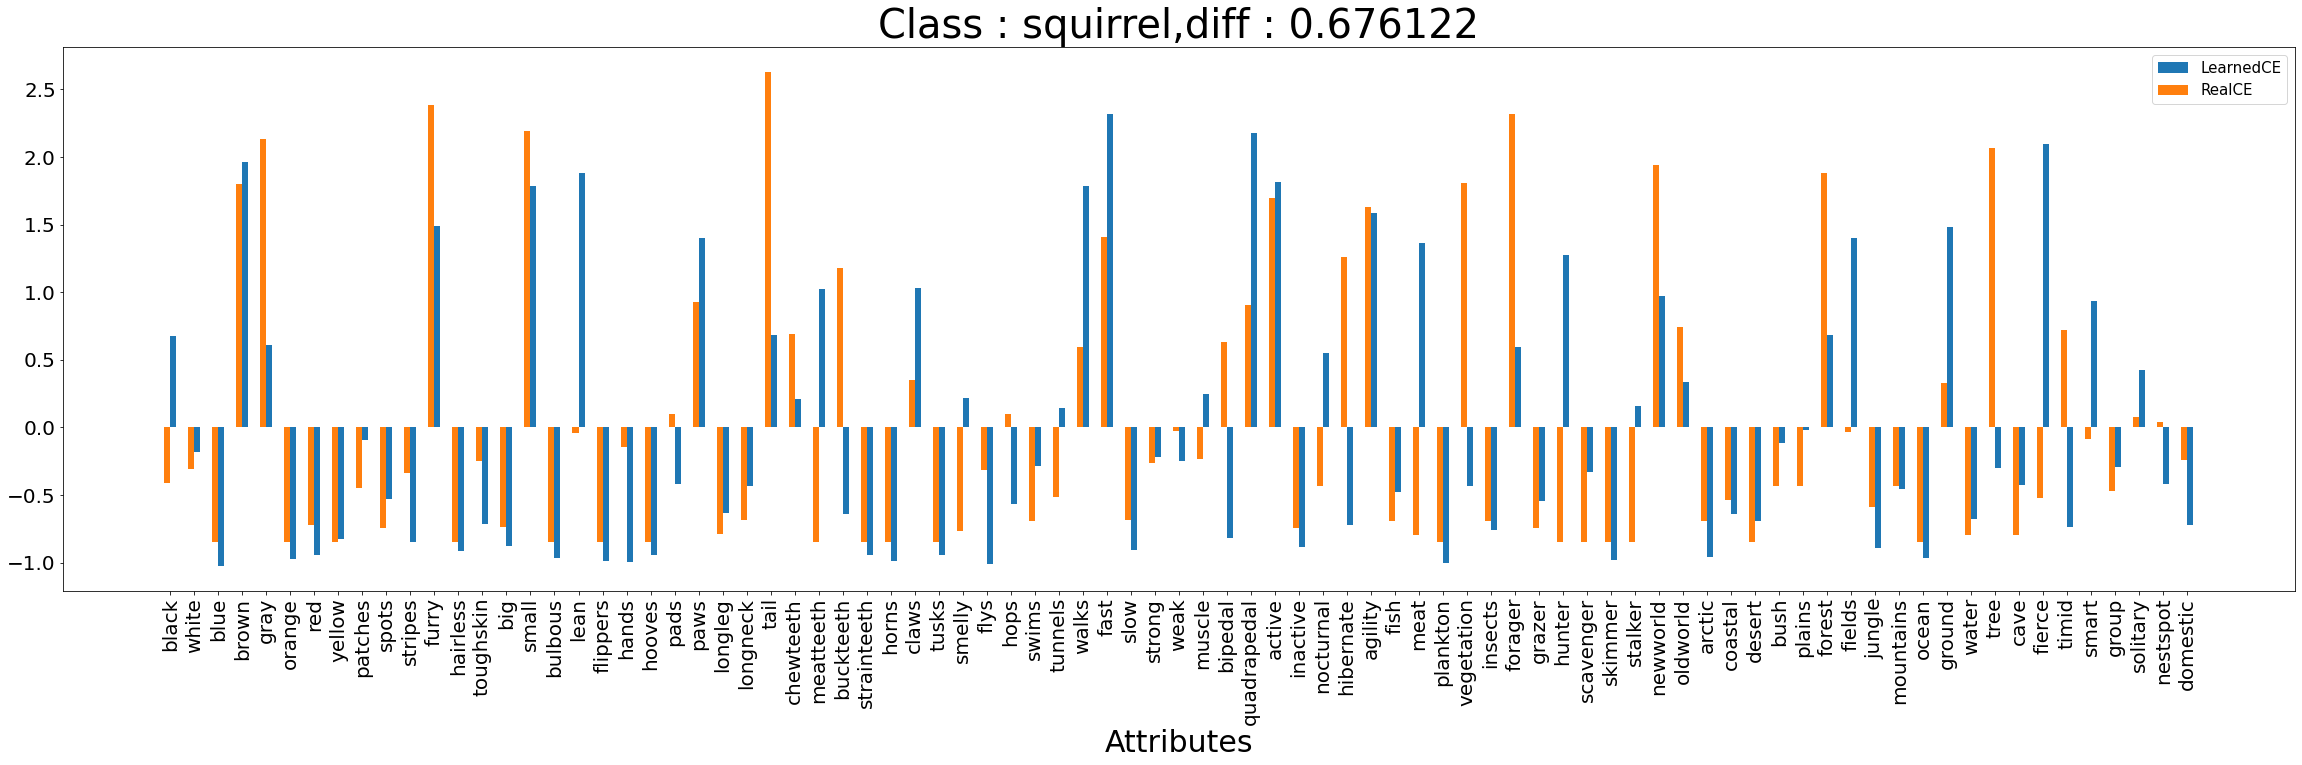

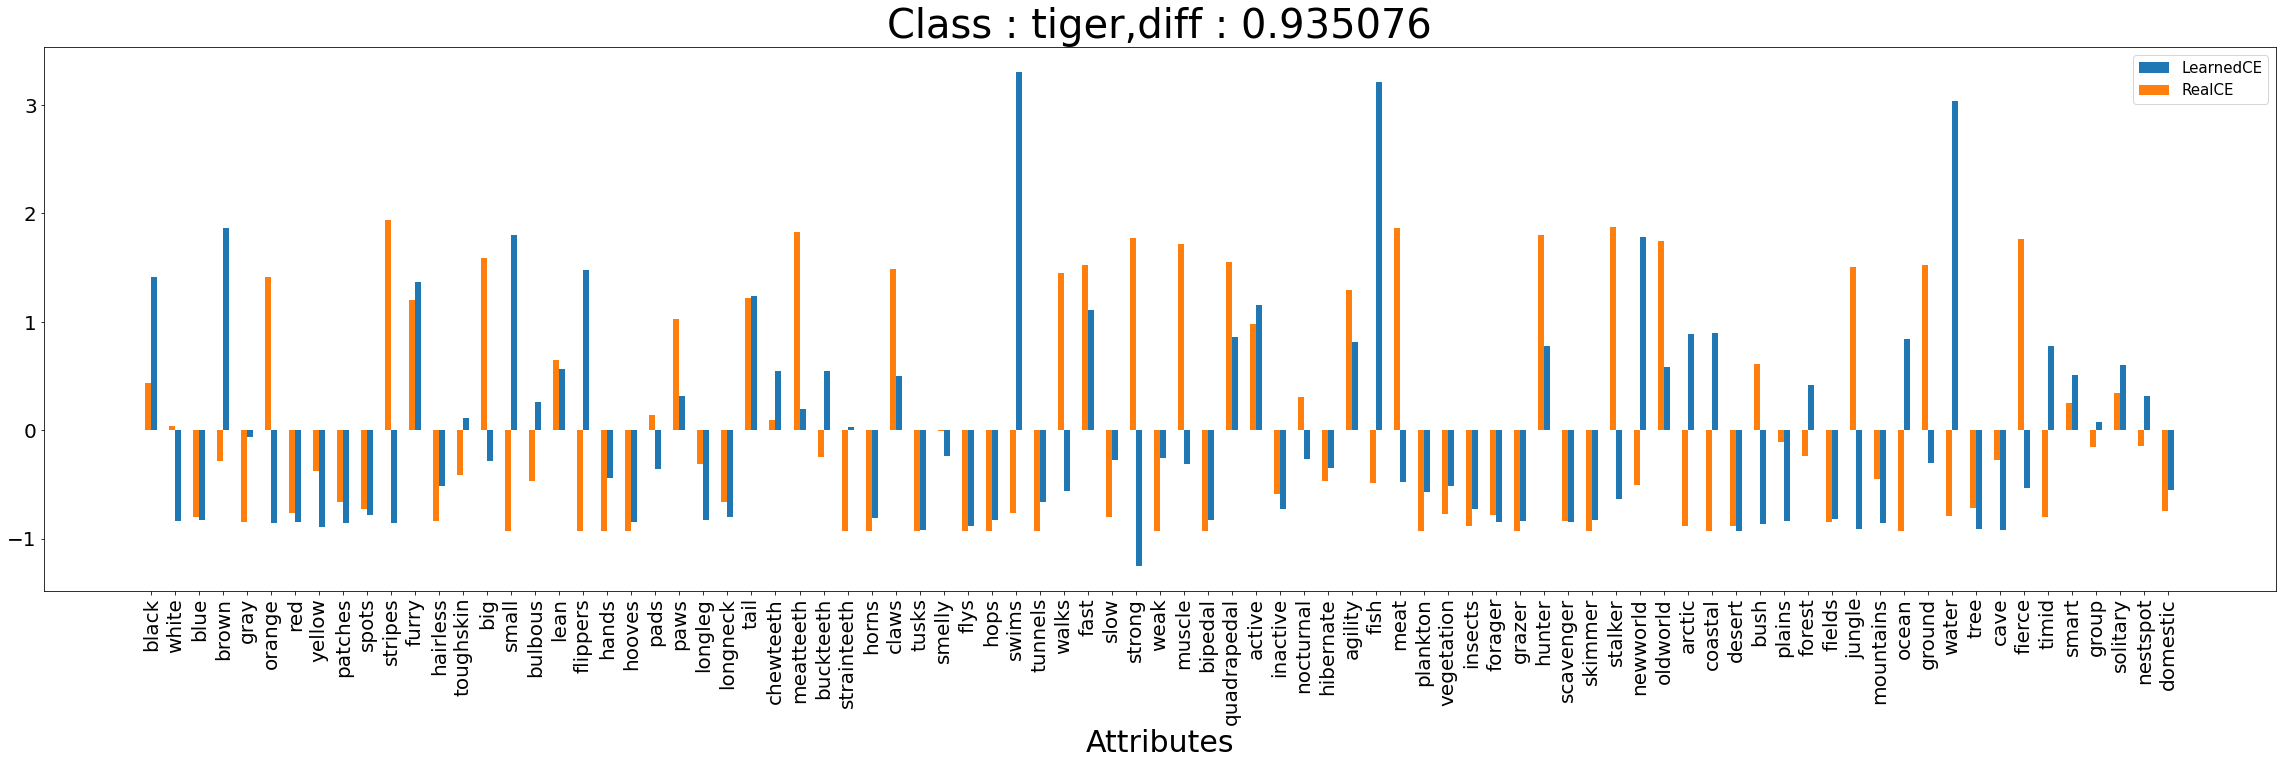

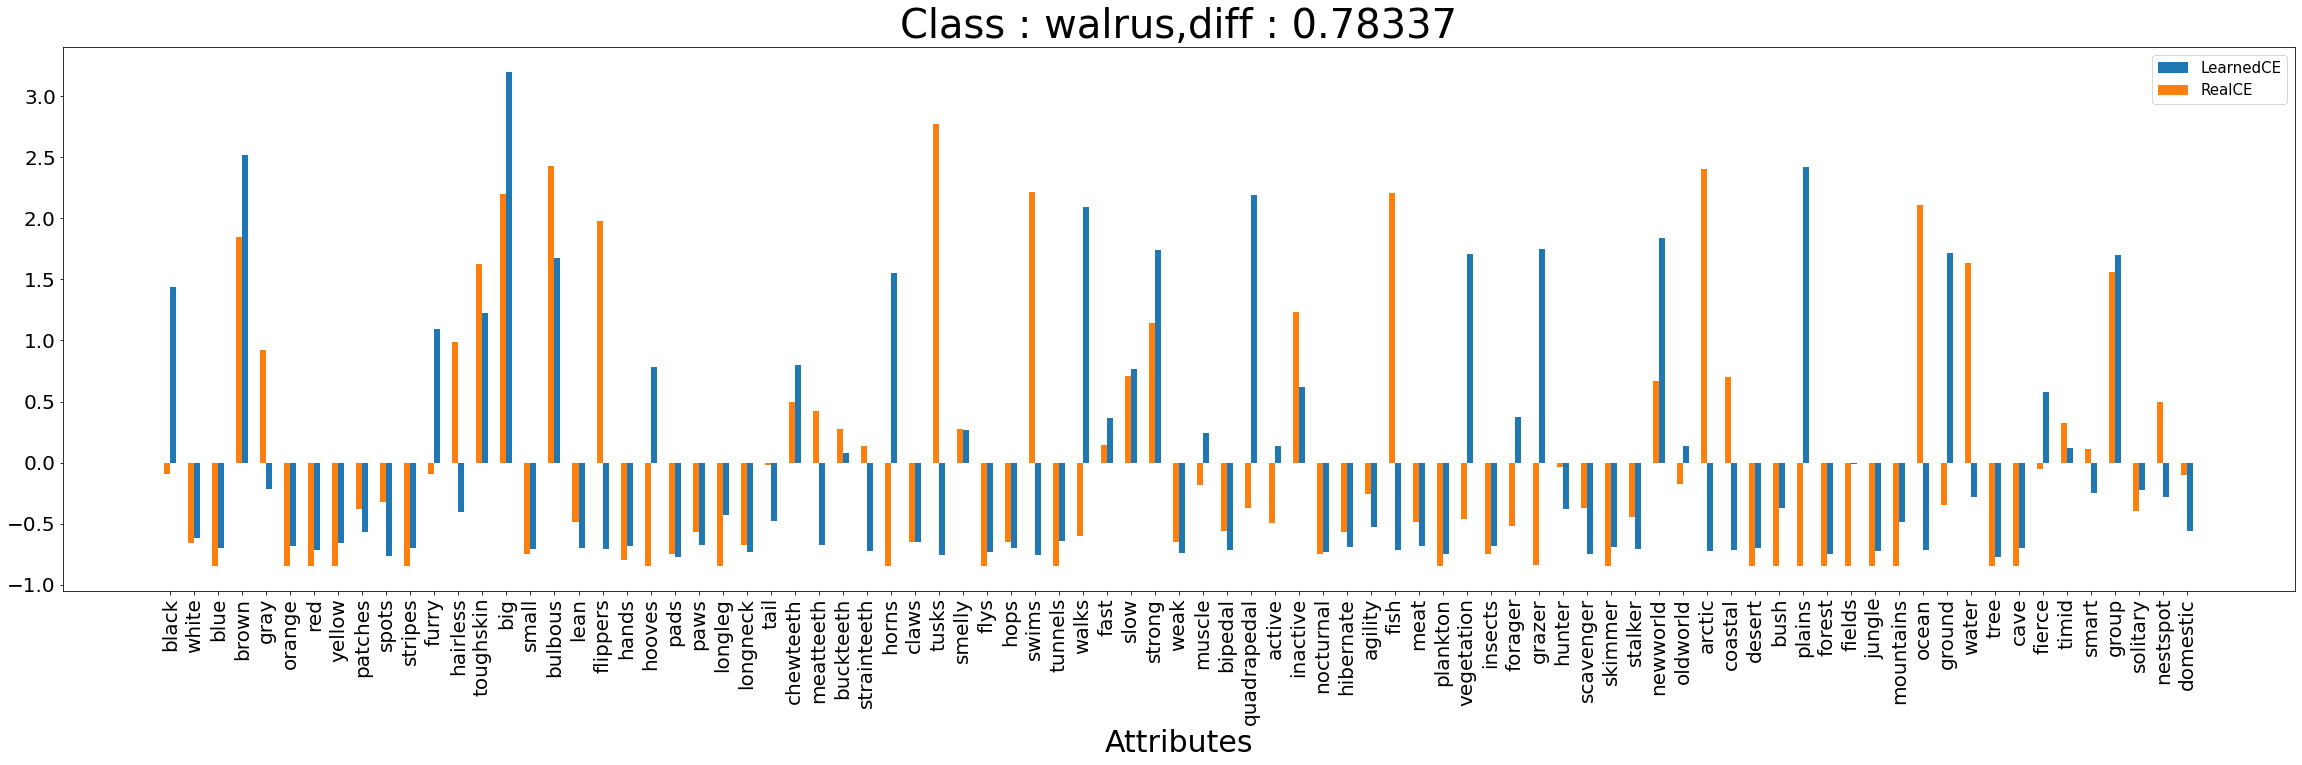

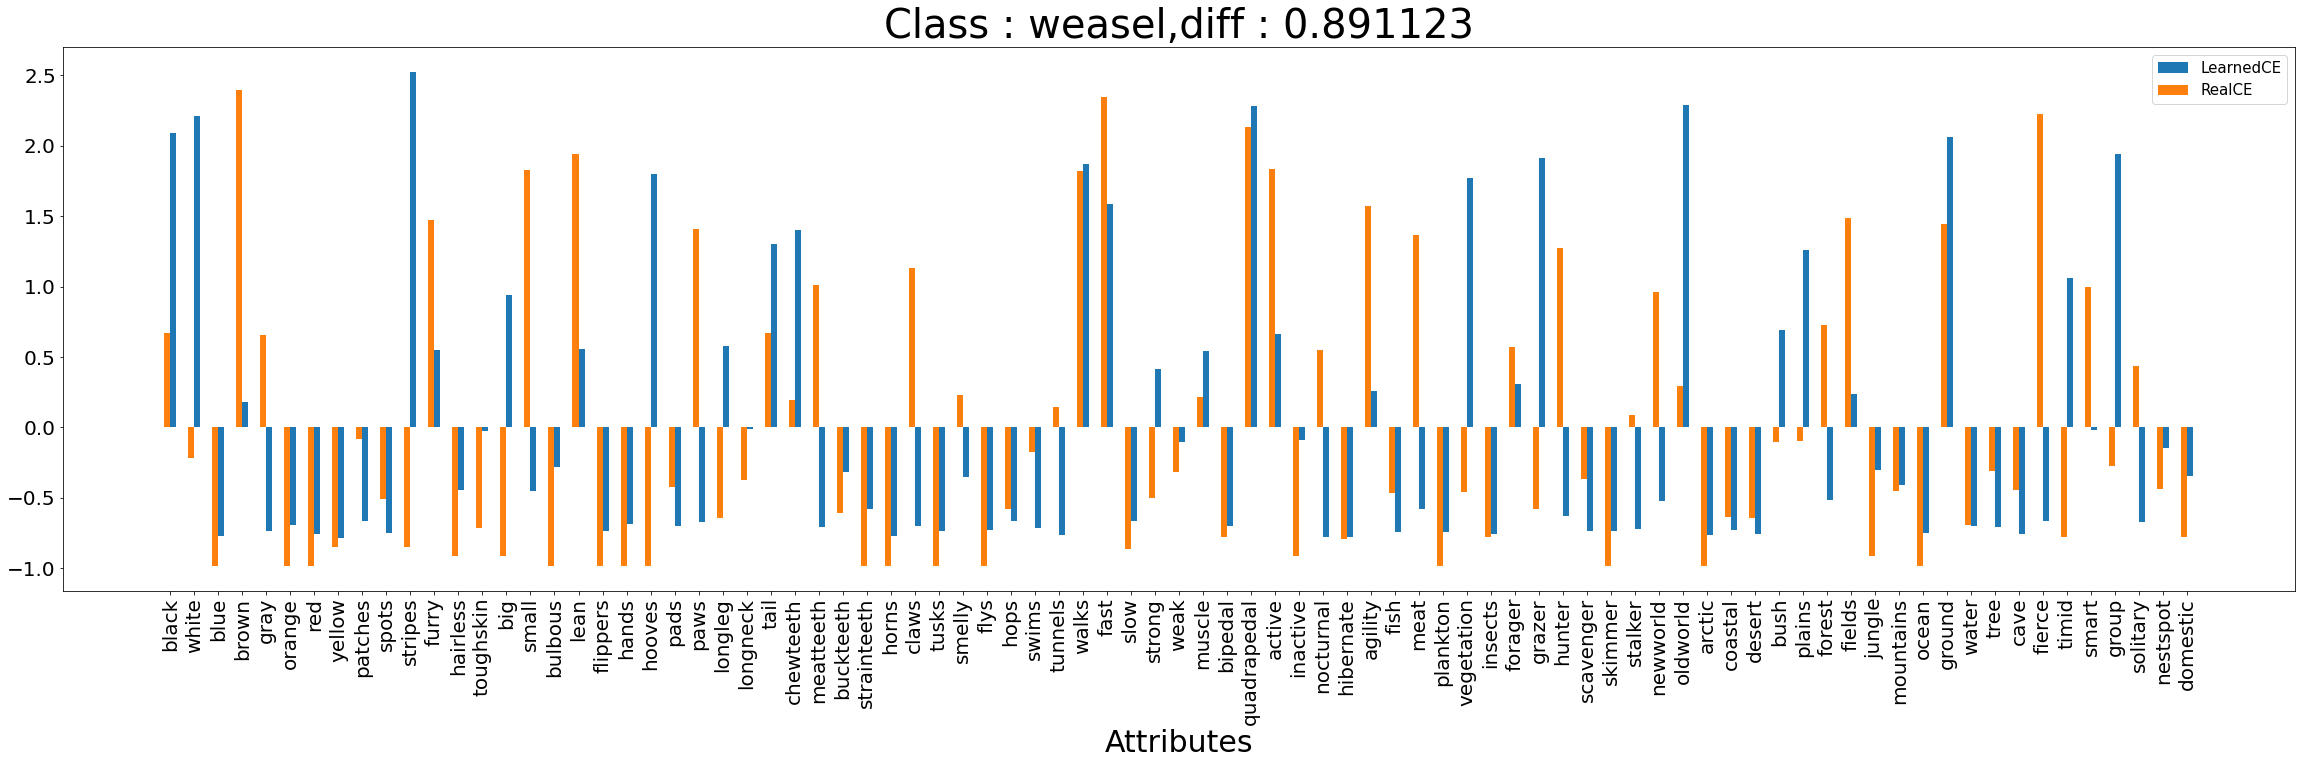

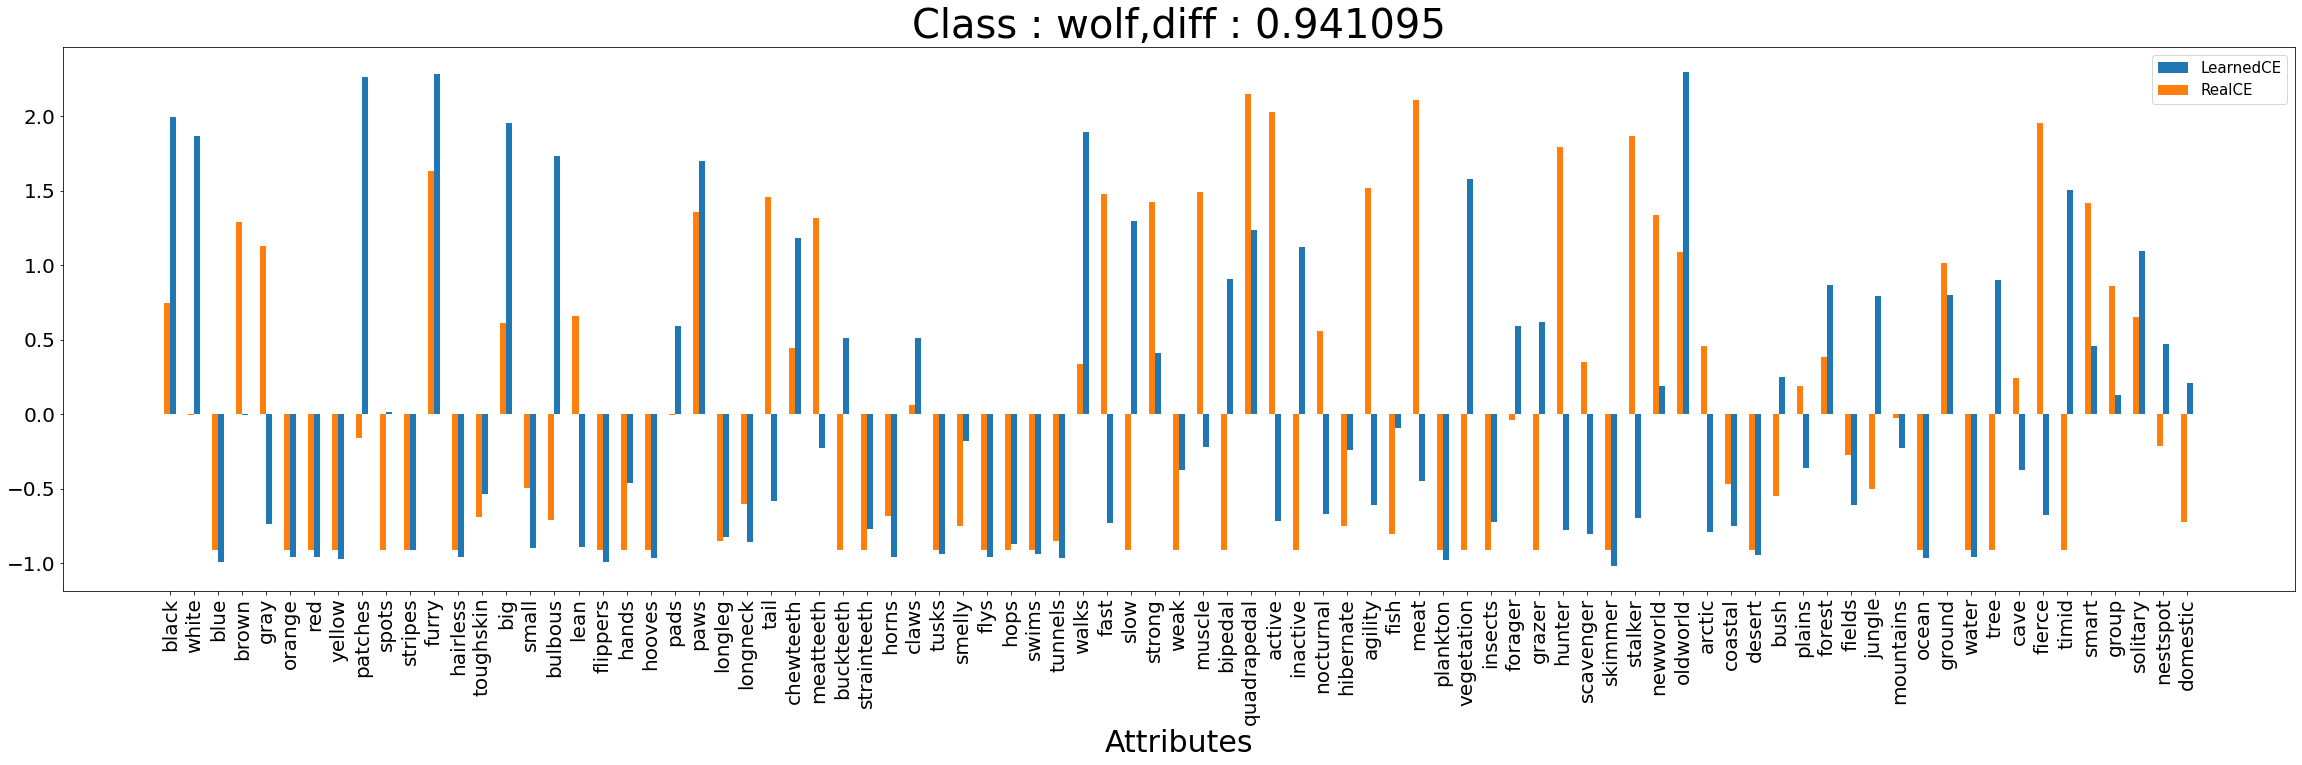

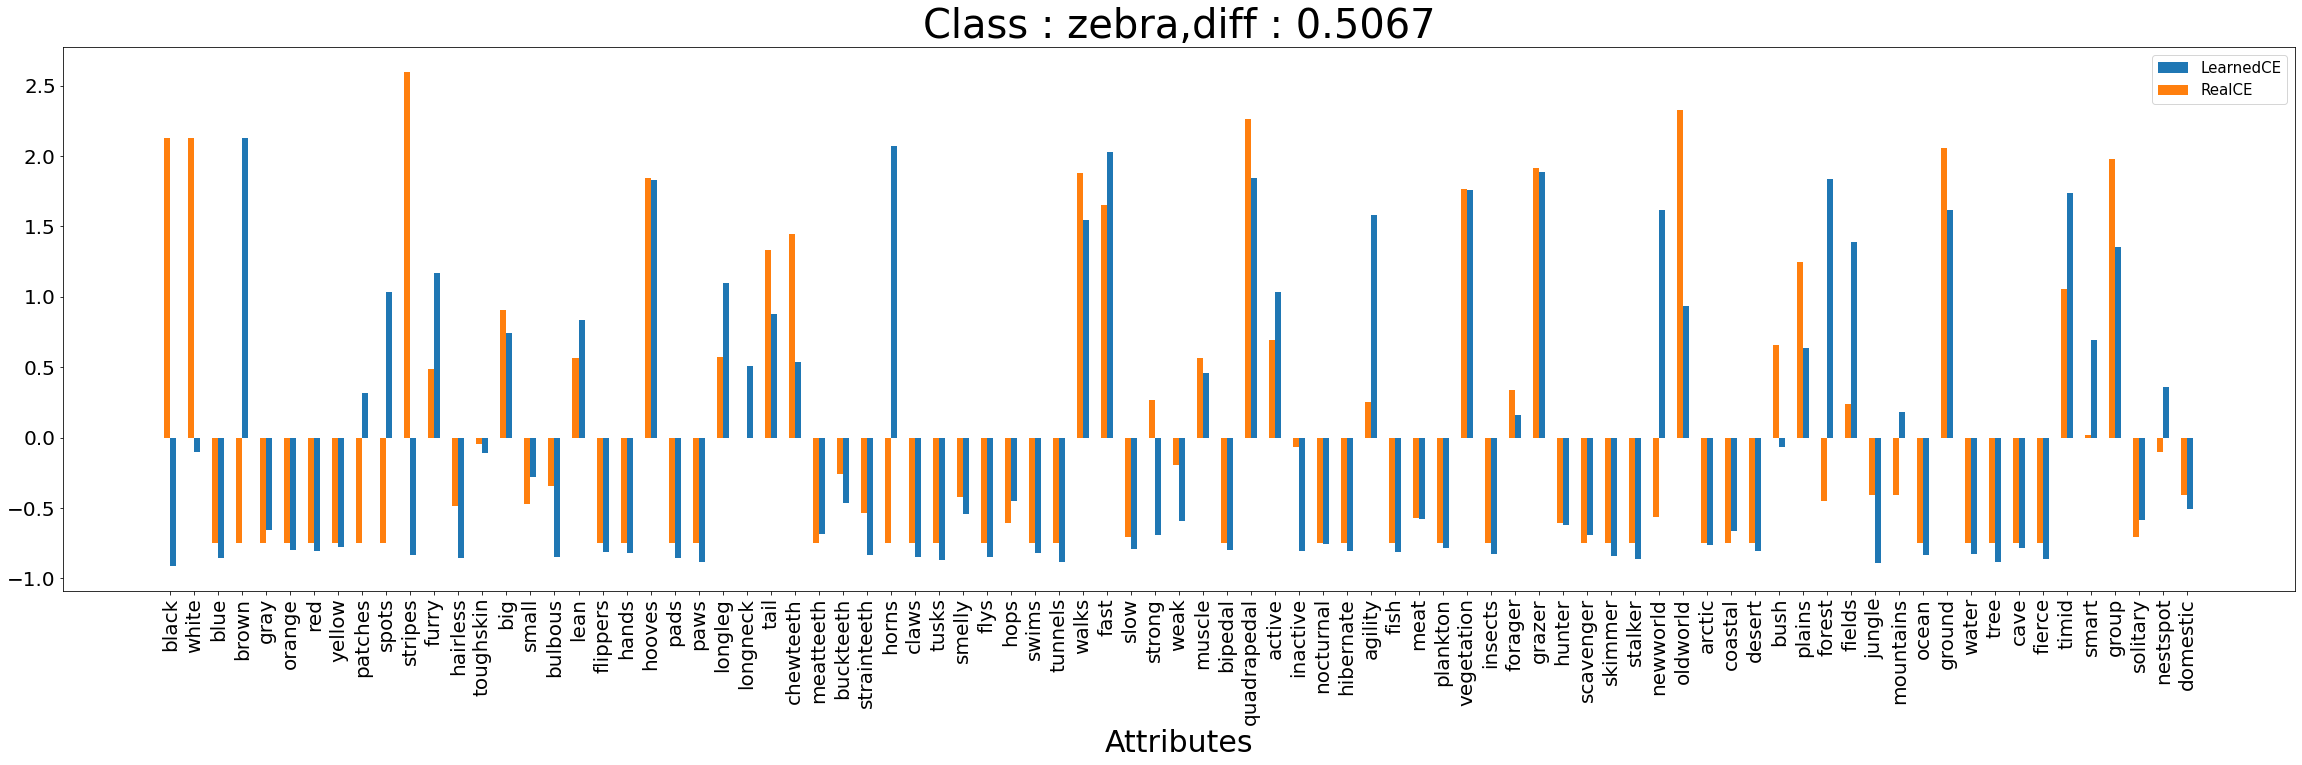

In [36]:
import matplotlib.pyplot as plt
attributes_name = pd.read_csv('./data/{}/predicates.txt'.format(dataset),header=None,sep='\t')


for i in range(seen_class_num):
    diff = round(np.sum(np.abs(sum_attr[i] - real_attr[i])) / len(real_attr[i]),6)
    plt.figure(figsize=(40,10))
    plt.bar(attributes_name[1],height=sum_attr[i],align='edge',label = 'LearnedCE',width = 0.25)
    plt.bar(attributes_name[1],height=real_attr[i],align='edge',label = 'RealCE',width=-0.25)
    plt.legend(fontsize=15) #要使用label要加這行
    plt.xlabel('Attributes',fontsize=30) # 設定x軸標題
    plt.xticks(fontsize=20,rotation='vertical')
    plt.yticks(fontsize=20)
    plt.title('Class : ' + seen_class[i] +',diff : '+ str(diff),fontsize=40) # 設定圖表標題
#     plt.savefig('./data/{}/mat/{}_{}/seen/{}.jpg'.format(dataset,feature_type,attr_type,seen_class[i]))
    plt.show()
